In [17]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import os
import random

seed = 42

In [18]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [19]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
            
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
    else:
        y_scaler = None
        x_scaler = None
        
        
    return x_train, y_train, x_test, y_test 
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [20]:
class RandomizedNetwork(keras.Model):
    
    def __init__(self, input_size, output_size, layers, init=None, reg=None):
        super().__init__()
        
        if init is None:
            init = initializers.RandomNormal(mean=0, stddev=1, seed=None)
        
        self.reg = reg
        
        self.model = Sequential()
                    
            
        units = layers[0]["units"]
        activation = layers[0]["activation"]
        self.model.add(Dense(units, input_dim=input_size, activation=activation,
                    kernel_initializer = init, bias_initializer = init))
        self.model.layers[0].trainable = False
        
        
        
        for layer in layers[1:]:
            activation = layer["activation"]
            units = layer["units"]
            self.model.add(Dense(units, activation=activation, 
                        kernel_initializer = init, bias_initializer = init))
            self.model.layers[-1].trainable = False
        
        self.model.add(Dense(output_size, activation="linear",
                    kernel_initializer = init, bias_initializer = init))
        
        
        self.compile(loss="mse", metrics = mee)
        
        
        
                
    def lms_solve(self, x, y):
        
        n = x.shape[0]
        
        # x_b = np.append(x, np.ones((n,1)), axis=-1)
        for layer in self.model.layers[:-1]:
            x = layer(x)
        
        H = x.numpy()
        H = np.append(H, np.ones((n,1)), axis=-1)
        # H = self.model.layers[0](x).numpy()
        
        # if regularization is used apply direct solution
        if self.reg is not None:
            H_t = H.transpose()
            H = np.matmul(H_t, H)
            I = np.identity(H.shape[0])
            H = H + self.reg*I
            H_star = np.linalg.inv(H)
            W = np.matmul(H_star, H_t)
            W = np.matmul(W, y)
        # if regularization is not used apply numpy LMS solver
        else:
            W, _, _, _ = np.linalg.lstsq(H.T.dot(H), H.T.dot(y))
            
        b = W[-1:][0]
        W = W[:-1]
        
        # print(W.shape)
        # print(b.shape)
        # print(self.model.layers[-1].get_weights()[0].shape)
        # print(self.model.layers[-1].get_weights()[1].shape)
        self.model.layers[-1].set_weights([W, b])

        
    def call(self, x):
        return self.model(x)
    
    def summary(self):
        self.model.summary()
        

In [40]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("initialization")
    keys.remove("trials_train")
    keys.remove("trials_final")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_final"] = params["trials_final"]
        
        configurations.append(dict_conf)
        
        
    return configurations


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

    

def get_model(config, input_size, output_size):
    
    init_method = config["initialization"]["type"]
    reg = config["regularization"]
        
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
        
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1
    
    layers = []
    for l in range(1, n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        layers.append({ 
            "activation": activation,
            "units": n_units
        })
        
    model = RandomizedNetwork(input_size, output_size, layers, init, reg)
        
    return model
    
    

def get_metrics(model, x_train, y_train, x_test=None, y_test=None):
    train_loss, train_metric  = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_metric  = model.evaluate(x_test, y_test, verbose=0) if x_test is not None else [None, None]
    return train_loss, train_metric, test_loss, test_metric
    

def fit_model_k_fold(x_train, y_train, config, n_folds):
    

    train_metric = "mee"
    val_metric = "val_mee"

    trials = config["trials_train"]

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                
                model.lms_solve(x_train_fold, y_train_fold)
                
                trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold)

                trials_val_loss.append(trial_val_loss)
                trials_train_loss.append(trial_train_loss)
                trials_val_acc.append(trial_val_acc)
                trials_train_acc.append(trial_train_acc)

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    train_metric = "mee"
    val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)
            
            pbar.update(1)
    
    # get the mean metrics among the trials
    # med_idx = median_index(trials_val_loss)
    # med_val_loss = trials_val_loss[med_idx]
    # med_train_loss = trials_train_loss[med_idx]
    # med_val_acc = trials_val_acc[med_idx]
    # med_train_acc = trials_train_acc[med_idx]
    
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_final_model(x_train, y_train, config):

    train_metric = "mee"
    val_metric = "val_mee"
    train_loss = "mse"
    val_loss = "mse"

    trials = config["trials_final"]

            
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    models = []
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=None)

    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)
            
            models.append(model)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian val_{val_loss}: {med_val_loss}, std val_{val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    med_model = models[med_idx]
    
    
    y_pred = med_model.predict(x_val)
    
    '''if y_scaler is not None:
        y_pred = y_scaler.inverse_transform(y_pred)
        y_val = y_scaler.inverse_transform(y_val)

    mse_val = mse(y_val, y_pred)
    mee_val = mee(y_val, y_pred)

    print(f"\nValidation MSE: {mse_val}")
    print(f"Validation MEE: {mee_val}")'''
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss


def assess_model(model, x_test, y_test, scale=True):
    global y_scaler
    y_test_pred = model.predict(x_test)
    
    if scale: 
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test = y_scaler.inverse_transform(y_test)
    
    mse_test = mse(y_test, y_test_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")
    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
    
    return model

In [41]:
normal = {
    "type": "normal",
    "mean": 0,
    "std": 1
}

unif = {
    "type": "uniform",
    "min": -1,
    "max": 1
}


params = {
    "trials_train": 3,
    "trials_final": 5,
    "initialization": normal,
    "regularization": [0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "layers": [
        {
            "activations": ["tanh", "relu"],
            "units": [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        }
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


# ML Cup

In [42]:
x_train, y_train, x_test, y_test = load_dataset("cup", False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1194, 9) (1194, 2)
(298, 9) (298, 2)


In [43]:
model = grid_search(params, x_train, y_train, k_fold_val)
assess_model(model, x_test, y_test, False)

Testing configuration 1/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 1/4 median val_loss: 4.155263423919678, std val_loss 0.22412461240084403
Fold 1/4 median train_loss: 3.979909896850586, std train_loss 0.09722329407473151
Fold 1/4 median val_mee: 2.4071614742279053, std val_mee 0.10862497616760677
Fold 1/4 median train_mee: 2.4109535217285156, train_mee 0.0515025479378424

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 2/4 median val_loss: 3.645195484161377, std val_loss 0.3347993255297003
Fold 2/4 median train_loss: 4.21461820602417, std train_loss 0.28629463923198806
Fold 2/4 median val_mee: 2.348906993865967, std val_mee 0.13746983146777042
Fold 2/4 median train_mee: 2.4580624103546143, train_mee 0.10357903811696378

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 3/4 median val_loss: 4.03377103805542, std val_loss 0.438647152333588
Fold 3/4 median train_loss: 3.376133680343628, std train_loss 0.5108230192059151
Fold 3/4 median val_mee: 2.4268081188201904, std val_mee 0.18575663390000477
Fold 3/4 median train_mee: 2.212818145751953, train_mee 0.19069659617941584

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Fold 4/4 median val_loss: 4.707980632781982, std val_loss 0.35410787146327666
Fold 4/4 median train_loss: 4.732544898986816, std train_loss 0.32697162292189985
Fold 4/4 median val_mee: 2.5296971797943115, std val_mee 0.09417128408511874
Fold 4/4 median train_mee: 2.6357967853546143, train_mee 0.1317352872630263

Mean val_loss: 4.135552644729614, std val_loss: 0.38041817671468003
Mean train_loss: 4.0758016705513, std train_loss: 0.48716327535060244
Mean val_mee: 2.4281434416770935, std val_mee: 0.06525642196841026
Mean train_mee: 2.4281434416770935, std train_mee: 0.15055658295476776



Testing configuration 2/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 1/4 median val_loss: 2.6105000972747803, std val_loss 0.09353293262425028
Fold 1/4 median train_loss: 2.097738265991211, std train_loss 0.07657506163269769
Fold 1/4 median val_mee: 1.8878719806671143, std val_mee 0.0328635175080111
Fold 1/4 median train_mee: 1.6844669580459595, train_mee 0.042343712880482075

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]


Fold 2/4 median val_loss: 2.395496368408203, std val_loss 0.05533174821066753
Fold 2/4 median train_loss: 2.0937302112579346, std train_loss 0.07485142744583989
Fold 2/4 median val_mee: 1.8140804767608643, std val_mee 0.02989677575424561
Fold 2/4 median train_mee: 1.6871769428253174, train_mee 0.03412081679403601

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 3/4 median val_loss: 2.2175776958465576, std val_loss 0.09257077253366645
Fold 3/4 median train_loss: 2.436659097671509, std train_loss 0.07147841805559639
Fold 3/4 median val_mee: 1.7399650812149048, std val_mee 0.028228561226475324
Fold 3/4 median train_mee: 1.8496261835098267, train_mee 0.04031843276173237

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 4/4 median val_loss: 2.7589945793151855, std val_loss 0.13904384041022885
Fold 4/4 median train_loss: 2.2890470027923584, std train_loss 0.061581003990345225
Fold 4/4 median val_mee: 1.917285680770874, std val_mee 0.06527491389681846
Fold 4/4 median train_mee: 1.7908927202224731, train_mee 0.04339632390597814

Mean val_loss: 2.4956421852111816, std val_loss: 0.2060921324994387
Mean train_loss: 2.229293644428253, std train_loss: 0.14340079937295228
Mean val_mee: 1.8398008048534393, std val_mee: 0.0688176048182241
Mean train_mee: 1.8398008048534393, std train_mee: 0.07035965401864623



Testing configuration 3/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Fold 1/4 median val_loss: 2.265101194381714, std val_loss 0.06273170372965571
Fold 1/4 median train_loss: 1.845936894416809, std train_loss 0.033247434538866284
Fold 1/4 median val_mee: 1.709177017211914, std val_mee 0.020775925751787758
Fold 1/4 median train_mee: 1.5599514245986938, train_mee 0.015422288873716274

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Fold 2/4 median val_loss: 2.252047538757324, std val_loss 0.05854246223807603
Fold 2/4 median train_loss: 1.8254172801971436, std train_loss 0.030273556751458645
Fold 2/4 median val_mee: 1.7766761779785156, std val_mee 0.029179665544533297
Fold 2/4 median train_mee: 1.5789676904678345, train_mee 0.008050052559085743

Executing fold 3/4


 33%|███████████████                              | 1/3 [00:00<00:00,  2.47it/s]Exception ignored in: <function UniquePtr.__del__ at 0x7fe077ff0670>
Traceback (most recent call last):
  File "/home/diego/Desktop/Universita/Magistrale/FirstYear/ML/ML-Project/env/lib/python3.10/site-packages/tensorflow/python/framework/c_api_util.py", line 71, in __del__
    obj = self._obj
AttributeError: 'ScopedTFFunction' object has no attribute '_obj'
100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 3/4 median val_loss: 2.0203964710235596, std val_loss 0.04551302860629512
Fold 3/4 median train_loss: 1.8408727645874023, std train_loss 0.057795377151497
Fold 3/4 median val_mee: 1.6821752786636353, std val_mee 0.011346702235388521
Fold 3/4 median train_mee: 1.5890988111495972, train_mee 0.029533416774914247

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 4/4 median val_loss: 2.604867696762085, std val_loss 0.10651645967070716
Fold 4/4 median train_loss: 1.714585304260254, std train_loss 0.04521630142388464
Fold 4/4 median val_mee: 1.828242540359497, std val_mee 0.07602923946681929
Fold 4/4 median train_mee: 1.5193063020706177, train_mee 0.028508242752357024

Mean val_loss: 2.2856032252311707, std val_loss: 0.2084530778274414
Mean train_loss: 1.8067030608654022, std train_loss: 0.0537186313925407
Mean val_mee: 1.7490677535533905, std val_mee: 0.05722050770434495
Mean train_mee: 1.7490677535533905, std train_mee: 0.02668839833495935



Testing configuration 4/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Fold 1/4 median val_loss: 2.3963987827301025, std val_loss 0.11921916253409619
Fold 1/4 median train_loss: 1.4418933391571045, std train_loss 0.03092053456771264
Fold 1/4 median val_mee: 1.7957321405410767, std val_mee 0.05050621033499299
Fold 1/4 median train_mee: 1.3813039064407349, train_mee 0.01620209130438417

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


Fold 2/4 median val_loss: 2.1880342960357666, std val_loss 0.09073406613430599
Fold 2/4 median train_loss: 1.4949045181274414, std train_loss 0.0025626511915916375
Fold 2/4 median val_mee: 1.653006911277771, std val_mee 0.06532648498108987
Fold 2/4 median train_mee: 1.4075590372085571, train_mee 0.005380209991541577

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 3/4 median val_loss: 2.0096168518066406, std val_loss 0.048806050149763074
Fold 3/4 median train_loss: 1.5540207624435425, std train_loss 0.00938837749253755
Fold 3/4 median val_mee: 1.71173095703125, std val_mee 0.021640202393439837
Fold 3/4 median train_mee: 1.4394694566726685, train_mee 0.006251730874482714

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 4/4 median val_loss: 2.7463903427124023, std val_loss 0.0923571121875384
Fold 4/4 median train_loss: 1.3653939962387085, std train_loss 0.025390162624417057
Fold 4/4 median val_mee: 1.935792326927185, std val_mee 0.03220291621767371
Fold 4/4 median train_mee: 1.3569546937942505, train_mee 0.01285125079721664

Mean val_loss: 2.335110068321228, std val_loss: 0.2740825092045957
Mean train_loss: 1.4640531539916992, std train_loss: 0.06940940865908125
Mean val_mee: 1.7740655839443207, std val_mee: 0.10626121942033279
Mean train_mee: 1.7740655839443207, std train_mee: 0.0306728787139112



Testing configuration 5/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


Fold 1/4 median val_loss: 2.2973926067352295, std val_loss 0.2745483379204577
Fold 1/4 median train_loss: 1.241504192352295, std train_loss 0.016102511658538474
Fold 1/4 median val_mee: 1.8063205480575562, std val_mee 0.11479419550178384
Fold 1/4 median train_mee: 1.2738292217254639, train_mee 0.007603747198360983

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 2/4 median val_loss: 2.8527660369873047, std val_loss 0.09265996239806785
Fold 2/4 median train_loss: 1.1782759428024292, std train_loss 0.01656797731960869
Fold 2/4 median val_mee: 2.0297179222106934, std val_mee 0.03169036708018492
Fold 2/4 median train_mee: 1.246012568473816, train_mee 0.004620216366469599

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 2.7849395275115967, std val_loss 0.08025617498105808
Fold 3/4 median train_loss: 1.1862729787826538, std train_loss 0.018255357183658012
Fold 3/4 median val_mee: 1.904876470565796, std val_mee 0.030317461488099676
Fold 3/4 median train_mee: 1.2672011852264404, train_mee 0.010308191267271154

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 4/4 median val_loss: 2.6786978244781494, std val_loss 0.11101896812110577
Fold 4/4 median train_loss: 1.2552869319915771, std train_loss 0.026564090802754264
Fold 4/4 median val_mee: 1.8265918493270874, std val_mee 0.05490166905242486
Fold 4/4 median train_mee: 1.2788821458816528, train_mee 0.01189860175876412

Mean val_loss: 2.65344899892807, std val_loss: 0.21472697686883793
Mean train_loss: 1.2153350114822388, std train_loss: 0.03353713723561089
Mean val_mee: 1.8918766975402832, std val_mee: 0.08768004824058334
Mean train_mee: 1.8918766975402832, std train_mee: 0.012522580976906788



Testing configuration 6/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]


Fold 1/4 median val_loss: 3.1966850757598877, std val_loss 0.09810649846891166
Fold 1/4 median train_loss: 1.0444526672363281, std train_loss 0.019960383398780247
Fold 1/4 median val_mee: 2.1105496883392334, std val_mee 0.008317516191607324
Fold 1/4 median train_mee: 1.1630200147628784, train_mee 0.014465679422515318

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


Fold 2/4 median val_loss: 3.8632187843322754, std val_loss 0.24701374333228332
Fold 2/4 median train_loss: 1.0059946775436401, std train_loss 0.012949878090435907
Fold 2/4 median val_mee: 2.2748403549194336, std val_mee 0.026119462077485247
Fold 2/4 median train_mee: 1.1614993810653687, train_mee 0.008872614607985147

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 3/4 median val_loss: 3.554124593734741, std val_loss 0.21825847044310065
Fold 3/4 median train_loss: 0.9980035424232483, std train_loss 0.022869872723580573
Fold 3/4 median val_mee: 2.191249370574951, std val_mee 0.03136260741884281
Fold 3/4 median train_mee: 1.1400012969970703, train_mee 0.015090099153334357

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 4/4 median val_loss: 3.5518012046813965, std val_loss 0.12374185109885352
Fold 4/4 median train_loss: 0.9776856303215027, std train_loss 0.009496939454254347
Fold 4/4 median val_mee: 2.2671780586242676, std val_mee 0.05768989667962107
Fold 4/4 median train_mee: 1.143782377243042, train_mee 0.008214313265270539

Mean val_loss: 3.541457414627075, std val_loss: 0.2359373836962632
Mean train_loss: 1.0065341293811798, std train_loss: 0.024202857957276263
Mean val_mee: 2.2109543681144714, std val_mee: 0.06654304872296155
Mean train_mee: 2.2109543681144714, std train_mee: 0.01028535610298383



Testing configuration 7/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Fold 1/4 median val_loss: 5.425280570983887, std val_loss 0.4088070769155416
Fold 1/4 median train_loss: 0.804667055606842, std train_loss 0.03687241814245412
Fold 1/4 median val_mee: 2.6702258586883545, std val_mee 0.12104945903234557
Fold 1/4 median train_mee: 1.024172067642212, train_mee 0.02160270046584948

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Fold 2/4 median val_loss: 4.35947847366333, std val_loss 0.28887167763769145
Fold 2/4 median train_loss: 0.7756161093711853, std train_loss 0.003172055791559245
Fold 2/4 median val_mee: 2.408125400543213, std val_mee 0.09548566193937985
Fold 2/4 median train_mee: 1.0260679721832275, train_mee 0.007176145580217676

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 3/4 median val_loss: 4.9325432777404785, std val_loss 0.5945229237745524
Fold 3/4 median train_loss: 0.792111873626709, std train_loss 0.03125144843803998
Fold 3/4 median val_mee: 2.537811756134033, std val_mee 0.15736640454962367
Fold 3/4 median train_mee: 1.0359747409820557, train_mee 0.015766185782274112

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 4/4 median val_loss: 4.530559539794922, std val_loss 0.3973207810516218
Fold 4/4 median train_loss: 0.8052757978439331, std train_loss 0.02666889203124371
Fold 4/4 median val_mee: 2.4978432655334473, std val_mee 0.12340807251801106
Fold 4/4 median train_mee: 1.0328413248062134, train_mee 0.017938671361258606

Mean val_loss: 4.811965465545654, std val_loss: 0.4106787674760961
Mean train_loss: 0.7944177091121674, std train_loss: 0.012059894532922895
Mean val_mee: 2.528501570224762, std val_mee: 0.09434353101289372
Mean train_mee: 2.528501570224762, std train_mee: 0.004821139922849331



Testing configuration 8/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 1/4 median val_loss: 6.1694560050964355, std val_loss 0.3417577337946828
Fold 1/4 median train_loss: 0.6338861584663391, std train_loss 0.014674876118907186
Fold 1/4 median val_mee: 2.9718375205993652, std val_mee 0.07171830333619635
Fold 1/4 median train_mee: 0.8969712257385254, train_mee 0.001947406086075342

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 2/4 median val_loss: 8.301156044006348, std val_loss 0.9880087814198628
Fold 2/4 median train_loss: 0.6260049939155579, std train_loss 0.01571744569555197
Fold 2/4 median val_mee: 3.3406097888946533, std val_mee 0.19821170431291973
Fold 2/4 median train_mee: 0.8815873861312866, train_mee 0.010573073325979962

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 3/4 median val_loss: 7.1766228675842285, std val_loss 0.7683903615091249
Fold 3/4 median train_loss: 0.5771328806877136, std train_loss 0.018210314635005415
Fold 3/4 median val_mee: 3.131901264190674, std val_mee 0.1797595604399967
Fold 3/4 median train_mee: 0.8835018277168274, train_mee 0.007984514059989307

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 4/4 median val_loss: 6.3702802658081055, std val_loss 0.13775096509090654
Fold 4/4 median train_loss: 0.5731324553489685, std train_loss 0.02021042072067507
Fold 4/4 median val_mee: 3.0074265003204346, std val_mee 0.06934636698088394
Fold 4/4 median train_mee: 0.8429183959960938, train_mee 0.030998315098999724

Mean val_loss: 7.004378795623779, std val_loss: 0.8382237565090462
Mean train_loss: 0.6025391221046448, std train_loss: 0.027584021557426938
Mean val_mee: 3.1129437685012817, std val_mee: 0.14425331067767072
Mean train_mee: 3.1129437685012817, std train_mee: 0.020133564050771064



Testing configuration 9/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 1/4 median val_loss: 14.234370231628418, std val_loss 1.4274882135205664
Fold 1/4 median train_loss: 0.44909700751304626, std train_loss 0.01493383718613314
Fold 1/4 median val_mee: 4.24210786819458, std val_mee 0.14627660830364905
Fold 1/4 median train_mee: 0.7550012469291687, train_mee 0.014395089412980126

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 2/4 median val_loss: 16.67502212524414, std val_loss 2.2843315685362056
Fold 2/4 median train_loss: 0.42397215962409973, std train_loss 0.01186703439626576
Fold 2/4 median val_mee: 4.67263126373291, std val_mee 0.3652604675285905
Fold 2/4 median train_mee: 0.7482852935791016, train_mee 0.015677975070273423

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 3/4 median val_loss: 12.56959342956543, std val_loss 2.1294907121482156
Fold 3/4 median train_loss: 0.36219334602355957, std train_loss 0.029520695834352073
Fold 3/4 median val_mee: 3.926928758621216, std val_mee 0.30228406805571656
Fold 3/4 median train_mee: 0.6694537401199341, train_mee 0.026090938140579396

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 4/4 median val_loss: 12.369460105895996, std val_loss 0.3455512359979423
Fold 4/4 median train_loss: 0.38176509737968445, std train_loss 0.03288269225294527
Fold 4/4 median val_mee: 4.197878837585449, std val_mee 0.12585956507249507
Fold 4/4 median train_mee: 0.6874246001243591, train_mee 0.022095221147262676

Mean val_loss: 13.962111473083496, std val_loss: 1.7255183219208883
Mean train_loss: 0.4042569026350975, std train_loss: 0.034185342114959626
Mean val_mee: 4.259886682033539, std val_mee: 0.26710490798553954
Mean train_mee: 4.259886682033539, std train_mee: 0.03722522060204501



Testing configuration 10/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 1/4 median val_loss: 30.270898818969727, std val_loss 3.8792613968881806
Fold 1/4 median train_loss: 0.21113647520542145, std train_loss 0.0043686787597677496
Fold 1/4 median val_mee: 5.808162689208984, std val_mee 0.3982784990424425
Fold 1/4 median train_mee: 0.5158967971801758, train_mee 0.00151399415578693

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 2/4 median val_loss: 32.82504653930664, std val_loss 2.8664565204922856
Fold 2/4 median train_loss: 0.2408655434846878, std train_loss 0.023790849726677464
Fold 2/4 median val_mee: 6.227056980133057, std val_mee 0.27946097951377746
Fold 2/4 median train_mee: 0.5381184220314026, train_mee 0.02946108542648643

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 3/4 median val_loss: 38.007266998291016, std val_loss 5.936769921327897
Fold 3/4 median train_loss: 0.22270652651786804, std train_loss 0.01659423104662799
Fold 3/4 median val_mee: 7.020078182220459, std val_mee 0.5036809031196875
Fold 3/4 median train_mee: 0.5176557898521423, train_mee 0.01759318866412716

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 4/4 median val_loss: 37.6356315612793, std val_loss 9.857553448878097
Fold 4/4 median train_loss: 0.18223951756954193, std train_loss 0.009369939905728928
Fold 4/4 median val_mee: 7.042540550231934, std val_mee 0.6237201476255307
Fold 4/4 median train_mee: 0.47424131631851196, train_mee 0.013380676477058389

Mean val_loss: 34.68471097946167, std val_loss: 3.266779775120205
Mean train_loss: 0.2142370156943798, std train_loss: 0.021297091018734598
Mean val_mee: 6.524459600448608, std val_mee: 0.5281039747880891
Mean train_mee: 6.524459600448608, std train_mee: 0.023205460314098123



Testing configuration 11/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 1/4 median val_loss: 113.53236389160156, std val_loss 6.469410942888126
Fold 1/4 median train_loss: 0.02448301762342453, std train_loss 0.004966743359013634
Fold 1/4 median val_mee: 11.880825996398926, std val_mee 0.12963650419705638
Fold 1/4 median train_mee: 0.1714722067117691, train_mee 0.01703698708198095

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 2/4 median val_loss: 117.8534927368164, std val_loss 9.985966536734551
Fold 2/4 median train_loss: 0.023636264726519585, std train_loss 0.00218922819690719
Fold 2/4 median val_mee: 11.972771644592285, std val_mee 0.4117994063177457
Fold 2/4 median train_mee: 0.16411662101745605, train_mee 0.0035633373129238

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 3/4 median val_loss: 119.41172790527344, std val_loss 18.613442666143143
Fold 3/4 median train_loss: 0.02062840200960636, std train_loss 0.006009835666083002
Fold 3/4 median val_mee: 11.739009857177734, std val_mee 0.6860472649735858
Fold 3/4 median train_mee: 0.14813712239265442, train_mee 0.015166264315259755

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 4/4 median val_loss: 151.5771484375, std val_loss 9.781542388722121
Fold 4/4 median train_loss: 0.019421057775616646, std train_loss 0.000871099056702922
Fold 4/4 median val_mee: 13.382078170776367, std val_mee 0.2362664484364056
Fold 4/4 median train_mee: 0.15140171349048615, train_mee 0.002016360081663519

Mean val_loss: 125.59368324279785, std val_loss: 15.155386904331014
Mean train_loss: 0.02204218553379178, std train_loss: 0.0020837372879278144
Mean val_mee: 12.243671417236328, std val_mee: 0.6625135306066606
Mean train_mee: 12.243671417236328, std train_mee: 0.00945094672502316



Testing configuration 12/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 1/4 median val_loss: 52.64371871948242, std val_loss 2.758349145939976
Fold 1/4 median train_loss: 0.0005491432384587824, std train_loss 8.039160449693788e-05
Fold 1/4 median val_mee: 8.422842025756836, std val_mee 0.3523998235062235
Fold 1/4 median train_mee: 0.023465709760785103, train_mee 0.0018832259112979447

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 2/4 median val_loss: 64.57109832763672, std val_loss 6.882614773330884
Fold 2/4 median train_loss: 0.0005994621315039694, std train_loss 0.00011703208904025343
Fold 2/4 median val_mee: 8.857367515563965, std val_mee 0.5125653920905097
Fold 2/4 median train_mee: 0.02396726980805397, train_mee 0.0025898033120022885

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 3/4 median val_loss: 48.813140869140625, std val_loss 4.648928555360245
Fold 3/4 median train_loss: 0.00034485524520277977, std train_loss 0.00014748173610927838
Fold 3/4 median val_mee: 8.107927322387695, std val_mee 0.24607634109322932
Fold 3/4 median train_mee: 0.018922090530395508, train_mee 0.0027146821306380416

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 4/4 median val_loss: 64.36727142333984, std val_loss 3.5065987887607126
Fold 4/4 median train_loss: 0.0006753058405593038, std train_loss 0.00013125307118405847
Fold 4/4 median val_mee: 9.168846130371094, std val_mee 0.35084288338558756
Fold 4/4 median train_mee: 0.02635199762880802, train_mee 0.001990949216443084

Mean val_loss: 57.5988073348999, std val_loss: 7.002959842775537
Mean train_loss: 0.0005421916139312088, std train_loss: 0.00012246354255485853
Mean val_mee: 8.639245748519897, std val_mee: 0.4053342789873167
Mean train_mee: 8.639245748519897, std train_mee: 0.002687598557061584



Testing configuration 13/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]


Fold 1/4 median val_loss: 4.155535697937012, std val_loss 0.7255462284196551
Fold 1/4 median train_loss: 3.5290656089782715, std train_loss 0.6453316990293999
Fold 1/4 median val_mee: 2.4279091358184814, std val_mee 0.21334080163738672
Fold 1/4 median train_mee: 2.3022994995117188, train_mee 0.1741240427911896

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Fold 2/4 median val_loss: 4.926514148712158, std val_loss 1.2933638777887375
Fold 2/4 median train_loss: 4.761026859283447, std train_loss 1.3904878313515008
Fold 2/4 median val_mee: 2.6496944427490234, std val_mee 0.3903241943619626
Fold 2/4 median train_mee: 2.6724584102630615, train_mee 0.43481360493050464

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Fold 3/4 median val_loss: 4.506907939910889, std val_loss 1.1583802510697498
Fold 3/4 median train_loss: 4.21451997756958, std train_loss 1.0595201993545793
Fold 3/4 median val_mee: 2.6183602809906006, std val_mee 0.32234413761042185
Fold 3/4 median train_mee: 2.4884707927703857, train_mee 0.3187588973845757

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 4/4 median val_loss: 4.65769624710083, std val_loss 0.7228076090456252
Fold 4/4 median train_loss: 4.775017261505127, std train_loss 0.6809519506780823
Fold 4/4 median val_mee: 2.5470199584960938, std val_mee 0.18911725148996086
Fold 4/4 median train_mee: 2.66288423538208, train_mee 0.1944507835888718

Mean val_loss: 4.561663508415222, std val_loss: 0.2785122292425417
Mean train_loss: 4.3199074268341064, std train_loss: 0.5094724258070099
Mean val_mee: 2.56074595451355, std val_mee: 0.0852426940307468
Mean train_mee: 2.56074595451355, std train_mee: 0.15125761934607396



Testing configuration 14/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Fold 1/4 median val_loss: 2.5013458728790283, std val_loss 0.053395752508598564
Fold 1/4 median train_loss: 2.0929088592529297, std train_loss 0.04092528280424673
Fold 1/4 median val_mee: 1.8559385538101196, std val_mee 0.020156442612829246
Fold 1/4 median train_mee: 1.7097342014312744, train_mee 0.02622560482422555

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Fold 2/4 median val_loss: 2.29836106300354, std val_loss 0.05647038275998813
Fold 2/4 median train_loss: 2.0876476764678955, std train_loss 0.008420216785274168
Fold 2/4 median val_mee: 1.800441026687622, std val_mee 0.031614891953656764
Fold 2/4 median train_mee: 1.701526403427124, train_mee 0.00271671826112855

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 3/4 median val_loss: 2.0894622802734375, std val_loss 0.05624148960966316
Fold 3/4 median train_loss: 2.1126902103424072, std train_loss 0.04089128827314138
Fold 3/4 median val_mee: 1.6866174936294556, std val_mee 0.0311467990555892
Fold 3/4 median train_mee: 1.6938350200653076, train_mee 0.015210322572122362

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 4/4 median val_loss: 2.467303991317749, std val_loss 0.022871613154522262
Fold 4/4 median train_loss: 2.0404961109161377, std train_loss 0.03342116715633676
Fold 4/4 median val_mee: 1.7793172597885132, std val_mee 0.013102533005035619
Fold 4/4 median train_mee: 1.6770002841949463, train_mee 0.023786091092299514

Mean val_loss: 2.3391183018684387, std val_loss: 0.16335439802322818
Mean train_loss: 2.0834357142448425, std train_loss: 0.026491112557146496
Mean val_mee: 1.7805785834789276, std val_mee: 0.06104080422489802
Mean train_mee: 1.7805785834789276, std train_mee: 0.012082418756849442



Testing configuration 15/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Fold 1/4 median val_loss: 2.284484624862671, std val_loss 0.11627187686676402
Fold 1/4 median train_loss: 1.7949799299240112, std train_loss 0.03007509519926815
Fold 1/4 median val_mee: 1.7927157878875732, std val_mee 0.040613154125329724
Fold 1/4 median train_mee: 1.5439900159835815, train_mee 0.012023510973236838

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.90it/s]


Fold 2/4 median val_loss: 2.3578383922576904, std val_loss 0.028599810804201806
Fold 2/4 median train_loss: 1.8365381956100464, std train_loss 0.0031853997708596016
Fold 2/4 median val_mee: 1.7089564800262451, std val_mee 0.014630409939471962
Fold 2/4 median train_mee: 1.5924851894378662, train_mee 0.0032333813515827035

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 3/4 median val_loss: 2.3512752056121826, std val_loss 0.046346331403858604
Fold 3/4 median train_loss: 1.8091676235198975, std train_loss 0.011162386356487607
Fold 3/4 median val_mee: 1.83901047706604, std val_mee 0.0294705153102556
Fold 3/4 median train_mee: 1.5384079217910767, train_mee 0.020721603908997462

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 4/4 median val_loss: 2.363379716873169, std val_loss 0.04979978536462558
Fold 4/4 median train_loss: 1.85141921043396, std train_loss 0.02185851200767299
Fold 4/4 median val_mee: 1.7177585363388062, std val_mee 0.0225581995804118
Fold 4/4 median train_mee: 1.5902963876724243, train_mee 0.002855473355301942

Mean val_loss: 2.3392444849014282, std val_loss: 0.03190463651801828
Mean train_loss: 1.8230262398719788, std train_loss: 0.022177637803047618
Mean val_mee: 1.7646103203296661, std val_mee: 0.053892810820856396
Mean train_mee: 1.7646103203296661, std train_mee: 0.025185283778120193



Testing configuration 16/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


Fold 1/4 median val_loss: 2.605219841003418, std val_loss 0.13690867075097418
Fold 1/4 median train_loss: 1.568477988243103, std train_loss 0.009731228424481233
Fold 1/4 median val_mee: 1.9107643365859985, std val_mee 0.05571996922536975
Fold 1/4 median train_mee: 1.4456207752227783, train_mee 0.006686895904678265

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


Fold 2/4 median val_loss: 2.229447841644287, std val_loss 0.16674587518209927
Fold 2/4 median train_loss: 1.5716289281845093, std train_loss 0.045998291354100815
Fold 2/4 median val_mee: 1.7335971593856812, std val_mee 0.06699499813956623
Fold 2/4 median train_mee: 1.4606226682662964, train_mee 0.021650260752869195

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 3/4 median val_loss: 2.7211687564849854, std val_loss 0.11741423460367614
Fold 3/4 median train_loss: 1.4793347120285034, std train_loss 0.03330655098871083
Fold 3/4 median val_mee: 1.9115571975708008, std val_mee 0.045410221627205136
Fold 3/4 median train_mee: 1.4127672910690308, train_mee 0.018141491317743903

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 4/4 median val_loss: 2.3576338291168213, std val_loss 0.10190775920835976
Fold 4/4 median train_loss: 1.5821170806884766, std train_loss 0.009588739715300283
Fold 4/4 median val_mee: 1.7984803915023804, std val_mee 0.035705311410854756
Fold 4/4 median train_mee: 1.4599096775054932, train_mee 0.0019388514154865

Mean val_loss: 2.478367567062378, std val_loss: 0.19466739722509366
Mean train_loss: 1.550389677286148, std train_loss: 0.04133318577855513
Mean val_mee: 1.8385997712612152, std val_mee: 0.0761012872347623
Mean train_mee: 1.8385997712612152, std train_mee: 0.01939979224408245



Testing configuration 17/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Fold 1/4 median val_loss: 2.8130855560302734, std val_loss 0.07325579568390529
Fold 1/4 median train_loss: 1.3422609567642212, std train_loss 0.023023372884497392
Fold 1/4 median val_mee: 1.9821622371673584, std val_mee 0.03546333266665089
Fold 1/4 median train_mee: 1.3399362564086914, train_mee 0.015366088114729731

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Fold 2/4 median val_loss: 3.0227463245391846, std val_loss 0.025779792137104646
Fold 2/4 median train_loss: 1.3209922313690186, std train_loss 0.03127393226841674
Fold 2/4 median val_mee: 2.074272871017456, std val_mee 0.012938105018551001
Fold 2/4 median train_mee: 1.3415671586990356, train_mee 0.021243834021341647

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 3/4 median val_loss: 3.1821889877319336, std val_loss 0.11171230478564503
Fold 3/4 median train_loss: 1.2878614664077759, std train_loss 0.021514319940177544
Fold 3/4 median val_mee: 2.052565813064575, std val_mee 0.02685169176345859
Fold 3/4 median train_mee: 1.333847999572754, train_mee 0.011082514398342748

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 4/4 median val_loss: 2.9645349979400635, std val_loss 0.11534377449767114
Fold 4/4 median train_loss: 1.343014121055603, std train_loss 0.030601528603807344
Fold 4/4 median val_mee: 2.05120587348938, std val_mee 0.04593651447778809
Fold 4/4 median train_mee: 1.3617769479751587, train_mee 0.018520390337792365

Mean val_loss: 2.9956389665603638, std val_loss: 0.13212581486579886
Mean train_loss: 1.3235321938991547, std train_loss: 0.0224118509588329
Mean val_mee: 2.0400516986846924, std val_mee: 0.03465291136716336
Mean train_mee: 2.0400516986846924, std train_mee: 0.010502349977352957



Testing configuration 18/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Fold 1/4 median val_loss: 3.3877615928649902, std val_loss 0.1899762865957578
Fold 1/4 median train_loss: 1.104414939880371, std train_loss 0.013310735602169933
Fold 1/4 median val_mee: 2.188638687133789, std val_mee 0.08257311571003756
Fold 1/4 median train_mee: 1.2271673679351807, train_mee 0.010503289229080162

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


Fold 2/4 median val_loss: 3.873516321182251, std val_loss 0.1946360938890298
Fold 2/4 median train_loss: 1.0773245096206665, std train_loss 0.013184755245404238
Fold 2/4 median val_mee: 2.3718373775482178, std val_mee 0.05874727298921165
Fold 2/4 median train_mee: 1.2023707628250122, train_mee 0.00955158056962597

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 3/4 median val_loss: 3.7866406440734863, std val_loss 0.11845994157070566
Fold 3/4 median train_loss: 1.1086928844451904, std train_loss 0.019152498507548875
Fold 3/4 median val_mee: 2.340501308441162, std val_mee 0.037272938950953495
Fold 3/4 median train_mee: 1.213377833366394, train_mee 0.014619679207167663

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 4/4 median val_loss: 3.959538221359253, std val_loss 0.1407007896280667
Fold 4/4 median train_loss: 1.1507415771484375, std train_loss 0.05104694764907796
Fold 4/4 median val_mee: 2.360930919647217, std val_mee 0.06343560664266874
Fold 4/4 median train_mee: 1.253352403640747, train_mee 0.03105999427181116

Mean val_loss: 3.751864194869995, std val_loss: 0.21892227349025728
Mean train_loss: 1.1102934777736664, std train_loss: 0.02626842548988686
Mean val_mee: 2.3154770731925964, std val_mee: 0.07408900828118346
Mean train_mee: 2.3154770731925964, std train_mee: 0.01905408183681047



Testing configuration 19/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 1/4 median val_loss: 4.966638565063477, std val_loss 0.17531432066960476
Fold 1/4 median train_loss: 0.945971667766571, std train_loss 0.010827079144529086
Fold 1/4 median val_mee: 2.6360859870910645, std val_mee 0.055324032097582056
Fold 1/4 median train_mee: 1.1168233156204224, train_mee 0.006803054046187696

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Fold 2/4 median val_loss: 4.62998104095459, std val_loss 0.3790436489239095
Fold 2/4 median train_loss: 0.8648509383201599, std train_loss 0.009818143812188805
Fold 2/4 median val_mee: 2.527613401412964, std val_mee 0.11521779983770152
Fold 2/4 median train_mee: 1.1007641553878784, train_mee 0.008853383719415396

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 3/4 median val_loss: 5.024850368499756, std val_loss 0.2580101709091729
Fold 3/4 median train_loss: 0.8519673943519592, std train_loss 0.009492479596148521
Fold 3/4 median val_mee: 2.7095303535461426, std val_mee 0.08182455399475361
Fold 3/4 median train_mee: 1.085428237915039, train_mee 0.0057080459545788415

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 4/4 median val_loss: 4.601418495178223, std val_loss 0.49317751416958194
Fold 4/4 median train_loss: 0.9504079818725586, std train_loss 0.03611604297737808
Fold 4/4 median val_mee: 2.601095676422119, std val_mee 0.1266444082301017
Fold 4/4 median train_mee: 1.1299784183502197, train_mee 0.015256515750301467

Mean val_loss: 4.805722117424011, std val_loss: 0.1914002282925756
Mean train_loss: 0.9032994955778122, std train_loss: 0.0451480894716088
Mean val_mee: 2.6185813546180725, std val_mee: 0.065496278551403
Mean train_mee: 2.6185813546180725, std train_mee: 0.016751840125242248



Testing configuration 20/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 1/4 median val_loss: 8.326297760009766, std val_loss 0.6011456944366154
Fold 1/4 median train_loss: 0.6979904770851135, std train_loss 0.013729452346811413
Fold 1/4 median val_mee: 3.3182272911071777, std val_mee 0.0907721641965973
Fold 1/4 median train_mee: 0.9668636322021484, train_mee 0.009355917389406488

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 2/4 median val_loss: 7.316197395324707, std val_loss 0.985349997039733
Fold 2/4 median train_loss: 0.6253036856651306, std train_loss 0.013728718006821464
Fold 2/4 median val_mee: 3.079620599746704, std val_mee 0.18900221187427446
Fold 2/4 median train_mee: 0.9126163721084595, train_mee 0.011890643772912901

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 3/4 median val_loss: 7.9674201011657715, std val_loss 0.3887091797544514
Fold 3/4 median train_loss: 0.7060354948043823, std train_loss 0.014760614473059255
Fold 3/4 median val_mee: 3.3022961616516113, std val_mee 0.06664877418770492
Fold 3/4 median train_mee: 0.9782426953315735, train_mee 0.017102386093682358

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 4/4 median val_loss: 7.819965839385986, std val_loss 0.10480294445570769
Fold 4/4 median train_loss: 0.6748326420783997, std train_loss 0.023319468525559835
Fold 4/4 median val_mee: 3.2966277599334717, std val_mee 0.025173302736269332
Fold 4/4 median train_mee: 0.9441877007484436, train_mee 0.019523427328388892

Mean val_loss: 7.857470273971558, std val_loss: 0.3627227205239476
Mean train_loss: 0.6760405749082565, std train_loss: 0.03145307797712041
Mean val_mee: 3.249192953109741, std val_mee: 0.09822236825650892
Mean train_mee: 3.249192953109741, std train_mee: 0.025062112740903874



Testing configuration 21/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 1/4 median val_loss: 15.962209701538086, std val_loss 2.2444756978530043
Fold 1/4 median train_loss: 0.4411226809024811, std train_loss 0.0227837945602453
Fold 1/4 median val_mee: 4.605006217956543, std val_mee 0.2946052478991306
Fold 1/4 median train_mee: 0.7607855796813965, train_mee 0.016868346977536395

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 2/4 median val_loss: 14.837239265441895, std val_loss 1.1771589894527934
Fold 2/4 median train_loss: 0.47959598898887634, std train_loss 0.01665008698919376
Fold 2/4 median val_mee: 4.410200595855713, std val_mee 0.11053476487768116
Fold 2/4 median train_mee: 0.7806000113487244, train_mee 0.00754196061332433

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 3/4 median val_loss: 14.962541580200195, std val_loss 0.9561717955158408
Fold 3/4 median train_loss: 0.45089033246040344, std train_loss 0.010234180425182246
Fold 3/4 median val_mee: 4.230639934539795, std val_mee 0.22455489319913552
Fold 3/4 median train_mee: 0.7755826115608215, train_mee 0.00606704490489508

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 4/4 median val_loss: 14.937345504760742, std val_loss 0.37227641095080055
Fold 4/4 median train_loss: 0.4230325222015381, std train_loss 0.018020824111042676
Fold 4/4 median val_mee: 4.510010719299316, std val_mee 0.019083246837112985
Fold 4/4 median train_mee: 0.7522042393684387, train_mee 0.013948838976157764

Mean val_loss: 15.17483401298523, std val_loss: 0.45700097293370545
Mean train_loss: 0.44866038113832474, std train_loss: 0.020466977027099188
Mean val_mee: 4.438964366912842, std val_mee: 0.13860366529643153
Mean train_mee: 4.438964366912842, std train_mee: 0.011355741140664052



Testing configuration 22/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Fold 1/4 median val_loss: 42.11732482910156, std val_loss 5.7516531152368
Fold 1/4 median train_loss: 0.22845318913459778, std train_loss 0.011991343285112085
Fold 1/4 median val_mee: 7.036917686462402, std val_mee 0.23619105641334684
Fold 1/4 median train_mee: 0.5308698415756226, train_mee 0.019094320583333813

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 2/4 median val_loss: 38.857688903808594, std val_loss 4.992341976899645
Fold 2/4 median train_loss: 0.22736862301826477, std train_loss 0.020205397955949486
Fold 2/4 median val_mee: 7.184787750244141, std val_mee 0.33445664435882766
Fold 2/4 median train_mee: 0.5345931649208069, train_mee 0.026019978970609044

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 3/4 median val_loss: 39.101905822753906, std val_loss 6.2548113013250655
Fold 3/4 median train_loss: 0.2229011058807373, std train_loss 0.003650123456325278
Fold 3/4 median val_mee: 6.895040988922119, std val_mee 0.32038127164370483
Fold 3/4 median train_mee: 0.5345031023025513, train_mee 0.007467545681577337

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 4/4 median val_loss: 33.77654266357422, std val_loss 2.2591436681722583
Fold 4/4 median train_loss: 0.28057435154914856, std train_loss 0.017480181408597473
Fold 4/4 median val_mee: 6.246767997741699, std val_mee 0.1546004891248717
Fold 4/4 median train_mee: 0.5994366407394409, train_mee 0.020031676628898917

Mean val_loss: 38.46336555480957, std val_loss: 2.995035549427769
Mean train_loss: 0.2398243173956871, std train_loss: 0.023618886784954003
Mean val_mee: 6.84087860584259, std val_mee: 0.35798247133488664
Mean train_mee: 6.84087860584259, std train_mee: 0.028667837541906226



Testing configuration 23/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 1/4 median val_loss: 98.72260284423828, std val_loss 2.2071822895100732
Fold 1/4 median train_loss: 0.025651490315794945, std train_loss 0.005201404203766637
Fold 1/4 median val_mee: 11.508866310119629, std val_mee 0.3282799165500069
Fold 1/4 median train_mee: 0.17532312870025635, train_mee 0.014958347575016387

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 2/4 median val_loss: 134.29893493652344, std val_loss 16.98493340138399
Fold 2/4 median train_loss: 0.026365265250205994, std train_loss 0.0033633631766517226
Fold 2/4 median val_mee: 12.44037914276123, std val_mee 0.6132000690784325
Fold 2/4 median train_mee: 0.17159853875637054, train_mee 0.010713402865715572

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 3/4 median val_loss: 127.74604034423828, std val_loss 13.435666549824909
Fold 3/4 median train_loss: 0.02536323107779026, std train_loss 0.009475218206471053
Fold 3/4 median val_mee: 12.371030807495117, std val_mee 0.3406664797782115
Fold 3/4 median train_mee: 0.1672428995370865, train_mee 0.025382471675095504

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


Fold 4/4 median val_loss: 121.51993560791016, std val_loss 12.039520968200096
Fold 4/4 median train_loss: 0.03525013104081154, std train_loss 0.005089966877251013
Fold 4/4 median val_mee: 12.247526168823242, std val_mee 0.4032059358632773
Fold 4/4 median train_mee: 0.2051035463809967, train_mee 0.01536382667710255

Mean val_loss: 120.57187843322754, std val_loss: 13.399536704119145
Mean train_loss: 0.028157529421150684, std train_loss: 0.0041111295231039255
Mean val_mee: 12.141950607299805, std val_mee: 0.3719809321142289
Mean train_mee: 12.141950607299805, std train_mee: 0.014876621044429284



Testing configuration 24/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 1/4 median val_loss: 53.909873962402344, std val_loss 8.265980907375653
Fold 1/4 median train_loss: 0.0005591372610069811, std train_loss 0.00016727812745874964
Fold 1/4 median val_mee: 8.779703140258789, std val_mee 0.5881166724051906
Fold 1/4 median train_mee: 0.026105819270014763, train_mee 0.003265672769628386

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


Fold 2/4 median val_loss: 60.01740646362305, std val_loss 1.6571633586425063
Fold 2/4 median train_loss: 0.0006702936952933669, std train_loss 6.04920613532667e-05
Fold 2/4 median val_mee: 8.722567558288574, std val_mee 0.2623577427146331
Fold 2/4 median train_mee: 0.02791193313896656, train_mee 0.0012230887022407653

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


Fold 3/4 median val_loss: 62.87581253051758, std val_loss 6.699914374771556
Fold 3/4 median train_loss: 0.0005099941627122462, std train_loss 0.0001460925225695968
Fold 3/4 median val_mee: 8.4187650680542, std val_mee 0.5932999165230127
Fold 3/4 median train_mee: 0.024068480357527733, train_mee 0.002508142408592876

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Fold 4/4 median val_loss: 48.637657165527344, std val_loss 5.270170369928701
Fold 4/4 median train_loss: 0.00047946517588570714, std train_loss 0.00017668881424396057
Fold 4/4 median val_mee: 7.986453056335449, std val_mee 0.22488965713089873
Fold 4/4 median train_mee: 0.023620063439011574, train_mee 0.0029528890602381324

Mean val_loss: 56.36018753051758, std val_loss: 5.510674443422872
Mean train_loss: 0.0005547225737245753, std train_loss: 7.252668523659993e-05
Mean val_mee: 8.476872205734253, std val_mee: 0.31462682765389344
Mean train_mee: 8.476872205734253, std train_mee: 0.0017136425338418985



Testing configuration 25/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Fold 1/4 median val_loss: 4.56821870803833, std val_loss 0.7564741683163274
Fold 1/4 median train_loss: 4.525883674621582, std train_loss 0.6818423575459718
Fold 1/4 median val_mee: 2.5060789585113525, std val_mee 0.2655380437980033
Fold 1/4 median train_mee: 2.54315447807312, train_mee 0.24337734877720701

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.88it/s]


Fold 2/4 median val_loss: 4.192684650421143, std val_loss 0.3657621487279271
Fold 2/4 median train_loss: 4.432817459106445, std train_loss 0.30428288773601936
Fold 2/4 median val_mee: 2.4516730308532715, std val_mee 0.08599236331441217
Fold 2/4 median train_mee: 2.4807629585266113, train_mee 0.07717609274118521

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 3/4 median val_loss: 4.589216232299805, std val_loss 0.6011506034421661
Fold 3/4 median train_loss: 5.043906211853027, std train_loss 0.9254940132669444
Fold 3/4 median val_mee: 2.5910792350769043, std val_mee 0.21882169106321306
Fold 3/4 median train_mee: 2.7425379753112793, train_mee 0.3002538797837075

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 4/4 median val_loss: 4.018195629119873, std val_loss 0.4032677824989495
Fold 4/4 median train_loss: 3.704357862472534, std train_loss 0.23278821179014106
Fold 4/4 median val_mee: 2.3661856651306152, std val_mee 0.11560695570797579
Fold 4/4 median train_mee: 2.3321781158447266, train_mee 0.103006649632486

Mean val_loss: 4.342078804969788, std val_loss: 0.2446605243797415
Mean train_loss: 4.426741302013397, std train_loss: 0.4776495811239779
Mean val_mee: 2.478754222393036, std val_mee: 0.08180559378447651
Mean train_mee: 2.478754222393036, std train_mee: 0.14729993534668268



Testing configuration 26/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


Fold 1/4 median val_loss: 2.281960964202881, std val_loss 0.06993427609249048
Fold 1/4 median train_loss: 2.291232109069824, std train_loss 0.08092007365404455
Fold 1/4 median val_mee: 1.7903028726577759, std val_mee 0.020158046530763613
Fold 1/4 median train_mee: 1.7727282047271729, train_mee 0.041983006479096356

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


Fold 2/4 median val_loss: 2.6140706539154053, std val_loss 0.11467770085800688
Fold 2/4 median train_loss: 2.4024527072906494, std train_loss 0.11871386301535612
Fold 2/4 median val_mee: 1.9049959182739258, std val_mee 0.0682757502547885
Fold 2/4 median train_mee: 1.8108798265457153, train_mee 0.038763461379731405

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 3/4 median val_loss: 2.285522699356079, std val_loss 0.07376770769000417
Fold 3/4 median train_loss: 2.225609064102173, std train_loss 0.019341127842318846
Fold 3/4 median val_mee: 1.7443153858184814, std val_mee 0.03278769534008255
Fold 3/4 median train_mee: 1.7571152448654175, train_mee 0.012471061129157088

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 4/4 median val_loss: 2.8368475437164307, std val_loss 0.04119880085199455
Fold 4/4 median train_loss: 2.2191355228424072, std train_loss 0.07431701557929213
Fold 4/4 median val_mee: 1.9056068658828735, std val_mee 0.023302947474273368
Fold 4/4 median train_mee: 1.7578251361846924, train_mee 0.03745842894864325

Mean val_loss: 2.504600465297699, std val_loss: 0.2344862780055049
Mean train_loss: 2.2846073508262634, std train_loss: 0.07365251787605344
Mean val_mee: 1.8363052606582642, std val_mee: 0.07088630986510373
Mean train_mee: 1.8363052606582642, std train_mee: 0.02183367034716444



Testing configuration 27/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


Fold 1/4 median val_loss: 2.295658826828003, std val_loss 0.044121937533781644
Fold 1/4 median train_loss: 1.7888270616531372, std train_loss 0.01479772141948718
Fold 1/4 median val_mee: 1.7412397861480713, std val_mee 0.009864648628967566
Fold 1/4 median train_mee: 1.5608360767364502, train_mee 0.01085360508507269

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]


Fold 2/4 median val_loss: 2.5137481689453125, std val_loss 0.019460133417362958
Fold 2/4 median train_loss: 1.6252168416976929, std train_loss 0.09063587073940421
Fold 2/4 median val_mee: 1.8076574802398682, std val_mee 0.012611161984263576
Fold 2/4 median train_mee: 1.4642417430877686, train_mee 0.0433922876047356

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 3/4 median val_loss: 2.2824366092681885, std val_loss 0.10230914274958393
Fold 3/4 median train_loss: 1.8148314952850342, std train_loss 0.04449837846888637
Fold 3/4 median val_mee: 1.7588344812393188, std val_mee 0.044288756611996875
Fold 3/4 median train_mee: 1.5706994533538818, train_mee 0.017761907194614776

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 4/4 median val_loss: 2.3032009601593018, std val_loss 0.13321287760488296
Fold 4/4 median train_loss: 1.7493535280227661, std train_loss 0.05296846578215782
Fold 4/4 median val_mee: 1.7238744497299194, std val_mee 0.04406552772812168
Fold 4/4 median train_mee: 1.5376509428024292, train_mee 0.024096372392278527

Mean val_loss: 2.3487611413002014, std val_loss: 0.09554481768825823
Mean train_loss: 1.7445572316646576, std train_loss: 0.07273826900404129
Mean val_mee: 1.7579015493392944, std val_mee: 0.03127291512706913
Mean train_mee: 1.7579015493392944, std train_mee: 0.04166807880019544



Testing configuration 28/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


Fold 1/4 median val_loss: 2.3842389583587646, std val_loss 0.03889276638991659
Fold 1/4 median train_loss: 1.4482513666152954, std train_loss 0.008590599975238651
Fold 1/4 median val_mee: 1.7483688592910767, std val_mee 0.052525935699084196
Fold 1/4 median train_mee: 1.3892983198165894, train_mee 0.006639868990172016

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.91it/s]


Fold 2/4 median val_loss: 2.362520694732666, std val_loss 0.08419638380487457
Fold 2/4 median train_loss: 1.4688897132873535, std train_loss 0.009525695208942055
Fold 2/4 median val_mee: 1.7967584133148193, std val_mee 0.039617106730182164
Fold 2/4 median train_mee: 1.4045908451080322, train_mee 0.007358622634258471

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 3/4 median val_loss: 2.3836610317230225, std val_loss 0.06434307048306107
Fold 3/4 median train_loss: 1.4984990358352661, std train_loss 0.004509962419496698
Fold 3/4 median val_mee: 1.7544301748275757, std val_mee 0.016244608014431484
Fold 3/4 median train_mee: 1.415310263633728, train_mee 0.006144465981028797

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 4/4 median val_loss: 2.782170295715332, std val_loss 0.14395275191012802
Fold 4/4 median train_loss: 1.4107593297958374, std train_loss 0.04462964989255658
Fold 4/4 median val_mee: 1.9425170421600342, std val_mee 0.06185441225789282
Fold 4/4 median train_mee: 1.379541039466858, train_mee 0.023728380887946734

Mean val_loss: 2.4781477451324463, std val_loss: 0.1757455015720858
Mean train_loss: 1.456599861383438, std train_loss: 0.031928173220106146
Mean val_mee: 1.8105186223983765, std val_mee: 0.07845609150791599
Mean train_mee: 1.8105186223983765, std train_mee: 0.013755733269368308



Testing configuration 29/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.83it/s]


Fold 1/4 median val_loss: 2.7545011043548584, std val_loss 0.2785187886746249
Fold 1/4 median train_loss: 1.1682350635528564, std train_loss 0.02538008357863611
Fold 1/4 median val_mee: 1.9667034149169922, std val_mee 0.06401299858182924
Fold 1/4 median train_mee: 1.2719929218292236, train_mee 0.0031655318786622433

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 2/4 median val_loss: 2.6378347873687744, std val_loss 0.146425579536808
Fold 2/4 median train_loss: 1.2012957334518433, std train_loss 0.028933844730238616
Fold 2/4 median val_mee: 1.9122110605239868, std val_mee 0.03738325373177142
Fold 2/4 median train_mee: 1.2557164430618286, train_mee 0.01711711680525728

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 3/4 median val_loss: 2.798604965209961, std val_loss 0.061521453551666695
Fold 3/4 median train_loss: 1.1811178922653198, std train_loss 0.02677753611049251
Fold 3/4 median val_mee: 1.8885996341705322, std val_mee 0.022690077934203988
Fold 3/4 median train_mee: 1.256722092628479, train_mee 0.01769369021237739

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 4/4 median val_loss: 2.6728386878967285, std val_loss 0.1597649725995383
Fold 4/4 median train_loss: 1.2645509243011475, std train_loss 0.016813345487551704
Fold 4/4 median val_mee: 1.9036308526992798, std val_mee 0.04525023022959362
Fold 4/4 median train_mee: 1.272167444229126, train_mee 0.0075808828669129205

Mean val_loss: 2.7159448862075806, std val_loss: 0.06379381335976635
Mean train_loss: 1.2037999033927917, std train_loss: 0.03700097589972335
Mean val_mee: 1.9177862405776978, std val_mee: 0.029479677650576
Mean train_mee: 1.9177862405776978, std train_mee: 0.007938663694763018



Testing configuration 30/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 1/4 median val_loss: 3.423957347869873, std val_loss 0.11548968553220697
Fold 1/4 median train_loss: 0.9665673971176147, std train_loss 0.016326990361613107
Fold 1/4 median val_mee: 2.0743701457977295, std val_mee 0.06630496947610345
Fold 1/4 median train_mee: 1.141258955001831, train_mee 0.00875650683142745

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 2/4 median val_loss: 3.659705877304077, std val_loss 0.09017586339198644
Fold 2/4 median train_loss: 0.9933314919471741, std train_loss 0.004156072884223892
Fold 2/4 median val_mee: 2.2672414779663086, std val_mee 0.03014806869235774
Fold 2/4 median train_mee: 1.152505874633789, train_mee 0.0037025476958209612

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 3/4 median val_loss: 2.8736143112182617, std val_loss 0.14039941757431923
Fold 3/4 median train_loss: 1.095854640007019, std train_loss 0.035452449411268135
Fold 3/4 median val_mee: 2.033588171005249, std val_mee 0.040898177179092596
Fold 3/4 median train_mee: 1.192790150642395, train_mee 0.016172642786883313

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 4/4 median val_loss: 3.5078468322753906, std val_loss 0.2501074799400902
Fold 4/4 median train_loss: 0.979641318321228, std train_loss 0.024290330727714016
Fold 4/4 median val_mee: 2.237091302871704, std val_mee 0.06052862536416809
Fold 4/4 median train_mee: 1.1326366662979126, train_mee 0.023830863647406428

Mean val_loss: 3.3662810921669006, std val_loss: 0.29672633470399606
Mean train_loss: 1.008848711848259, std train_loss: 0.05111652633987512
Mean val_mee: 2.153072774410248, std val_mee: 0.10070288004554545
Mean train_mee: 2.153072774410248, std train_mee: 0.023038488448764143



Testing configuration 31/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.65it/s]


Fold 1/4 median val_loss: 4.363767147064209, std val_loss 0.3378148258391969
Fold 1/4 median train_loss: 0.8242945671081543, std train_loss 0.01620233212363638
Fold 1/4 median val_mee: 2.4866135120391846, std val_mee 0.10422282698446507
Fold 1/4 median train_mee: 1.0297486782073975, train_mee 0.005207291346836303

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


Fold 2/4 median val_loss: 4.447122097015381, std val_loss 0.279862696074105
Fold 2/4 median train_loss: 0.7448090314865112, std train_loss 0.01784080641728541
Fold 2/4 median val_mee: 2.5411884784698486, std val_mee 0.08502723977701619
Fold 2/4 median train_mee: 0.9937648773193359, train_mee 0.012492855514060432

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 3/4 median val_loss: 4.239540100097656, std val_loss 0.10891837947189065
Fold 3/4 median train_loss: 0.8121386170387268, std train_loss 0.022119228450757377
Fold 3/4 median val_mee: 2.5165531635284424, std val_mee 0.0459414377831535
Fold 3/4 median train_mee: 1.0285652875900269, train_mee 0.010979842890268963

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 4/4 median val_loss: 4.82330322265625, std val_loss 0.12743564667375878
Fold 4/4 median train_loss: 0.8133148550987244, std train_loss 0.020996682951619317
Fold 4/4 median val_mee: 2.553346872329712, std val_mee 0.06867293242480246
Fold 4/4 median train_mee: 1.028045415878296, train_mee 0.012485394166138666

Mean val_loss: 4.468433141708374, std val_loss: 0.2177922920528393
Mean train_loss: 0.7986392676830292, std train_loss: 0.03143840810453283
Mean val_mee: 2.524425506591797, std val_mee: 0.02553998502194416
Mean train_mee: 2.524425506591797, std train_mee: 0.015177346580850527



Testing configuration 32/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 1/4 median val_loss: 6.9834089279174805, std val_loss 0.39396576675180645
Fold 1/4 median train_loss: 0.6125825643539429, std train_loss 0.02260792705402682
Fold 1/4 median val_mee: 3.0213027000427246, std val_mee 0.07214748732529802
Fold 1/4 median train_mee: 0.8968325257301331, train_mee 0.01448213354482807

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 2/4 median val_loss: 8.24776554107666, std val_loss 0.4566323970532132
Fold 2/4 median train_loss: 0.5552395582199097, std train_loss 0.009500442728462885
Fold 2/4 median val_mee: 3.2957992553710938, std val_mee 0.10508640505916676
Fold 2/4 median train_mee: 0.8508027195930481, train_mee 0.010483522386303873

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 3/4 median val_loss: 8.021754264831543, std val_loss 0.9084119244191218
Fold 3/4 median train_loss: 0.5453830361366272, std train_loss 0.027872048253906326
Fold 3/4 median val_mee: 3.322441577911377, std val_mee 0.17972997170062704
Fold 3/4 median train_mee: 0.8486214280128479, train_mee 0.019329493961610298

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 4/4 median val_loss: 7.236105442047119, std val_loss 0.5331959049647295
Fold 4/4 median train_loss: 0.6538242697715759, std train_loss 0.02158907641811443
Fold 4/4 median val_mee: 3.1311709880828857, std val_mee 0.09535941839189364
Fold 4/4 median train_mee: 0.9097320437431335, train_mee 0.019001989800501818

Mean val_loss: 7.622258543968201, std val_loss: 0.5263313795678511
Mean train_loss: 0.5917573571205139, std train_loss: 0.04407413693315886
Mean val_mee: 3.1926786303520203, std val_mee: 0.12311091077814865
Mean train_mee: 3.1926786303520203, std train_mee: 0.02718154382316393



Testing configuration 33/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Fold 1/4 median val_loss: 11.827278137207031, std val_loss 0.9425395859043386
Fold 1/4 median train_loss: 0.4022250175476074, std train_loss 0.013490148199897812
Fold 1/4 median val_mee: 4.0156378746032715, std val_mee 0.11046483775047104
Fold 1/4 median train_mee: 0.717758059501648, train_mee 0.009210588065190865

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 2/4 median val_loss: 14.515347480773926, std val_loss 0.37469256835750037
Fold 2/4 median train_loss: 0.4494461715221405, std train_loss 0.0049982105730796075
Fold 2/4 median val_mee: 4.25305700302124, std val_mee 0.12699895713229487
Fold 2/4 median train_mee: 0.7520116567611694, train_mee 0.007871026680746048

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 14.124516487121582, std val_loss 1.0965841064969564
Fold 3/4 median train_loss: 0.3907923996448517, std train_loss 0.014972269021583835
Fold 3/4 median val_mee: 4.316634178161621, std val_mee 0.1866989085945127
Fold 3/4 median train_mee: 0.7061159014701843, train_mee 0.019247253346308255

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 4/4 median val_loss: 15.039573669433594, std val_loss 1.61308149688624
Fold 4/4 median train_loss: 0.3676413595676422, std train_loss 0.015509057762218833
Fold 4/4 median val_mee: 4.468944072723389, std val_mee 0.15209735400610797
Fold 4/4 median train_mee: 0.6933323740959167, train_mee 0.011121889644116914

Mean val_loss: 13.876678943634033, std val_loss: 1.226956474061981
Mean train_loss: 0.40252623707056046, std train_loss: 0.02981697755167411
Mean val_mee: 4.26356828212738, std val_mee: 0.1632292702369662
Mean train_mee: 4.26356828212738, std train_mee: 0.021821090738598063



Testing configuration 34/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Fold 1/4 median val_loss: 35.47185134887695, std val_loss 5.1147606511934365
Fold 1/4 median train_loss: 0.2416544258594513, std train_loss 0.0133499023338016
Fold 1/4 median val_mee: 6.374811172485352, std val_mee 0.3036513548788449
Fold 1/4 median train_mee: 0.5384339094161987, train_mee 0.011474975124679846

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Fold 2/4 median val_loss: 40.349998474121094, std val_loss 5.497573653557765
Fold 2/4 median train_loss: 0.21614937484264374, std train_loss 0.019214235991350474
Fold 2/4 median val_mee: 6.892916202545166, std val_mee 0.4253937533804952
Fold 2/4 median train_mee: 0.5274447202682495, train_mee 0.017289811317755734

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 3/4 median val_loss: 35.992435455322266, std val_loss 2.1812361905272915
Fold 3/4 median train_loss: 0.21149298548698425, std train_loss 0.021398968847797947
Fold 3/4 median val_mee: 6.81972599029541, std val_mee 0.29531504511963225
Fold 3/4 median train_mee: 0.5105310678482056, train_mee 0.026536176837467715

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 4/4 median val_loss: 34.705787658691406, std val_loss 11.121283989029282
Fold 4/4 median train_loss: 0.24148808419704437, std train_loss 0.021475258917347285
Fold 4/4 median val_mee: 6.686568260192871, std val_mee 0.7687703941840508
Fold 4/4 median train_mee: 0.5168413519859314, train_mee 0.02079313884326237

Mean val_loss: 36.63001823425293, std val_loss: 2.195949602524263
Mean train_loss: 0.22769621759653091, std train_loss: 0.013972486094251965
Mean val_mee: 6.6935054063797, std val_mee: 0.19831190089483472
Mean train_mee: 6.6935054063797, std train_mee: 0.010618062809114145



Testing configuration 35/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.51it/s]


Fold 1/4 median val_loss: 132.1239471435547, std val_loss 12.139588870187675
Fold 1/4 median train_loss: 0.013089454732835293, std train_loss 0.0027088019503382003
Fold 1/4 median val_mee: 12.51893138885498, std val_mee 0.5043352702841913
Fold 1/4 median train_mee: 0.12502239644527435, train_mee 0.0092724273338987

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 2/4 median val_loss: 139.57899475097656, std val_loss 20.818371101555833
Fold 2/4 median train_loss: 0.02751816436648369, std train_loss 0.009715721664391662
Fold 2/4 median val_mee: 12.224163055419922, std val_mee 0.746772747519328
Fold 2/4 median train_mee: 0.17202363908290863, train_mee 0.030687256293513304

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 3/4 median val_loss: 114.5962142944336, std val_loss 20.944142137928328
Fold 3/4 median train_loss: 0.027169158682227135, std train_loss 0.007184908621985448
Fold 3/4 median val_mee: 11.881227493286133, std val_mee 0.7402937918480516
Fold 3/4 median train_mee: 0.16549637913703918, train_mee 0.021114676986053866

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 4/4 median val_loss: 117.9984130859375, std val_loss 16.424860030308214
Fold 4/4 median train_loss: 0.020150696858763695, std train_loss 0.007639386797325116
Fold 4/4 median val_mee: 11.804072380065918, std val_mee 1.097833729340845
Fold 4/4 median train_mee: 0.14548085629940033, train_mee 0.025877274835199863

Mean val_loss: 126.07439231872559, std val_loss: 10.19732087066912
Mean train_loss: 0.021981868660077453, std train_loss: 0.005915800105268998
Mean val_mee: 12.107098579406738, std val_mee: 0.28554902359950296
Mean train_mee: 12.107098579406738, std train_mee: 0.018394214883312214



Testing configuration 36/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 1/4 median val_loss: 50.62907791137695, std val_loss 9.833937233520677
Fold 1/4 median train_loss: 0.00037620909279212356, std train_loss 0.00012211269219311252
Fold 1/4 median val_mee: 8.28658390045166, std val_mee 0.60703953667679
Fold 1/4 median train_mee: 0.018803417682647705, train_mee 0.0028992815391916957

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 2/4 median val_loss: 74.51010131835938, std val_loss 4.651194225684805
Fold 2/4 median train_loss: 0.0009473211830481887, std train_loss 0.00012214578949733035
Fold 2/4 median val_mee: 9.650633811950684, std val_mee 0.46385309684991827
Fold 2/4 median train_mee: 0.03039569780230522, train_mee 0.002312441517597379

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 3/4 median val_loss: 61.63463592529297, std val_loss 10.12054874675617
Fold 3/4 median train_loss: 0.0006815739907324314, std train_loss 8.074688476156839e-05
Fold 3/4 median val_mee: 9.038259506225586, std val_mee 0.8704393429729679
Fold 3/4 median train_mee: 0.02604779042303562, train_mee 0.0017558528249943738

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]


Fold 4/4 median val_loss: 54.961490631103516, std val_loss 7.183190839868384
Fold 4/4 median train_loss: 0.0004292143858037889, std train_loss 0.00022295256197651632
Fold 4/4 median val_mee: 8.232744216918945, std val_mee 0.4093884029224904
Fold 4/4 median train_mee: 0.02180112898349762, train_mee 0.0035641983974728083

Mean val_loss: 60.4338264465332, std val_loss: 9.023067809591804
Mean train_loss: 0.0006085796630941331, std train_loss: 0.00022706935826310553
Mean val_mee: 8.802055358886719, std val_mee: 0.5843166502535952
Mean train_mee: 8.802055358886719, std train_mee: 0.004377879145199131



Testing configuration 37/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 1/4 median val_loss: 3.359788656234741, std val_loss 0.22635172421424868
Fold 1/4 median train_loss: 3.61386775970459, std train_loss 0.0799741962390289
Fold 1/4 median val_mee: 2.1892919540405273, std val_mee 0.07516566314393784
Fold 1/4 median train_mee: 2.2636473178863525, train_mee 0.04418615030546438

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]


Fold 2/4 median val_loss: 5.492122173309326, std val_loss 0.9290553315127198
Fold 2/4 median train_loss: 5.343685150146484, std train_loss 0.6970454526238097
Fold 2/4 median val_mee: 2.901261329650879, std val_mee 0.28551958500872726
Fold 2/4 median train_mee: 2.8063509464263916, train_mee 0.22995197766601713

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 3/4 median val_loss: 4.251222133636475, std val_loss 0.4682332767435314
Fold 3/4 median train_loss: 4.270711421966553, std train_loss 0.6084569394477609
Fold 3/4 median val_mee: 2.510033130645752, std val_mee 0.16161450589190482
Fold 3/4 median train_mee: 2.5170135498046875, train_mee 0.20804033555450382

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 4/4 median val_loss: 3.3294589519500732, std val_loss 1.070394247811155
Fold 4/4 median train_loss: 3.232362985610962, std train_loss 0.8750383497454315
Fold 4/4 median val_mee: 2.1882662773132324, std val_mee 0.3316747768229615
Fold 4/4 median train_mee: 2.1745951175689697, train_mee 0.2905802816456016

Mean val_loss: 4.108147978782654, std val_loss: 0.8806606981489421
Mean train_loss: 4.115156829357147, std train_loss: 0.8006395518853409
Mean val_mee: 2.4472131729125977, std val_mee: 0.2931223829785219
Mean train_mee: 2.4472131729125977, std train_mee: 0.245806568947301



Testing configuration 38/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]


Fold 1/4 median val_loss: 2.154191255569458, std val_loss 0.07712181443158034
Fold 1/4 median train_loss: 2.1249237060546875, std train_loss 0.019038350386515517
Fold 1/4 median val_mee: 1.7027740478515625, std val_mee 0.029916779128399282
Fold 1/4 median train_mee: 1.7052228450775146, train_mee 0.01591277471768254

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]


Fold 2/4 median val_loss: 2.5483622550964355, std val_loss 0.04525961195817468
Fold 2/4 median train_loss: 2.0227601528167725, std train_loss 0.017552290427753907
Fold 2/4 median val_mee: 1.85833740234375, std val_mee 0.01371315324444398
Fold 2/4 median train_mee: 1.6555582284927368, train_mee 0.0065653447204625905

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 3/4 median val_loss: 2.3085784912109375, std val_loss 0.02891562420980889
Fold 3/4 median train_loss: 2.1158287525177, std train_loss 0.025898596694510313
Fold 3/4 median val_mee: 1.773681879043579, std val_mee 0.014525288692988313
Fold 3/4 median train_mee: 1.7060738801956177, train_mee 0.01895711322573876

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 4/4 median val_loss: 2.308971643447876, std val_loss 0.024216895255598482
Fold 4/4 median train_loss: 2.0100417137145996, std train_loss 0.07019375016653323
Fold 4/4 median val_mee: 1.783656120300293, std val_mee 0.019682480063797754
Fold 4/4 median train_mee: 1.6505050659179688, train_mee 0.0317894181017671

Mean val_loss: 2.3300259113311768, std val_loss: 0.1409715035047325
Mean train_loss: 2.06838858127594, std train_loss: 0.05228073406875148
Mean val_mee: 1.7796123623847961, std val_mee: 0.055120960413409484
Mean train_mee: 1.7796123623847961, std train_mee: 0.026370665990636873



Testing configuration 39/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 1/4 median val_loss: 2.5188519954681396, std val_loss 0.012657932291167207
Fold 1/4 median train_loss: 1.806318759918213, std train_loss 0.021058965376962713
Fold 1/4 median val_mee: 1.7770330905914307, std val_mee 0.007232505799515154
Fold 1/4 median train_mee: 1.5547692775726318, train_mee 0.003461003976682478

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Fold 2/4 median val_loss: 2.5389864444732666, std val_loss 0.041363242624702805
Fold 2/4 median train_loss: 1.7254976034164429, std train_loss 0.01494138257263923
Fold 2/4 median val_mee: 1.803794264793396, std val_mee 0.02045546325413413
Fold 2/4 median train_mee: 1.5312093496322632, train_mee 0.009707593641483664

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 3/4 median val_loss: 2.000422239303589, std val_loss 0.047983538668346606
Fold 3/4 median train_loss: 1.9391270875930786, std train_loss 0.01328127646347796
Fold 3/4 median val_mee: 1.6679058074951172, std val_mee 0.025717866319512738
Fold 3/4 median train_mee: 1.6187280416488647, train_mee 0.0039384077134544775

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 4/4 median val_loss: 2.0162880420684814, std val_loss 0.046162870805174616
Fold 4/4 median train_loss: 1.9312776327133179, std train_loss 0.014003923753688832
Fold 4/4 median val_mee: 1.7170053720474243, std val_mee 0.031371642293827065
Fold 4/4 median train_mee: 1.6160306930541992, train_mee 0.0096537822780363

Mean val_loss: 2.268637180328369, std val_loss: 0.26043978215153274
Mean train_loss: 1.850555270910263, std train_loss: 0.08938310174370521
Mean val_mee: 1.741434633731842, std val_mee: 0.05281867764132626
Mean train_mee: 1.741434633731842, std train_mee: 0.03812824754624165



Testing configuration 40/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 1/4 median val_loss: 2.687209129333496, std val_loss 0.12508910780960844
Fold 1/4 median train_loss: 1.5248907804489136, std train_loss 0.028621413291277927
Fold 1/4 median val_mee: 1.924338698387146, std val_mee 0.04951786025357293
Fold 1/4 median train_mee: 1.4480241537094116, train_mee 0.0038067407461086253

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 2/4 median val_loss: 2.6826539039611816, std val_loss 0.05171358903817929
Fold 2/4 median train_loss: 1.510986089706421, std train_loss 0.028348867614346934
Fold 2/4 median val_mee: 1.8873775005340576, std val_mee 0.001157234125000161
Fold 2/4 median train_mee: 1.4291532039642334, train_mee 0.007687109229674605

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 3/4 median val_loss: 2.3094398975372314, std val_loss 0.10582676189409121
Fold 3/4 median train_loss: 1.59830641746521, std train_loss 0.0218782981339562
Fold 3/4 median val_mee: 1.788330078125, std val_mee 0.023541141782811068
Fold 3/4 median train_mee: 1.4679338932037354, train_mee 0.011383343956394072

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 4/4 median val_loss: 2.525987148284912, std val_loss 0.04735902243656915
Fold 4/4 median train_loss: 1.5926474332809448, std train_loss 0.016652791151697696
Fold 4/4 median val_mee: 1.8681433200836182, std val_mee 0.05969722412358598
Fold 4/4 median train_mee: 1.4741712808609009, train_mee 0.010081062280314083

Mean val_loss: 2.5513225197792053, std val_loss: 0.15399852849842544
Mean train_loss: 1.5567076802253723, std train_loss: 0.03913086933807016
Mean val_mee: 1.8670473992824554, std val_mee: 0.04973234275250844
Mean train_mee: 1.8670473992824554, std train_mee: 0.01768766667667734



Testing configuration 41/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Fold 1/4 median val_loss: 2.8970799446105957, std val_loss 0.16766366183337955
Fold 1/4 median train_loss: 1.278323769569397, std train_loss 0.009182725452569034
Fold 1/4 median val_mee: 2.045074939727783, std val_mee 0.05236222369532129
Fold 1/4 median train_mee: 1.3312908411026, train_mee 0.0075494937572597

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.61it/s]


Fold 2/4 median val_loss: 2.8763983249664307, std val_loss 0.10188850662444879
Fold 2/4 median train_loss: 1.403533935546875, std train_loss 0.03982266667667423
Fold 2/4 median val_mee: 2.053394317626953, std val_mee 0.010412325068673168
Fold 2/4 median train_mee: 1.3816455602645874, train_mee 0.025052483796282554

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 3/4 median val_loss: 3.157528877258301, std val_loss 0.04800570466067424
Fold 3/4 median train_loss: 1.3323423862457275, std train_loss 0.022098688777253635
Fold 3/4 median val_mee: 2.0265755653381348, std val_mee 0.02258786893410431
Fold 3/4 median train_mee: 1.3387138843536377, train_mee 0.0026335765897064507

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 4/4 median val_loss: 3.031827688217163, std val_loss 0.0986402682901071
Fold 4/4 median train_loss: 1.3594510555267334, std train_loss 0.03081820032495997
Fold 4/4 median val_mee: 2.071657657623291, std val_mee 0.017930175785141857
Fold 4/4 median train_mee: 1.3477115631103516, train_mee 0.012200972834862057

Mean val_loss: 2.9907087087631226, std val_loss: 0.11330594469022572
Mean train_loss: 1.3434127867221832, std train_loss: 0.04536218833696341
Mean val_mee: 2.0491756200790405, std val_mee: 0.016208157473761302
Mean train_mee: 2.0491756200790405, std train_mee: 0.019261267167947384



Testing configuration 42/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]


Fold 1/4 median val_loss: 4.183513641357422, std val_loss 0.380003498915161
Fold 1/4 median train_loss: 1.0926605463027954, std train_loss 0.01922794246035582
Fold 1/4 median val_mee: 2.400963306427002, std val_mee 0.10616763510627891
Fold 1/4 median train_mee: 1.2151291370391846, train_mee 0.0016953318675105443

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 2/4 median val_loss: 3.75468111038208, std val_loss 0.16638700178932725
Fold 2/4 median train_loss: 1.0617830753326416, std train_loss 0.024185014226907577
Fold 2/4 median val_mee: 2.325875759124756, std val_mee 0.06290677372152904
Fold 2/4 median train_mee: 1.2113549709320068, train_mee 0.0078121003632635995

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 3.7069592475891113, std val_loss 0.33184708980680566
Fold 3/4 median train_loss: 1.0821210145950317, std train_loss 0.02072953133197784
Fold 3/4 median val_mee: 2.3362162113189697, std val_mee 0.08377548463820843
Fold 3/4 median train_mee: 1.1936289072036743, train_mee 0.020336353833996602

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 4/4 median val_loss: 3.408618450164795, std val_loss 0.06716795177227212
Fold 4/4 median train_loss: 1.167214274406433, std train_loss 0.004792340753310213
Fold 4/4 median val_mee: 2.190188407897949, std val_mee 0.019241135180389675
Fold 4/4 median train_mee: 1.2581628561019897, train_mee 0.00682852289409703

Mean val_loss: 3.763443112373352, std val_loss: 0.2764177047026078
Mean train_loss: 1.1009447276592255, std train_loss: 0.039837945709141086
Mean val_mee: 2.313310921192169, std val_mee: 0.0766886911240927
Mean train_mee: 2.313310921192169, std train_mee: 0.023714746465752033



Testing configuration 43/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 1/4 median val_loss: 5.166891574859619, std val_loss 0.4920275981986085
Fold 1/4 median train_loss: 0.8782150745391846, std train_loss 0.02518884707453965
Fold 1/4 median val_mee: 2.6531152725219727, std val_mee 0.11521720447837352
Fold 1/4 median train_mee: 1.104754090309143, train_mee 0.02207324463148212

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 2/4 median val_loss: 4.8747358322143555, std val_loss 0.13469808767845115
Fold 2/4 median train_loss: 0.9369335174560547, std train_loss 0.003576508074927193
Fold 2/4 median val_mee: 2.596996784210205, std val_mee 0.038189454745585466
Fold 2/4 median train_mee: 1.1305075883865356, train_mee 0.01765043588278328

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 3/4 median val_loss: 5.009700298309326, std val_loss 0.31988292591672973
Fold 3/4 median train_loss: 0.871025562286377, std train_loss 0.008481695357422648
Fold 3/4 median val_mee: 2.5851893424987793, std val_mee 0.07862051300022703
Fold 3/4 median train_mee: 1.0941050052642822, train_mee 0.003817138933952466

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 4/4 median val_loss: 5.458291053771973, std val_loss 0.2761992961819514
Fold 4/4 median train_loss: 0.9156983494758606, std train_loss 0.002827028712817303
Fold 4/4 median val_mee: 2.7287685871124268, std val_mee 0.06112289261881831
Fold 4/4 median train_mee: 1.1259665489196777, train_mee 0.010231144118508135

Mean val_loss: 5.127404689788818, std val_loss: 0.21722158923788448
Mean train_loss: 0.9004681259393692, std train_loss: 0.027035843516138042
Mean val_mee: 2.641017496585846, std val_mee: 0.05679175991733542
Mean train_mee: 2.641017496585846, std train_mee: 0.01497402154010278



Testing configuration 44/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 1/4 median val_loss: 8.672527313232422, std val_loss 0.035070079568121026
Fold 1/4 median train_loss: 0.7385641932487488, std train_loss 0.0282908198444536
Fold 1/4 median val_mee: 3.398893356323242, std val_mee 0.04681583523603144
Fold 1/4 median train_mee: 0.9860776662826538, train_mee 0.01995920713787939

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


Fold 2/4 median val_loss: 6.874886512756348, std val_loss 0.3774022309192635
Fold 2/4 median train_loss: 0.6358186602592468, std train_loss 0.024761108282374614
Fold 2/4 median val_mee: 3.138012409210205, std val_mee 0.04952397568495373
Fold 2/4 median train_mee: 0.9353837370872498, train_mee 0.014088209133768103

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 3/4 median val_loss: 7.8309783935546875, std val_loss 0.775802426929605
Fold 3/4 median train_loss: 0.716974675655365, std train_loss 0.010296387984979083
Fold 3/4 median val_mee: 3.3142166137695312, std val_mee 0.14951274005617343
Fold 3/4 median train_mee: 0.9824190735816956, train_mee 0.010714569895377835

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.69it/s]


Fold 4/4 median val_loss: 9.036174774169922, std val_loss 0.5582376656029469
Fold 4/4 median train_loss: 0.6943455934524536, std train_loss 0.01843057888217767
Fold 4/4 median val_mee: 3.4952704906463623, std val_mee 0.03690208207568855
Fold 4/4 median train_mee: 0.9585071206092834, train_mee 0.013363316099563993

Mean val_loss: 8.103641748428345, std val_loss: 0.8332816696987126
Mean train_loss: 0.6964257806539536, std train_loss: 0.03832575218805232
Mean val_mee: 3.336598217487335, std val_mee: 0.13133433864197488
Mean train_mee: 3.336598217487335, std train_mee: 0.02040555988290201



Testing configuration 45/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 1/4 median val_loss: 17.11058807373047, std val_loss 1.458344219843594
Fold 1/4 median train_loss: 0.47305017709732056, std train_loss 0.023434323013783242
Fold 1/4 median val_mee: 4.560206890106201, std val_mee 0.19128521941906065
Fold 1/4 median train_mee: 0.7878717184066772, train_mee 0.024670763997505857

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 2/4 median val_loss: 15.450530052185059, std val_loss 0.8565742606792424
Fold 2/4 median train_loss: 0.49814727902412415, std train_loss 0.01278874822076979
Fold 2/4 median val_mee: 4.555511951446533, std val_mee 0.06255002289805447
Fold 2/4 median train_mee: 0.7957722544670105, train_mee 0.010871009840311476

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 3/4 median val_loss: 14.950767517089844, std val_loss 3.023362396714632
Fold 3/4 median train_loss: 0.4278971254825592, std train_loss 0.034561547212832056
Fold 3/4 median val_mee: 4.591055870056152, std val_mee 0.39172263850718836
Fold 3/4 median train_mee: 0.7512893080711365, train_mee 0.027822550553978177

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


Fold 4/4 median val_loss: 12.608429908752441, std val_loss 1.5240505479997284
Fold 4/4 median train_loss: 0.45813918113708496, std train_loss 0.012823119458260994
Fold 4/4 median val_mee: 4.030102729797363, std val_mee 0.2519020508980372
Fold 4/4 median train_mee: 0.7794573903083801, train_mee 0.008753777888287666

Mean val_loss: 15.030078887939453, std val_loss: 1.6105877596098124
Mean train_loss: 0.4643084406852722, std train_loss: 0.025423063219176138
Mean val_mee: 4.4342193603515625, std val_mee: 0.23371600938692924
Mean train_mee: 4.4342193603515625, std train_mee: 0.016788836139755906



Testing configuration 46/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 1/4 median val_loss: 45.97352981567383, std val_loss 2.2565518598196537
Fold 1/4 median train_loss: 0.2085706889629364, std train_loss 0.018509458137618492
Fold 1/4 median val_mee: 7.599119663238525, std val_mee 0.2007226695855458
Fold 1/4 median train_mee: 0.5162973999977112, train_mee 0.019345009001094163

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 2/4 median val_loss: 31.33855628967285, std val_loss 2.300436483494444
Fold 2/4 median train_loss: 0.2078843116760254, std train_loss 0.011036821743502378
Fold 2/4 median val_mee: 6.275291442871094, std val_mee 0.07439959221232106
Fold 2/4 median train_mee: 0.5246459245681763, train_mee 0.00703430984245773

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


Fold 3/4 median val_loss: 54.416053771972656, std val_loss 6.94900800700899
Fold 3/4 median train_loss: 0.2468174695968628, std train_loss 0.014205987688912479
Fold 3/4 median val_mee: 7.858865261077881, std val_mee 0.5673287946179078
Fold 3/4 median train_mee: 0.5637452006340027, train_mee 0.01858472270751731

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.44it/s]


Fold 4/4 median val_loss: 37.32077407836914, std val_loss 4.088753908596919
Fold 4/4 median train_loss: 0.22826626896858215, std train_loss 0.0024120863176674417
Fold 4/4 median val_mee: 6.710019588470459, std val_mee 0.4650812610457566
Fold 4/4 median train_mee: 0.5250047445297241, train_mee 0.009402437198268351

Mean val_loss: 42.26222848892212, std val_loss: 8.735470974095962
Mean train_loss: 0.22288468480110168, std train_loss: 0.016059586755100632
Mean val_mee: 7.11082398891449, std val_mee: 0.6435754060979273
Mean train_mee: 7.11082398891449, std train_mee: 0.018416220052456723



Testing configuration 47/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 1/4 median val_loss: 139.44607543945312, std val_loss 14.93482700668805
Fold 1/4 median train_loss: 0.02445697970688343, std train_loss 0.0028788522494995893
Fold 1/4 median val_mee: 12.805201530456543, std val_mee 0.6424343210527307
Fold 1/4 median train_mee: 0.17113974690437317, train_mee 0.006787999706348546

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 2/4 median val_loss: 111.59194946289062, std val_loss 4.88831788051322
Fold 2/4 median train_loss: 0.026637300848960876, std train_loss 0.00041853678566852514
Fold 2/4 median val_mee: 12.050986289978027, std val_mee 0.1785559120996194
Fold 2/4 median train_mee: 0.1760338693857193, train_mee 0.005543508332320974

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 3/4 median val_loss: 106.87946319580078, std val_loss 6.300245690346169
Fold 3/4 median train_loss: 0.04021909460425377, std train_loss 0.004246208570415792
Fold 3/4 median val_mee: 11.34671688079834, std val_mee 0.45321428788622115
Fold 3/4 median train_mee: 0.2029666155576706, train_mee 0.007034632081145329

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 4/4 median val_loss: 130.57383728027344, std val_loss 10.810379744229673
Fold 4/4 median train_loss: 0.02492300607264042, std train_loss 0.0028383356488339167
Fold 4/4 median val_mee: 12.434401512145996, std val_mee 0.5592817968287336
Fold 4/4 median train_mee: 0.1717052310705185, train_mee 0.01004693675848886

Mean val_loss: 122.12283134460449, std val_loss: 13.367629118704938
Mean train_loss: 0.029059095308184624, std train_loss: 0.00649417767818057
Mean val_mee: 12.159326553344727, std val_mee: 0.5396510010184872
Mean train_mee: 12.159326553344727, std train_mee: 0.013130607996107225



Testing configuration 48/192:
{'regularization': 0.001, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 1/4 median val_loss: 50.98719024658203, std val_loss 9.577031805986145
Fold 1/4 median train_loss: 0.0006105402135290205, std train_loss 0.0002869817106388391
Fold 1/4 median val_mee: 7.999876499176025, std val_mee 0.5564893719426984
Fold 1/4 median train_mee: 0.02595950849354267, train_mee 0.004882855817893287

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 2/4 median val_loss: 60.50408935546875, std val_loss 4.7037644636993825
Fold 2/4 median train_loss: 0.0006316443323157728, std train_loss 0.00016487225570449785
Fold 2/4 median val_mee: 8.864713668823242, std val_mee 0.26102764298118536
Fold 2/4 median train_mee: 0.02643037959933281, train_mee 0.0032466518786749476

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Fold 3/4 median val_loss: 60.02174758911133, std val_loss 4.814593678434746
Fold 3/4 median train_loss: 0.000560664979275316, std train_loss 7.366495862953136e-05
Fold 3/4 median val_mee: 8.855717658996582, std val_mee 0.3413099602078471
Fold 3/4 median train_mee: 0.02434886433184147, train_mee 0.001679519138193507

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Fold 4/4 median val_loss: 60.4131965637207, std val_loss 7.610933908964165
Fold 4/4 median train_loss: 0.000760649680159986, std train_loss 2.6577984503199744e-05
Fold 4/4 median val_mee: 9.199319839477539, std val_mee 0.28749146920465696
Fold 4/4 median train_mee: 0.029733438044786453, train_mee 0.00017939422521070348

Mean val_loss: 57.9815559387207, std val_loss: 4.04226373377131
Mean train_loss: 0.0006408748013200238, std train_loss: 7.379875664274407e-05
Mean val_mee: 8.729906916618347, std val_mee: 0.44364797584233795
Mean train_mee: 8.729906916618347, std train_mee: 0.0019572776604997438



Testing configuration 49/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Fold 1/4 median val_loss: 3.8850603103637695, std val_loss 0.5282799241011731
Fold 1/4 median train_loss: 4.028322696685791, std train_loss 0.6080538941746306
Fold 1/4 median val_mee: 2.3652327060699463, std val_mee 0.13428133482503923
Fold 1/4 median train_mee: 2.459531545639038, train_mee 0.17127649751327034

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 2/4 median val_loss: 4.111570835113525, std val_loss 0.5883659876827129
Fold 2/4 median train_loss: 4.008190155029297, std train_loss 0.6294270982980175
Fold 2/4 median val_mee: 2.429950714111328, std val_mee 0.19020478005879762
Fold 2/4 median train_mee: 2.4157097339630127, train_mee 0.22105273681185078

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]


Fold 3/4 median val_loss: 3.7157318592071533, std val_loss 0.04766589211272586
Fold 3/4 median train_loss: 3.647329092025757, std train_loss 0.10649741229350797
Fold 3/4 median val_mee: 2.273216724395752, std val_mee 0.027037982262754084
Fold 3/4 median train_mee: 2.2316231727600098, train_mee 0.055535493845344265

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 4/4 median val_loss: 4.682695388793945, std val_loss 0.1195315522777329
Fold 4/4 median train_loss: 3.9240424633026123, std train_loss 0.4877913991873309
Fold 4/4 median val_mee: 2.592412233352661, std val_mee 0.06009474554957999
Fold 4/4 median train_mee: 2.3133018016815186, train_mee 0.1859109165735364

Mean val_loss: 4.098764598369598, std val_loss: 0.36521321501538934
Mean train_loss: 3.9019711017608643, std train_loss: 0.15213227052433353
Mean val_mee: 2.415203094482422, std val_mee: 0.11648791803480427
Mean train_mee: 2.415203094482422, std train_mee: 0.08884409119949696



Testing configuration 50/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 1/4 median val_loss: 2.7753851413726807, std val_loss 0.23437009770214245
Fold 1/4 median train_loss: 2.342939853668213, std train_loss 0.12226779639984801
Fold 1/4 median val_mee: 1.9287340641021729, std val_mee 0.11137626111506779
Fold 1/4 median train_mee: 1.8077231645584106, train_mee 0.06501897090096688

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 2/4 median val_loss: 2.2169106006622314, std val_loss 0.15203790390957442
Fold 2/4 median train_loss: 2.156062364578247, std train_loss 0.16106553842772647
Fold 2/4 median val_mee: 1.7298988103866577, std val_mee 0.07998774748996347
Fold 2/4 median train_mee: 1.6923272609710693, train_mee 0.08994642666041448

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 3/4 median val_loss: 2.5193586349487305, std val_loss 0.07790134461998942
Fold 3/4 median train_loss: 2.1062517166137695, std train_loss 0.05781438628406322
Fold 3/4 median val_mee: 1.8237974643707275, std val_mee 0.015594334671172093
Fold 3/4 median train_mee: 1.7040088176727295, train_mee 0.025174851626998025

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Fold 4/4 median val_loss: 2.5706543922424316, std val_loss 0.09211763942860351
Fold 4/4 median train_loss: 2.234863519668579, std train_loss 0.12060315390871552
Fold 4/4 median val_mee: 1.8503913879394531, std val_mee 0.03770458528133809
Fold 4/4 median train_mee: 1.7709426879882812, train_mee 0.06527079170500484

Mean val_loss: 2.5205771923065186, std val_loss: 0.19978094292475554
Mean train_loss: 2.210029363632202, std train_loss: 0.08939263207225696
Mean val_mee: 1.8332054316997528, std val_mee: 0.0710314095258936
Mean train_mee: 1.8332054316997528, std train_mee: 0.0475806360947392



Testing configuration 51/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 1/4 median val_loss: 2.167358875274658, std val_loss 0.1026206367588588
Fold 1/4 median train_loss: 1.8050861358642578, std train_loss 0.0034635828020484318
Fold 1/4 median val_mee: 1.721783995628357, std val_mee 0.025967886233366485
Fold 1/4 median train_mee: 1.5368146896362305, train_mee 0.000629476721626176

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.70it/s]


Fold 2/4 median val_loss: 2.3038134574890137, std val_loss 0.03960859749405939
Fold 2/4 median train_loss: 1.7755060195922852, std train_loss 0.051187355045221095
Fold 2/4 median val_mee: 1.7406543493270874, std val_mee 0.01081124672644347
Fold 2/4 median train_mee: 1.5106409788131714, train_mee 0.03726351861157615

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 3/4 median val_loss: 2.322385787963867, std val_loss 0.11060447715315855
Fold 3/4 median train_loss: 1.6996487379074097, std train_loss 0.009273837215566861
Fold 3/4 median val_mee: 1.7414352893829346, std val_mee 0.042273138226747824
Fold 3/4 median train_mee: 1.5215795040130615, train_mee 0.0027112912402773416

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 4/4 median val_loss: 2.203030824661255, std val_loss 0.02978035582173443
Fold 4/4 median train_loss: 1.8272777795791626, std train_loss 0.021412033464100005
Fold 4/4 median val_mee: 1.6749515533447266, std val_mee 0.02288390886318504
Fold 4/4 median train_mee: 1.5601613521575928, train_mee 0.014272705069304531

Mean val_loss: 2.2491472363471985, std val_loss: 0.06551400730102103
Mean train_loss: 1.7768796682357788, std train_loss: 0.04822364034640511
Mean val_mee: 1.7197062969207764, std val_mee: 0.027010525344370546
Mean train_mee: 1.7197062969207764, std train_mee: 0.018578748588903765



Testing configuration 52/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]


Fold 1/4 median val_loss: 2.3188884258270264, std val_loss 0.10729989706574784
Fold 1/4 median train_loss: 1.5119996070861816, std train_loss 0.03017360452728787
Fold 1/4 median val_mee: 1.7673866748809814, std val_mee 0.035685528798317885
Fold 1/4 median train_mee: 1.4270368814468384, train_mee 0.022856719813545128

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]


Fold 2/4 median val_loss: 2.323728084564209, std val_loss 0.03105380501980897
Fold 2/4 median train_loss: 1.4060693979263306, std train_loss 0.03894076209975358
Fold 2/4 median val_mee: 1.7986093759536743, std val_mee 0.01473176383502578
Fold 2/4 median train_mee: 1.3581619262695312, train_mee 0.013748643201984436

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 3/4 median val_loss: 2.5783531665802, std val_loss 0.011461675239391596
Fold 3/4 median train_loss: 1.4156153202056885, std train_loss 0.01519276510170316
Fold 3/4 median val_mee: 1.8694162368774414, std val_mee 0.039270865136140885
Fold 3/4 median train_mee: 1.378770112991333, train_mee 0.012662863328624959

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 4/4 median val_loss: 2.452051877975464, std val_loss 0.060058870587626344
Fold 4/4 median train_loss: 1.5009936094284058, std train_loss 0.01500890306587241
Fold 4/4 median val_mee: 1.7614471912384033, std val_mee 0.032077735182504376
Fold 4/4 median train_mee: 1.4296789169311523, train_mee 0.011003931607863483

Mean val_loss: 2.418255388736725, std val_loss: 0.10675053361377604
Mean train_loss: 1.4586694836616516, std train_loss: 0.048103699693088954
Mean val_mee: 1.7992148697376251, std val_mee: 0.04291861512815488
Mean train_mee: 1.7992148697376251, std train_mee: 0.030833731905122817



Testing configuration 53/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 1/4 median val_loss: 3.0160117149353027, std val_loss 0.18598193163731705
Fold 1/4 median train_loss: 1.1992132663726807, std train_loss 0.008115277590178488
Fold 1/4 median val_mee: 2.0764822959899902, std val_mee 0.05566247413383364
Fold 1/4 median train_mee: 1.2843477725982666, train_mee 0.010076881159590365

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]


Fold 2/4 median val_loss: 3.066227674484253, std val_loss 0.10450333746824966
Fold 2/4 median train_loss: 1.2040934562683105, std train_loss 0.006916282011965266
Fold 2/4 median val_mee: 1.9791351556777954, std val_mee 0.020996855844335655
Fold 2/4 median train_mee: 1.2609285116195679, train_mee 0.009687787214579375

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 3/4 median val_loss: 2.8210551738739014, std val_loss 0.1567494535598359
Fold 3/4 median train_loss: 1.1599063873291016, std train_loss 0.027439562217983687
Fold 3/4 median val_mee: 1.9443213939666748, std val_mee 0.07052716520814396
Fold 3/4 median train_mee: 1.2515943050384521, train_mee 0.008397210061825915

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 4/4 median val_loss: 2.6123671531677246, std val_loss 0.021011641420067933
Fold 4/4 median train_loss: 1.2621499300003052, std train_loss 0.023792631872573623
Fold 4/4 median val_mee: 1.9000422954559326, std val_mee 0.02208288589743795
Fold 4/4 median train_mee: 1.2936575412750244, train_mee 0.008404205630054971

Mean val_loss: 2.8789154291152954, std val_loss: 0.1790789360854755
Mean train_loss: 1.2063407599925995, std train_loss: 0.03649200584009046
Mean val_mee: 1.9749952852725983, std val_mee: 0.0649530410404868
Mean train_mee: 1.9749952852725983, std train_mee: 0.0170212291201593



Testing configuration 54/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


Fold 1/4 median val_loss: 3.4879889488220215, std val_loss 0.1514866924797996
Fold 1/4 median train_loss: 0.9564245343208313, std train_loss 0.02684229401321344
Fold 1/4 median val_mee: 2.239910840988159, std val_mee 0.04844495239160783
Fold 1/4 median train_mee: 1.1192702054977417, train_mee 0.021240948966017782

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Fold 2/4 median val_loss: 3.0452721118927, std val_loss 0.11630280476731608
Fold 2/4 median train_loss: 0.9652860164642334, std train_loss 0.014867763256935085
Fold 2/4 median val_mee: 2.0662617683410645, std val_mee 0.04303873796936463
Fold 2/4 median train_mee: 1.150392770767212, train_mee 0.006112819192702264

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 3/4 median val_loss: 3.2971410751342773, std val_loss 0.10370624401761107
Fold 3/4 median train_loss: 0.9883989691734314, std train_loss 0.017305320870471565
Fold 3/4 median val_mee: 2.1076598167419434, std val_mee 0.02455386703391499
Fold 3/4 median train_mee: 1.1449487209320068, train_mee 0.010519582579774445

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


Fold 4/4 median val_loss: 3.211414337158203, std val_loss 0.09077354783535103
Fold 4/4 median train_loss: 1.0843976736068726, std train_loss 0.00750894322229597
Fold 4/4 median val_mee: 2.082335948944092, std val_mee 0.025240730902560873
Fold 4/4 median train_mee: 1.1725614070892334, train_mee 0.008468586906833076

Mean val_loss: 3.2604541182518005, std val_loss: 0.1595511108691755
Mean train_loss: 0.9986267983913422, std train_loss: 0.05087703400832489
Mean val_mee: 2.1240420937538147, std val_mee: 0.0685053175042693
Mean train_mee: 2.1240420937538147, std train_mee: 0.018959659383031142



Testing configuration 55/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Fold 1/4 median val_loss: 4.131476402282715, std val_loss 0.22173685782258695
Fold 1/4 median train_loss: 0.7967326641082764, std train_loss 0.0073602991416957956
Fold 1/4 median val_mee: 2.4384613037109375, std val_mee 0.07484264235943516
Fold 1/4 median train_mee: 1.034911870956421, train_mee 0.0025211319839412555

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s]


Fold 2/4 median val_loss: 4.658236026763916, std val_loss 0.36416797290949604
Fold 2/4 median train_loss: 0.8541944026947021, std train_loss 0.01194312303960523
Fold 2/4 median val_mee: 2.605619430541992, std val_mee 0.1175432261056057
Fold 2/4 median train_mee: 1.047104001045227, train_mee 0.011775865036269845

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Fold 3/4 median val_loss: 4.711216449737549, std val_loss 0.3062594017539654
Fold 3/4 median train_loss: 0.7977396845817566, std train_loss 0.015053992549950695
Fold 3/4 median val_mee: 2.508312940597534, std val_mee 0.07388153116295186
Fold 3/4 median train_mee: 1.0160092115402222, train_mee 0.0009299041799858987

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 4/4 median val_loss: 4.85159969329834, std val_loss 0.29971854633226247
Fold 4/4 median train_loss: 0.7808337211608887, std train_loss 0.01310704602089476
Fold 4/4 median val_mee: 2.588056802749634, std val_mee 0.044872002043629726
Fold 4/4 median train_mee: 1.0168293714523315, train_mee 0.008810539435459898

Mean val_loss: 4.58813214302063, std val_loss: 0.27295325454833297
Mean train_loss: 0.807375118136406, std train_loss: 0.027850469329481795
Mean val_mee: 2.5351126194000244, std val_mee: 0.06677199371052647
Mean train_mee: 2.5351126194000244, std train_mee: 0.013031325601822873



Testing configuration 56/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 1/4 median val_loss: 6.252018451690674, std val_loss 0.556142140038072
Fold 1/4 median train_loss: 0.6386709809303284, std train_loss 0.0015600278607306455
Fold 1/4 median val_mee: 2.9103171825408936, std val_mee 0.11830250928347572
Fold 1/4 median train_mee: 0.9049414992332458, train_mee 0.0026948787933811654

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 2/4 median val_loss: 7.8412251472473145, std val_loss 0.5144010908046527
Fold 2/4 median train_loss: 0.5848956108093262, std train_loss 0.004741114876886581
Fold 2/4 median val_mee: 3.1716089248657227, std val_mee 0.14987751532864574
Fold 2/4 median train_mee: 0.8814377784729004, train_mee 0.005029429412323568

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


Fold 3/4 median val_loss: 7.308480739593506, std val_loss 1.0097045984372612
Fold 3/4 median train_loss: 0.6384515762329102, std train_loss 0.010110023622152188
Fold 3/4 median val_mee: 3.0968072414398193, std val_mee 0.1522056877791272
Fold 3/4 median train_mee: 0.8963208794593811, train_mee 0.005213692607629997

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 4/4 median val_loss: 7.550825595855713, std val_loss 0.3650294106034828
Fold 4/4 median train_loss: 0.6319569945335388, std train_loss 0.0019531487687920175
Fold 4/4 median val_mee: 3.1171441078186035, std val_mee 0.06787938212240367
Fold 4/4 median train_mee: 0.8998100161552429, train_mee 0.006710542037492085

Mean val_loss: 7.238137483596802, std val_loss: 0.5997640169990136
Mean train_loss: 0.6234937906265259, std train_loss: 0.022447314768903624
Mean val_mee: 3.0739693641662598, std val_mee: 0.09836303611130265
Mean train_mee: 3.0739693641662598, std train_mee: 0.008747470994373003



Testing configuration 57/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


Fold 1/4 median val_loss: 10.800399780273438, std val_loss 0.7255680819210037
Fold 1/4 median train_loss: 0.40143316984176636, std train_loss 0.017425669900133025
Fold 1/4 median val_mee: 3.7844433784484863, std val_mee 0.13792878792282703
Fold 1/4 median train_mee: 0.719314455986023, train_mee 0.012059626125417909

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 2/4 median val_loss: 12.398274421691895, std val_loss 0.7078531573579244
Fold 2/4 median train_loss: 0.40101951360702515, std train_loss 0.0019049044073573098
Fold 2/4 median val_mee: 3.879613161087036, std val_mee 0.06945746747990074
Fold 2/4 median train_mee: 0.7084594964981079, train_mee 0.01184894834015181

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 3/4 median val_loss: 10.988493919372559, std val_loss 1.1786146241298479
Fold 3/4 median train_loss: 0.43357565999031067, std train_loss 0.010952593006499419
Fold 3/4 median val_mee: 3.816458225250244, std val_mee 0.11475063724866981
Fold 3/4 median train_mee: 0.7342687249183655, train_mee 0.005698666860596406

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s]


Fold 4/4 median val_loss: 11.052882194519043, std val_loss 0.51913163949375
Fold 4/4 median train_loss: 0.4450724720954895, std train_loss 0.023727711325295536
Fold 4/4 median val_mee: 3.7739086151123047, std val_mee 0.1305231356768648
Fold 4/4 median train_mee: 0.725702166557312, train_mee 0.02264669685559632

Mean val_loss: 11.310012578964233, std val_loss: 0.6351199347361546
Mean train_loss: 0.4202752038836479, std train_loss: 0.01947826030655664
Mean val_mee: 3.813605844974518, std val_mee: 0.041205040244582235
Mean train_mee: 3.813605844974518, std train_mee: 0.009417653024044126



Testing configuration 58/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 1/4 median val_loss: 24.427114486694336, std val_loss 3.3385404007123376
Fold 1/4 median train_loss: 0.21863700449466705, std train_loss 0.00875666833093101
Fold 1/4 median val_mee: 5.648209571838379, std val_mee 0.2779647930728249
Fold 1/4 median train_mee: 0.5245991349220276, train_mee 0.015388552964729284

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 2/4 median val_loss: 24.825551986694336, std val_loss 0.2622095033018322
Fold 2/4 median train_loss: 0.22950947284698486, std train_loss 0.019315861609813745
Fold 2/4 median val_mee: 5.400809288024902, std val_mee 0.060159264865389445
Fold 2/4 median train_mee: 0.533535897731781, train_mee 0.020502592971393965

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 3/4 median val_loss: 23.82754135131836, std val_loss 3.1025599729240882
Fold 3/4 median train_loss: 0.22383663058280945, std train_loss 0.01004676170638637
Fold 3/4 median val_mee: 5.581347465515137, std val_mee 0.29831863207730047
Fold 3/4 median train_mee: 0.5107211470603943, train_mee 0.017044701708150006

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 4/4 median val_loss: 21.176633834838867, std val_loss 1.423095214020808
Fold 4/4 median train_loss: 0.2202480286359787, std train_loss 0.012701612904936673
Fold 4/4 median val_mee: 5.462108612060547, std val_mee 0.228263994272867
Fold 4/4 median train_mee: 0.5159247517585754, train_mee 0.012558378863003851

Mean val_loss: 23.564210414886475, std val_loss: 1.4235036973597255
Mean train_loss: 0.22305778414011002, std train_loss: 0.00417339512921677
Mean val_mee: 5.523118734359741, std val_mee: 0.09710836529204339
Mean train_mee: 5.523118734359741, std train_mee: 0.008679904998089853



Testing configuration 59/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


Fold 1/4 median val_loss: 40.13233947753906, std val_loss 6.306482825639063
Fold 1/4 median train_loss: 0.07890741527080536, std train_loss 0.011430298548659837
Fold 1/4 median val_mee: 7.155606746673584, std val_mee 0.44901665077254066
Fold 1/4 median train_mee: 0.3052733242511749, train_mee 0.027471100482384058

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Fold 2/4 median val_loss: 40.150413513183594, std val_loss 3.584707760895176
Fold 2/4 median train_loss: 0.09011789411306381, std train_loss 0.00658616882117819
Fold 2/4 median val_mee: 7.33057165145874, std val_mee 0.248593793804478
Fold 2/4 median train_mee: 0.3110658824443817, train_mee 0.011847516214685331

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Fold 3/4 median val_loss: 33.72938537597656, std val_loss 0.30536253618978193
Fold 3/4 median train_loss: 0.07128816843032837, std train_loss 0.0058793323071373365
Fold 3/4 median val_mee: 6.675966739654541, std val_mee 0.15577010844029957
Fold 3/4 median train_mee: 0.2811238467693329, train_mee 0.007227260301232314

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s]


Fold 4/4 median val_loss: 34.67271423339844, std val_loss 1.3261825100558222
Fold 4/4 median train_loss: 0.07854258269071579, std train_loss 0.00810847866105076
Fold 4/4 median val_mee: 6.809514045715332, std val_mee 0.037315446452173426
Fold 4/4 median train_mee: 0.29713472723960876, train_mee 0.01649543759464758

Mean val_loss: 37.171213150024414, std val_loss: 2.98883669652327
Mean train_loss: 0.07971401512622833, std train_loss: 0.0067316128786729925
Mean val_mee: 6.992914795875549, std val_mee: 0.2619984391548945
Mean train_mee: 6.992914795875549, std train_mee: 0.01126371007240506



Testing configuration 60/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s]


Fold 1/4 median val_loss: 34.685115814208984, std val_loss 4.177538417238095
Fold 1/4 median train_loss: 0.01574805937707424, std train_loss 0.002175433725215794
Fold 1/4 median val_mee: 6.649510383605957, std val_mee 0.35437221899705423
Fold 1/4 median train_mee: 0.131956085562706, train_mee 0.007605234210643256

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.01it/s]


Fold 2/4 median val_loss: 33.39917755126953, std val_loss 1.0155538480103234
Fold 2/4 median train_loss: 0.014845248311758041, std train_loss 0.0007762590788322161
Fold 2/4 median val_mee: 6.5920820236206055, std val_mee 0.13206894533176097
Fold 2/4 median train_mee: 0.12541300058364868, train_mee 0.0024512223255803408

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]


Fold 3/4 median val_loss: 31.638179779052734, std val_loss 6.192578057983762
Fold 3/4 median train_loss: 0.017394253984093666, std train_loss 0.0016986883837311366
Fold 3/4 median val_mee: 6.7562079429626465, std val_mee 0.421180501123977
Fold 3/4 median train_mee: 0.1359882354736328, train_mee 0.006909594392772183

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Fold 4/4 median val_loss: 37.00861740112305, std val_loss 4.946229877632078
Fold 4/4 median train_loss: 0.022585412487387657, std train_loss 0.004772685570690315
Fold 4/4 median val_mee: 6.683150291442871, std val_mee 0.3144734207833057
Fold 4/4 median train_mee: 0.15073664486408234, train_mee 0.016247239360156436

Mean val_loss: 34.182772636413574, std val_loss: 1.9574678394361444
Mean train_loss: 0.0176432435400784, std train_loss: 0.002996144606496098
Mean val_mee: 6.67023766040802, std val_mee: 0.05936233883541002
Mean train_mee: 6.67023766040802, std train_mee: 0.009295219651077522



Testing configuration 61/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Fold 1/4 median val_loss: 3.2650020122528076, std val_loss 0.21385353948167696
Fold 1/4 median train_loss: 3.6786346435546875, std train_loss 0.20758119713899473
Fold 1/4 median val_mee: 2.2752954959869385, std val_mee 0.10229492848730362
Fold 1/4 median train_mee: 2.337658405303955, train_mee 0.10079653936002865

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 2/4 median val_loss: 5.068268775939941, std val_loss 1.3901028542412015
Fold 2/4 median train_loss: 4.871423721313477, std train_loss 0.9781996475912947
Fold 2/4 median val_mee: 2.6655097007751465, std val_mee 0.40492658924755814
Fold 2/4 median train_mee: 2.6608352661132812, train_mee 0.306095382170739

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 3/4 median val_loss: 4.086337089538574, std val_loss 0.2939215699899166
Fold 3/4 median train_loss: 4.278861045837402, std train_loss 0.3147542467442744
Fold 3/4 median val_mee: 2.3623011112213135, std val_mee 0.05956244836935504
Fold 3/4 median train_mee: 2.44533109664917, train_mee 0.07825334972892345

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


Fold 4/4 median val_loss: 4.713185787200928, std val_loss 0.5210916831433215
Fold 4/4 median train_loss: 4.472668647766113, std train_loss 0.635446423662236
Fold 4/4 median val_mee: 2.5348594188690186, std val_mee 0.18152337745838643
Fold 4/4 median train_mee: 2.518630266189575, train_mee 0.21627836513066356

Mean val_loss: 4.283198416233063, std val_loss: 0.6849640333456168
Mean train_loss: 4.32539701461792, std train_loss: 0.4302038061688341
Mean val_mee: 2.4594914317131042, std val_mee: 0.15124315010157394
Mean train_mee: 2.4594914317131042, std train_mee: 0.11747994072700439



Testing configuration 62/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 1/4 median val_loss: 2.3606479167938232, std val_loss 0.13011016849627727
Fold 1/4 median train_loss: 2.1135811805725098, std train_loss 0.037894826533283875
Fold 1/4 median val_mee: 1.7928168773651123, std val_mee 0.06438822000448378
Fold 1/4 median train_mee: 1.6924470663070679, train_mee 0.027270017816754078

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Fold 2/4 median val_loss: 2.557469129562378, std val_loss 0.08999013138234585
Fold 2/4 median train_loss: 2.0350706577301025, std train_loss 0.036299549903311246
Fold 2/4 median val_mee: 1.8988914489746094, std val_mee 0.03524197118278732
Fold 2/4 median train_mee: 1.6699835062026978, train_mee 0.026299144128065746

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 3/4 median val_loss: 2.182046413421631, std val_loss 0.06381825738534631
Fold 3/4 median train_loss: 2.1529107093811035, std train_loss 0.03984761386590956
Fold 3/4 median val_mee: 1.6947282552719116, std val_mee 0.040234663433085384
Fold 3/4 median train_mee: 1.7214545011520386, train_mee 0.022337158240841922

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 4/4 median val_loss: 2.384206771850586, std val_loss 0.02932102914189178
Fold 4/4 median train_loss: 1.9855116605758667, std train_loss 0.011308227493473785
Fold 4/4 median val_mee: 1.7971750497817993, std val_mee 0.020330418505788393
Fold 4/4 median train_mee: 1.6430717706680298, train_mee 0.005942818105761313

Mean val_loss: 2.3710925579071045, std val_loss: 0.13299975971983605
Mean train_loss: 2.0717685520648956, std train_loss: 0.06542043330375022
Mean val_mee: 1.7959029078483582, std val_mee: 0.07220472951358613
Mean train_mee: 1.7959029078483582, std train_mee: 0.02883283707097476



Testing configuration 63/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Fold 1/4 median val_loss: 2.3348758220672607, std val_loss 0.06456427483682453
Fold 1/4 median train_loss: 1.8662534952163696, std train_loss 0.024732349754464464
Fold 1/4 median val_mee: 1.7706775665283203, std val_mee 0.01943889849520178
Fold 1/4 median train_mee: 1.6047029495239258, train_mee 0.018444228792123638

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.98it/s]


Fold 2/4 median val_loss: 2.256863594055176, std val_loss 0.03978390899930232
Fold 2/4 median train_loss: 1.8803675174713135, std train_loss 0.029257474338518708
Fold 2/4 median val_mee: 1.7277097702026367, std val_mee 0.015765594197712778
Fold 2/4 median train_mee: 1.6018178462982178, train_mee 0.01726819572473151

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 3/4 median val_loss: 2.3601908683776855, std val_loss 0.032199380950129836
Fold 3/4 median train_loss: 1.8478772640228271, std train_loss 0.00851551546466748
Fold 3/4 median val_mee: 1.8102009296417236, std val_mee 0.017709767449564342
Fold 3/4 median train_mee: 1.5769760608673096, train_mee 0.0031487198303587834

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 4/4 median val_loss: 2.305128574371338, std val_loss 0.019407266904966598
Fold 4/4 median train_loss: 1.8366082906723022, std train_loss 0.018105078165696675
Fold 4/4 median val_mee: 1.7509806156158447, std val_mee 0.014484582151490009
Fold 4/4 median train_mee: 1.568433165550232, train_mee 0.012536993750410307

Mean val_loss: 2.314264714717865, std val_loss: 0.038446024013927015
Mean train_loss: 1.8577766418457031, std train_loss: 0.016795099562670408
Mean val_mee: 1.7648922204971313, std val_mee: 0.030258952036238202
Mean train_mee: 1.7648922204971313, std train_mee: 0.015606956936604764



Testing configuration 64/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


Fold 1/4 median val_loss: 2.627619504928589, std val_loss 0.0894932119852373
Fold 1/4 median train_loss: 1.512428641319275, std train_loss 0.03739715201881033
Fold 1/4 median val_mee: 1.872949242591858, std val_mee 0.020175523740077354
Fold 1/4 median train_mee: 1.4283288717269897, train_mee 0.015279582083268869

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Fold 2/4 median val_loss: 2.6364693641662598, std val_loss 0.10564952480844951
Fold 2/4 median train_loss: 1.489284873008728, std train_loss 0.019457939446567613
Fold 2/4 median val_mee: 1.8869364261627197, std val_mee 0.028038299495328864
Fold 2/4 median train_mee: 1.4022648334503174, train_mee 0.012289530554250703

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 2.4100077152252197, std val_loss 0.03796464778617374
Fold 3/4 median train_loss: 1.5519651174545288, std train_loss 0.022907098781541495
Fold 3/4 median val_mee: 1.8043012619018555, std val_mee 0.024539851885945093
Fold 3/4 median train_mee: 1.4603071212768555, train_mee 0.006037411234968503

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 4/4 median val_loss: 2.474738836288452, std val_loss 0.07607737745564616
Fold 4/4 median train_loss: 1.5983468294143677, std train_loss 0.011787746997241713
Fold 4/4 median val_mee: 1.7882277965545654, std val_mee 0.021792333260659345
Fold 4/4 median train_mee: 1.4778954982757568, train_mee 0.005474741274322607

Mean val_loss: 2.53720885515213, std val_loss: 0.09760810352921435
Mean train_loss: 1.5380063652992249, std train_loss: 0.04142409367255816
Mean val_mee: 1.8381036818027496, std val_mee: 0.04251193229224013
Mean train_mee: 1.8381036818027496, std train_mee: 0.029108684965271116



Testing configuration 65/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.62it/s]


Fold 1/4 median val_loss: 2.8044517040252686, std val_loss 0.07377539377236413
Fold 1/4 median train_loss: 1.380167841911316, std train_loss 0.026533918854233774
Fold 1/4 median val_mee: 2.001044511795044, std val_mee 0.015467926358496009
Fold 1/4 median train_mee: 1.360147476196289, train_mee 0.012200865284266308

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Fold 2/4 median val_loss: 3.0342254638671875, std val_loss 0.18137098324494672
Fold 2/4 median train_loss: 1.2884799242019653, std train_loss 0.04221942742150576
Fold 2/4 median val_mee: 2.0471646785736084, std val_mee 0.052285291774358485
Fold 2/4 median train_mee: 1.3431295156478882, train_mee 0.014750811893275432

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 2.855957508087158, std val_loss 0.20784233274708666
Fold 3/4 median train_loss: 1.33406662940979, std train_loss 0.011358595840487606
Fold 3/4 median val_mee: 2.0305142402648926, std val_mee 0.06167383566578765
Fold 3/4 median train_mee: 1.329054832458496, train_mee 0.011649707894294524

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 4/4 median val_loss: 2.8454625606536865, std val_loss 0.12700765161932706
Fold 4/4 median train_loss: 1.3412781953811646, std train_loss 0.018663262461814767
Fold 4/4 median val_mee: 2.0340139865875244, std val_mee 0.042653129958139704
Fold 4/4 median train_mee: 1.3613003492355347, train_mee 0.014241937822660996

Mean val_loss: 2.885024309158325, std val_loss: 0.0882651405335657
Mean train_loss: 1.335998147726059, std train_loss: 0.03255976473176333
Mean val_mee: 2.0281843543052673, std val_mee: 0.01685405546109228
Mean train_mee: 2.0281843543052673, std train_mee: 0.013289426822776345



Testing configuration 66/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 1/4 median val_loss: 3.8122105598449707, std val_loss 0.263639034412872
Fold 1/4 median train_loss: 1.1202126741409302, std train_loss 0.03069211484780787
Fold 1/4 median val_mee: 2.3132143020629883, std val_mee 0.0822822155385733
Fold 1/4 median train_mee: 1.2113615274429321, train_mee 0.014475501746852634

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 2/4 median val_loss: 3.9427220821380615, std val_loss 0.07537908116662886
Fold 2/4 median train_loss: 1.1704856157302856, std train_loss 0.025857885653908855
Fold 2/4 median val_mee: 2.3315818309783936, std val_mee 0.017614120593251147
Fold 2/4 median train_mee: 1.2472435235977173, train_mee 0.014949052918290968

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 3/4 median val_loss: 3.606003761291504, std val_loss 0.12713002531581355
Fold 3/4 median train_loss: 1.1422522068023682, std train_loss 0.006592684465064442
Fold 3/4 median val_mee: 2.219640016555786, std val_mee 0.07731839055950945
Fold 3/4 median train_mee: 1.241067886352539, train_mee 0.007069149688882515

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 4/4 median val_loss: 3.7129480838775635, std val_loss 0.21312539585151238
Fold 4/4 median train_loss: 1.1075356006622314, std train_loss 0.021973787244537638
Fold 4/4 median val_mee: 2.2965409755706787, std val_mee 0.0870407880395941
Fold 4/4 median train_mee: 1.2344995737075806, train_mee 0.015309243928986449

Mean val_loss: 3.768471121788025, std val_loss: 0.1242527530781114
Mean train_loss: 1.1351215243339539, std train_loss: 0.023899385931722056
Mean val_mee: 2.2902442812919617, std val_mee: 0.04260582538243804
Mean train_mee: 2.2902442812919617, std train_mee: 0.013576275441583015



Testing configuration 67/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 1/4 median val_loss: 4.5195631980896, std val_loss 0.12379965092818432
Fold 1/4 median train_loss: 0.9140899181365967, std train_loss 0.010729025339771943
Fold 1/4 median val_mee: 2.4951202869415283, std val_mee 0.01608788855593
Fold 1/4 median train_mee: 1.1087846755981445, train_mee 0.004600720067515081

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 2/4 median val_loss: 5.482828140258789, std val_loss 0.42249551353894904
Fold 2/4 median train_loss: 0.9103915095329285, std train_loss 0.014849334274862895
Fold 2/4 median val_mee: 2.754755973815918, std val_mee 0.10326566929365978
Fold 2/4 median train_mee: 1.107604742050171, train_mee 0.014706818439959725

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 5.114415645599365, std val_loss 0.37615011048366775
Fold 3/4 median train_loss: 0.8395273089408875, std train_loss 0.0181945379765717
Fold 3/4 median val_mee: 2.6432900428771973, std val_mee 0.08006603852430635
Fold 3/4 median train_mee: 1.0628716945648193, train_mee 0.0043065107953896885

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 4/4 median val_loss: 5.343436241149902, std val_loss 0.4017239319894556
Fold 4/4 median train_loss: 0.8904920220375061, std train_loss 0.018813698884669543
Fold 4/4 median val_mee: 2.719001293182373, std val_mee 0.13134679944659358
Fold 4/4 median train_mee: 1.0867986679077148, train_mee 0.01595175443929044

Mean val_loss: 5.115060806274414, std val_loss: 0.3681120647257689
Mean train_loss: 0.8886251896619797, std train_loss: 0.029733449309789738
Mean val_mee: 2.653041899204254, std val_mee: 0.09966284281209083
Mean train_mee: 2.653041899204254, std train_mee: 0.018706978839138275



Testing configuration 68/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 1/4 median val_loss: 7.031558513641357, std val_loss 1.003105118037181
Fold 1/4 median train_loss: 0.6621441841125488, std train_loss 0.007275962526219829
Fold 1/4 median val_mee: 3.0058162212371826, std val_mee 0.1922671713665829
Fold 1/4 median train_mee: 0.9330865740776062, train_mee 0.006093451356601539

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Fold 2/4 median val_loss: 7.020039081573486, std val_loss 0.2427763224569069
Fold 2/4 median train_loss: 0.6996046304702759, std train_loss 0.009081318953650712
Fold 2/4 median val_mee: 3.076362133026123, std val_mee 0.09356120950567236
Fold 2/4 median train_mee: 0.9817394614219666, train_mee 0.017979946358080756

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 3/4 median val_loss: 7.175758361816406, std val_loss 0.8179997852762414
Fold 3/4 median train_loss: 0.7263311147689819, std train_loss 0.01587694031805408
Fold 3/4 median val_mee: 3.0858404636383057, std val_mee 0.13777379661808276
Fold 3/4 median train_mee: 0.9699746370315552, train_mee 0.011295917026669098

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 4/4 median val_loss: 7.513718605041504, std val_loss 0.9848652529302813
Fold 4/4 median train_loss: 0.7570676207542419, std train_loss 0.027243748916771945
Fold 4/4 median val_mee: 3.1634294986724854, std val_mee 0.18125611665800484
Fold 4/4 median train_mee: 1.0030945539474487, train_mee 0.01923877239443173

Mean val_loss: 7.1852686405181885, std val_loss: 0.1993097055150006
Mean train_loss: 0.7112868875265121, std train_loss: 0.03490589039457516
Mean val_mee: 3.082862079143524, std val_mee: 0.05585314087812717
Mean train_mee: 3.082862079143524, std train_mee: 0.025397256061332953



Testing configuration 69/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 1/4 median val_loss: 12.650341033935547, std val_loss 1.0466668336764196
Fold 1/4 median train_loss: 0.4464911222457886, std train_loss 0.016938275965708287
Fold 1/4 median val_mee: 4.2278642654418945, std val_mee 0.1572752612012245
Fold 1/4 median train_mee: 0.7550126910209656, train_mee 0.01587803919386988

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Fold 2/4 median val_loss: 11.297126770019531, std val_loss 1.6385587800255843
Fold 2/4 median train_loss: 0.44115859270095825, std train_loss 0.024198881794775466
Fold 2/4 median val_mee: 3.8800177574157715, std val_mee 0.21549855748228564
Fold 2/4 median train_mee: 0.7597160935401917, train_mee 0.02093612238794026

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 3/4 median val_loss: 13.558544158935547, std val_loss 0.2198319687145132
Fold 3/4 median train_loss: 0.4621082842350006, std train_loss 0.007204997815079334
Fold 3/4 median val_mee: 4.317877292633057, std val_mee 0.06006311500999941
Fold 3/4 median train_mee: 0.7824272513389587, train_mee 0.006784732716475697

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.87it/s]


Fold 4/4 median val_loss: 12.13890266418457, std val_loss 0.6617906773138637
Fold 4/4 median train_loss: 0.49072933197021484, std train_loss 0.020011890178861114
Fold 4/4 median val_mee: 4.142178058624268, std val_mee 0.06278303314785372
Fold 4/4 median train_mee: 0.789755642414093, train_mee 0.014255388324048714

Mean val_loss: 12.411228656768799, std val_loss: 0.8198920738002249
Mean train_loss: 0.46012183278799057, std train_loss: 0.01927541011253012
Mean val_mee: 4.141984343528748, std val_mee: 0.16350857798418775
Mean train_mee: 4.141984343528748, std train_mee: 0.014689769580072724



Testing configuration 70/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Fold 1/4 median val_loss: 21.452287673950195, std val_loss 2.8300920687252376
Fold 1/4 median train_loss: 0.2869075536727905, std train_loss 0.012921865791245532
Fold 1/4 median val_mee: 5.4551167488098145, std val_mee 0.41702022247239795
Fold 1/4 median train_mee: 0.5940260291099548, train_mee 0.013503265049315528

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 2/4 median val_loss: 24.639739990234375, std val_loss 1.9207377640488983
Fold 2/4 median train_loss: 0.25907790660858154, std train_loss 0.009598787653722065
Fold 2/4 median val_mee: 5.58419942855835, std val_mee 0.17077471180334358
Fold 2/4 median train_mee: 0.5739051699638367, train_mee 0.009832000177749217

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


Fold 3/4 median val_loss: 24.461811065673828, std val_loss 1.2940944183370833
Fold 3/4 median train_loss: 0.23587937653064728, std train_loss 0.011027946930740154
Fold 3/4 median val_mee: 5.505253791809082, std val_mee 0.335292520374791
Fold 3/4 median train_mee: 0.5399715304374695, train_mee 0.013273140793418126

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Fold 4/4 median val_loss: 21.58620834350586, std val_loss 1.1095676225688273
Fold 4/4 median train_loss: 0.24064694344997406, std train_loss 0.014327752930057436
Fold 4/4 median val_mee: 5.340395927429199, std val_mee 0.17289909466478878
Fold 4/4 median train_mee: 0.5604594945907593, train_mee 0.0033508279073331394

Mean val_loss: 23.035011768341064, std val_loss: 1.5178072855100668
Mean train_loss: 0.25562794506549835, std train_loss: 0.02002968121222971
Mean val_mee: 5.471241474151611, std val_mee: 0.08845465092439003
Mean train_mee: 5.471241474151611, std train_mee: 0.019693724876261493



Testing configuration 71/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 1/4 median val_loss: 34.85493850708008, std val_loss 3.7446440926476843
Fold 1/4 median train_loss: 0.11354808509349823, std train_loss 0.01483056206550912
Fold 1/4 median val_mee: 6.879298210144043, std val_mee 0.3389246225249932
Fold 1/4 median train_mee: 0.35620740056037903, train_mee 0.018022830047836592

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 2/4 median val_loss: 32.36409378051758, std val_loss 1.4690528282595434
Fold 2/4 median train_loss: 0.08285447210073471, std train_loss 0.008054410105003013
Fold 2/4 median val_mee: 6.45061731338501, std val_mee 0.2611770564418631
Fold 2/4 median train_mee: 0.31350836157798767, train_mee 0.014723260800222565

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 3/4 median val_loss: 40.52029037475586, std val_loss 1.3282159263260174
Fold 3/4 median train_loss: 0.09198164939880371, std train_loss 0.007692672380189305
Fold 3/4 median val_mee: 7.218814849853516, std val_mee 0.12177275808018696
Fold 3/4 median train_mee: 0.33598408102989197, train_mee 0.007618094635457527

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]


Fold 4/4 median val_loss: 33.756553649902344, std val_loss 4.136507497264713
Fold 4/4 median train_loss: 0.07292135059833527, std train_loss 0.011058294089468694
Fold 4/4 median val_mee: 6.681903839111328, std val_mee 0.2923257784331525
Fold 4/4 median train_mee: 0.2951711118221283, train_mee 0.020254994793063807

Mean val_loss: 35.373969078063965, std val_loss: 3.0995724542441168
Mean train_loss: 0.09032638929784298, std train_loss: 0.015006265027977387
Mean val_mee: 6.807658553123474, std val_mee: 0.28172434921792033
Mean train_mee: 6.807658553123474, std train_mee: 0.023000992199841086



Testing configuration 72/192:
{'regularization': 0.01, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


Fold 1/4 median val_loss: 37.19538497924805, std val_loss 5.887586864253486
Fold 1/4 median train_loss: 0.018033837899565697, std train_loss 0.006314180367211036
Fold 1/4 median val_mee: 7.0762834548950195, std val_mee 0.31870956432305864
Fold 1/4 median train_mee: 0.14348813891410828, train_mee 0.016875051159030614

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Fold 2/4 median val_loss: 36.281009674072266, std val_loss 2.6718830286802144
Fold 2/4 median train_loss: 0.024646848440170288, std train_loss 0.004384465923429767
Fold 2/4 median val_mee: 7.017578125, std val_mee 0.11993274980527191
Fold 2/4 median train_mee: 0.16725285351276398, train_mee 0.011802799578196525

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 3/4 median val_loss: 33.23780059814453, std val_loss 3.0094477974428804
Fold 3/4 median train_loss: 0.026975929737091064, std train_loss 0.0034629084920327104
Fold 3/4 median val_mee: 6.771598815917969, std val_mee 0.1090356849257003
Fold 3/4 median train_mee: 0.1747034639120102, train_mee 0.010253646941512066

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


Fold 4/4 median val_loss: 26.021554946899414, std val_loss 4.74444420187399
Fold 4/4 median train_loss: 0.0205908864736557, std train_loss 0.00256334009530335
Fold 4/4 median val_mee: 5.911495208740234, std val_mee 0.29430519374077446
Fold 4/4 median train_mee: 0.15528833866119385, train_mee 0.010437157711175316

Mean val_loss: 33.183937549591064, std val_loss: 4.387088784161987
Mean train_loss: 0.022561875637620687, std train_loss: 0.0034719918354649227
Mean val_mee: 6.694238901138306, std val_mee: 0.4661487260377134
Mean train_mee: 6.694238901138306, std train_mee: 0.011869106927784739



Testing configuration 73/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


Fold 1/4 median val_loss: 3.6681745052337646, std val_loss 0.15425232107202405
Fold 1/4 median train_loss: 3.8417885303497314, std train_loss 0.0744398039430233
Fold 1/4 median val_mee: 2.3482766151428223, std val_mee 0.06678192687815754
Fold 1/4 median train_mee: 2.41363263130188, train_mee 0.04835604821685113

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 2/4 median val_loss: 3.509202241897583, std val_loss 0.09665785162904524
Fold 2/4 median train_loss: 3.885774612426758, std train_loss 0.16854717034038555
Fold 2/4 median val_mee: 2.2797694206237793, std val_mee 0.017629039717199094
Fold 2/4 median train_mee: 2.294288396835327, train_mee 0.04949147414090209

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 3/4 median val_loss: 4.87274694442749, std val_loss 0.8015984927481673
Fold 3/4 median train_loss: 4.5843892097473145, std train_loss 0.6087527660558607
Fold 3/4 median val_mee: 2.64595627784729, std val_mee 0.2556698879250564
Fold 3/4 median train_mee: 2.578787088394165, train_mee 0.20572070345960383

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 4/4 median val_loss: 4.892466068267822, std val_loss 0.3048638611069658
Fold 4/4 median train_loss: 3.921915292739868, std train_loss 0.24432434736436529
Fold 4/4 median val_mee: 2.695709705352783, std val_mee 0.14459803466719046
Fold 4/4 median train_mee: 2.3757896423339844, train_mee 0.11536236309747162

Mean val_loss: 4.235647439956665, std val_loss: 0.6494333388654376
Mean train_loss: 4.058466911315918, std train_loss: 0.3049642435585083
Mean val_mee: 2.4924280047416687, std val_mee: 0.1808989199583879
Mean train_mee: 2.4924280047416687, std train_mee: 0.10360413071982168



Testing configuration 74/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Fold 1/4 median val_loss: 2.4678611755371094, std val_loss 0.0504966738618388
Fold 1/4 median train_loss: 2.044276237487793, std train_loss 0.05067657016014413
Fold 1/4 median val_mee: 1.8181159496307373, std val_mee 0.017324029133865826
Fold 1/4 median train_mee: 1.670196771621704, train_mee 0.02534864407871986

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 2/4 median val_loss: 2.3518476486206055, std val_loss 0.12891266917959893
Fold 2/4 median train_loss: 2.273810386657715, std train_loss 0.02107345623068197
Fold 2/4 median val_mee: 1.7865855693817139, std val_mee 0.056825009164787145
Fold 2/4 median train_mee: 1.7923986911773682, train_mee 0.020944975228493267

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


Fold 3/4 median val_loss: 2.6083414554595947, std val_loss 0.054877530209828405
Fold 3/4 median train_loss: 2.2194454669952393, std train_loss 0.07493093964705327
Fold 3/4 median val_mee: 1.8884509801864624, std val_mee 0.03140499050641909
Fold 3/4 median train_mee: 1.7524958848953247, train_mee 0.025064244383695904

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s]


Fold 4/4 median val_loss: 2.533390760421753, std val_loss 0.08911360083502955
Fold 4/4 median train_loss: 2.1420953273773193, std train_loss 0.06467752232041542
Fold 4/4 median val_mee: 1.8665043115615845, std val_mee 0.04568036428051477
Fold 4/4 median train_mee: 1.7165863513946533, train_mee 0.025867585783108982

Mean val_loss: 2.4903602600097656, std val_loss: 0.09415829591893249
Mean train_loss: 2.1699068546295166, std train_loss: 0.08632286935477498
Mean val_mee: 1.8399142026901245, std val_mee: 0.03994358404834597
Mean train_mee: 1.8399142026901245, std train_mee: 0.045060851709779616



Testing configuration 75/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 1/4 median val_loss: 1.9639049768447876, std val_loss 0.11155688958150176
Fold 1/4 median train_loss: 1.9416910409927368, std train_loss 0.029519779242892237
Fold 1/4 median val_mee: 1.58505380153656, std val_mee 0.05893168393399018
Fold 1/4 median train_mee: 1.6000531911849976, train_mee 0.010263274274411212

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.78it/s]


Fold 2/4 median val_loss: 2.281923294067383, std val_loss 0.060147080227173355
Fold 2/4 median train_loss: 1.7985926866531372, std train_loss 0.01758385786800912
Fold 2/4 median val_mee: 1.7536108493804932, std val_mee 0.022652137177318756
Fold 2/4 median train_mee: 1.5773247480392456, train_mee 0.0049985294033384345

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Fold 3/4 median val_loss: 2.5740342140197754, std val_loss 0.03549119314909056
Fold 3/4 median train_loss: 1.6874583959579468, std train_loss 0.06356736713645848
Fold 3/4 median val_mee: 1.8247016668319702, std val_mee 0.016439526085493407
Fold 3/4 median train_mee: 1.5091736316680908, train_mee 0.030273945895993467

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Fold 4/4 median val_loss: 2.408043622970581, std val_loss 0.09843634024664705
Fold 4/4 median train_loss: 1.7643705606460571, std train_loss 0.03252513589382208
Fold 4/4 median val_mee: 1.7710291147232056, std val_mee 0.0013362935783327867
Fold 4/4 median train_mee: 1.5256843566894531, train_mee 0.018619914687364653

Mean val_loss: 2.3069765269756317, std val_loss: 0.22352858826700184
Mean train_loss: 1.7980281710624695, std train_loss: 0.092192527869753
Mean val_mee: 1.7335988581180573, std val_mee: 0.08967560913394884
Mean train_mee: 1.7335988581180573, std train_mee: 0.036988434621655554



Testing configuration 76/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Fold 1/4 median val_loss: 2.417182445526123, std val_loss 0.1517306796377071
Fold 1/4 median train_loss: 1.4286525249481201, std train_loss 0.014107675015445423
Fold 1/4 median val_mee: 1.780401587486267, std val_mee 0.05539237336354914
Fold 1/4 median train_mee: 1.3806769847869873, train_mee 0.007745989316229645

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 2/4 median val_loss: 2.5204145908355713, std val_loss 0.03374612133503423
Fold 2/4 median train_loss: 1.3428986072540283, std train_loss 0.03991440416908429
Fold 2/4 median val_mee: 1.87838613986969, std val_mee 0.010925452150187124
Fold 2/4 median train_mee: 1.335412621498108, train_mee 0.018401342503283027

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 3/4 median val_loss: 2.2863316535949707, std val_loss 0.033610617491505165
Fold 3/4 median train_loss: 1.4663279056549072, std train_loss 0.03334820222766167
Fold 3/4 median val_mee: 1.7091621160507202, std val_mee 0.019806597984242863
Fold 3/4 median train_mee: 1.4026296138763428, train_mee 0.01198404759855033

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.83it/s]


Fold 4/4 median val_loss: 2.295870542526245, std val_loss 0.04955136850190211
Fold 4/4 median train_loss: 1.4618898630142212, std train_loss 0.014094041379114006
Fold 4/4 median val_mee: 1.7754815816879272, std val_mee 0.02390147169556394
Fold 4/4 median train_mee: 1.41063392162323, train_mee 0.007328927759717308

Mean val_loss: 2.3799498081207275, std val_loss: 0.09611231220687327
Mean train_loss: 1.4249422252178192, std train_loss: 0.04955508060898505
Mean val_mee: 1.7858578562736511, std val_mee: 0.06037623244483463
Mean train_mee: 1.7858578562736511, std train_mee: 0.02922823503469008



Testing configuration 77/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 1/4 median val_loss: 2.8956074714660645, std val_loss 0.12549280445289418
Fold 1/4 median train_loss: 1.145208477973938, std train_loss 0.01777412396826956
Fold 1/4 median val_mee: 1.943413496017456, std val_mee 0.048727335054822137
Fold 1/4 median train_mee: 1.2194794416427612, train_mee 0.007072694315621751

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 2/4 median val_loss: 2.411249876022339, std val_loss 0.08610730347527375
Fold 2/4 median train_loss: 1.2390872240066528, std train_loss 0.023320792401510724
Fold 2/4 median val_mee: 1.8233362436294556, std val_mee 0.03504818531821198
Fold 2/4 median train_mee: 1.2964590787887573, train_mee 0.01735882762602439

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 3/4 median val_loss: 2.727198839187622, std val_loss 0.09225895602114936
Fold 3/4 median train_loss: 1.164941430091858, std train_loss 0.02827521952757347
Fold 3/4 median val_mee: 1.89532470703125, std val_mee 0.03311307139584737
Fold 3/4 median train_mee: 1.2457906007766724, train_mee 0.013746307191680804

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]


Fold 4/4 median val_loss: 2.7383360862731934, std val_loss 0.31680280913598524
Fold 4/4 median train_loss: 1.2561625242233276, std train_loss 0.011921139729941166
Fold 4/4 median val_mee: 1.879990577697754, std val_mee 0.10068701793829878
Fold 4/4 median train_mee: 1.299918532371521, train_mee 0.0015235935370085003

Mean val_loss: 2.6930980682373047, std val_loss: 0.17582505702127196
Mean train_loss: 1.201349914073944, std train_loss: 0.04718571114646498
Mean val_mee: 1.8855162560939789, std val_mee: 0.04285202204205863
Mean train_mee: 1.8855162560939789, std train_mee: 0.03409333183451889



Testing configuration 78/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 1/4 median val_loss: 3.106490135192871, std val_loss 0.25481325210613853
Fold 1/4 median train_loss: 1.030514121055603, std train_loss 0.012297097643287456
Fold 1/4 median val_mee: 2.0883748531341553, std val_mee 0.08734636476036232
Fold 1/4 median train_mee: 1.1699832677841187, train_mee 0.006306638569896679

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 2/4 median val_loss: 3.2507050037384033, std val_loss 0.12951347414446235
Fold 2/4 median train_loss: 1.030017375946045, std train_loss 0.02257422981031034
Fold 2/4 median val_mee: 2.123542308807373, std val_mee 0.021192026263366515
Fold 2/4 median train_mee: 1.1619952917099, train_mee 0.014952517193516427

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 3/4 median val_loss: 3.3966212272644043, std val_loss 0.08174433103529571
Fold 3/4 median train_loss: 0.9872806668281555, std train_loss 0.031380387612430914
Fold 3/4 median val_mee: 2.0408685207366943, std val_mee 0.038683966961052994
Fold 3/4 median train_mee: 1.12473464012146, train_mee 0.01987274153618687

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 4/4 median val_loss: 3.351926565170288, std val_loss 0.07749936054901768
Fold 4/4 median train_loss: 0.953133225440979, std train_loss 0.015277920549767178
Fold 4/4 median val_mee: 2.1513924598693848, std val_mee 0.016649806836846637
Fold 4/4 median train_mee: 1.133259892463684, train_mee 0.007653122935447788

Mean val_loss: 3.2764357328414917, std val_loss: 0.11145289971070489
Mean train_loss: 1.0002363473176956, std train_loss: 0.032365904112840516
Mean val_mee: 2.101044535636902, std val_mee: 0.0412999300730044
Mean train_mee: 2.101044535636902, std train_mee: 0.018951602201685427



Testing configuration 79/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 1/4 median val_loss: 3.7418670654296875, std val_loss 0.0990116510801936
Fold 1/4 median train_loss: 0.8553398847579956, std train_loss 0.013431841135864223
Fold 1/4 median val_mee: 2.323840379714966, std val_mee 0.03638715764440112
Fold 1/4 median train_mee: 1.057542085647583, train_mee 0.011321590778541073

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 2/4 median val_loss: 3.924306631088257, std val_loss 0.06860234572537137
Fold 2/4 median train_loss: 0.8338199257850647, std train_loss 0.01092691370971804
Fold 2/4 median val_mee: 2.327023983001709, std val_mee 0.010589263132660454
Fold 2/4 median train_mee: 1.0424069166183472, train_mee 0.007537030944793096

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 3/4 median val_loss: 4.054348468780518, std val_loss 0.1046673455985412
Fold 3/4 median train_loss: 0.7242431044578552, std train_loss 0.026616993031878023
Fold 3/4 median val_mee: 2.3896257877349854, std val_mee 0.04050462259778421
Fold 3/4 median train_mee: 0.9784032106399536, train_mee 0.016193900022047285

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 4/4 median val_loss: 4.3766584396362305, std val_loss 0.2135950550204549
Fold 4/4 median train_loss: 0.8229987025260925, std train_loss 0.021563566384303328
Fold 4/4 median val_mee: 2.484477996826172, std val_mee 0.0855224952601818
Fold 4/4 median train_mee: 1.0255646705627441, train_mee 0.026185547264787508

Mean val_loss: 4.024295151233673, std val_loss: 0.23174685365782696
Mean train_loss: 0.809100404381752, std train_loss: 0.050356400600015595
Mean val_mee: 2.381242036819458, std val_mee: 0.06512007815575672
Mean train_mee: 2.381242036819458, std train_mee: 0.029705774783427962



Testing configuration 80/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 1/4 median val_loss: 5.123692035675049, std val_loss 0.11536061425772214
Fold 1/4 median train_loss: 0.6448860168457031, std train_loss 0.04502251639793761
Fold 1/4 median val_mee: 2.714066505432129, std val_mee 0.03551043473485397
Fold 1/4 median train_mee: 0.9017985463142395, train_mee 0.03972324309912234

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 2/4 median val_loss: 4.398366451263428, std val_loss 0.31511124370880117
Fold 2/4 median train_loss: 0.5759135484695435, std train_loss 0.018405371243717418
Fold 2/4 median val_mee: 2.4078469276428223, std val_mee 0.06053462759244837
Fold 2/4 median train_mee: 0.8589010834693909, train_mee 0.007121864076078465

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.30it/s]


Fold 3/4 median val_loss: 5.402411460876465, std val_loss 0.04144025195268326
Fold 3/4 median train_loss: 0.6281132102012634, std train_loss 0.025929446871936813
Fold 3/4 median val_mee: 2.6972951889038086, std val_mee 0.017991638516766745
Fold 3/4 median train_mee: 0.8845962285995483, train_mee 0.01287487336489148

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 4/4 median val_loss: 5.128008842468262, std val_loss 0.35013040852652133
Fold 4/4 median train_loss: 0.6662012934684753, std train_loss 0.014655662739429358
Fold 4/4 median val_mee: 2.686018466949463, std val_mee 0.035280449351740725
Fold 4/4 median train_mee: 0.913762629032135, train_mee 0.0005562996884647247

Mean val_loss: 5.013119697570801, std val_loss: 0.3724565036323694
Mean train_loss: 0.6287785172462463, std train_loss: 0.03337313021261043
Mean val_mee: 2.6263067722320557, std val_mee: 0.12652204971554099
Mean train_mee: 2.6263067722320557, std train_mee: 0.020615467353952182



Testing configuration 81/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 1/4 median val_loss: 7.430009841918945, std val_loss 0.36598827145714624
Fold 1/4 median train_loss: 0.47408416867256165, std train_loss 0.02659232054942766
Fold 1/4 median val_mee: 3.1663951873779297, std val_mee 0.044315113026651774
Fold 1/4 median train_mee: 0.7677742838859558, train_mee 0.017156869452778823

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.87it/s]


Fold 2/4 median val_loss: 6.909798622131348, std val_loss 0.5505014549847078
Fold 2/4 median train_loss: 0.49283871054649353, std train_loss 0.03169224865030192
Fold 2/4 median val_mee: 2.9447250366210938, std val_mee 0.1496202336867763
Fold 2/4 median train_mee: 0.7989121675491333, train_mee 0.0288720214569398

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 3/4 median val_loss: 7.5765814781188965, std val_loss 0.4277953482386857
Fold 3/4 median train_loss: 0.47582149505615234, std train_loss 0.015203114833701164
Fold 3/4 median val_mee: 3.216503143310547, std val_mee 0.07273239305828831
Fold 3/4 median train_mee: 0.7680875658988953, train_mee 0.014412483847667761

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 4/4 median val_loss: 6.64020299911499, std val_loss 0.49835250738087694
Fold 4/4 median train_loss: 0.4335136115550995, std train_loss 0.020219231869895722
Fold 4/4 median val_mee: 3.057772159576416, std val_mee 0.12776690999469992
Fold 4/4 median train_mee: 0.7339920401573181, train_mee 0.011685154222891231

Mean val_loss: 7.139148235321045, std val_loss: 0.3799657582928807
Mean train_loss: 0.46906449645757675, std train_loss: 0.021794109365272755
Mean val_mee: 3.0963488817214966, std val_mee: 0.10466790984897673
Mean train_mee: 3.0963488817214966, std train_mee: 0.022964905044222106



Testing configuration 82/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 1/4 median val_loss: 9.106043815612793, std val_loss 0.49903456347932834
Fold 1/4 median train_loss: 0.2761814296245575, std train_loss 0.013028887551322163
Fold 1/4 median val_mee: 3.386793613433838, std val_mee 0.09875715993044379
Fold 1/4 median train_mee: 0.5889680981636047, train_mee 0.0066153968030639235

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


Fold 2/4 median val_loss: 9.355473518371582, std val_loss 0.2615500548206278
Fold 2/4 median train_loss: 0.32509851455688477, std train_loss 0.023170660496695653
Fold 2/4 median val_mee: 3.518941879272461, std val_mee 0.07966191258899195
Fold 2/4 median train_mee: 0.6263240575790405, train_mee 0.019379285002551597

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]


Fold 3/4 median val_loss: 8.927988052368164, std val_loss 0.4464651758195086
Fold 3/4 median train_loss: 0.3138675391674042, std train_loss 0.013689003224697953
Fold 3/4 median val_mee: 3.5618386268615723, std val_mee 0.12611905178619395
Fold 3/4 median train_mee: 0.6092163324356079, train_mee 0.01646088475373889

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.96it/s]


Fold 4/4 median val_loss: 8.81613540649414, std val_loss 0.4914205623617374
Fold 4/4 median train_loss: 0.2558562457561493, std train_loss 0.03413561645686668
Fold 4/4 median val_mee: 3.512725830078125, std val_mee 0.09938779701853342
Fold 4/4 median train_mee: 0.5691912174224854, train_mee 0.030006728072663826

Mean val_loss: 9.05141019821167, std val_loss: 0.2037318019599198
Mean train_loss: 0.29275093227624893, std train_loss: 0.027964457251746018
Mean val_mee: 3.495074987411499, std val_mee: 0.06531351368027584
Mean train_mee: 3.495074987411499, std train_mee: 0.021440949755347646



Testing configuration 83/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 1/4 median val_loss: 9.772872924804688, std val_loss 0.4078940668825513
Fold 1/4 median train_loss: 0.23166769742965698, std train_loss 0.017584430745820456
Fold 1/4 median val_mee: 3.6728553771972656, std val_mee 0.13775338745023386
Fold 1/4 median train_mee: 0.5147197842597961, train_mee 0.0173978642627257

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 2/4 median val_loss: 9.889267921447754, std val_loss 0.8948480531621152
Fold 2/4 median train_loss: 0.21937741339206696, std train_loss 0.009772604966492486
Fold 2/4 median val_mee: 3.6534035205841064, std val_mee 0.10450525531463781
Fold 2/4 median train_mee: 0.4852895140647888, train_mee 0.012698024720954349

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s]


Fold 3/4 median val_loss: 10.348493576049805, std val_loss 0.572241203859655
Fold 3/4 median train_loss: 0.19796164333820343, std train_loss 0.003413306260296694
Fold 3/4 median val_mee: 3.5585618019104004, std val_mee 0.09173068086569144
Fold 3/4 median train_mee: 0.47392091155052185, train_mee 0.0029910115592217323

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 4/4 median val_loss: 10.558867454528809, std val_loss 0.8621957808676765
Fold 4/4 median train_loss: 0.1859574317932129, std train_loss 0.010330843107186646
Fold 4/4 median val_mee: 3.7770276069641113, std val_mee 0.10110186954110123
Fold 4/4 median train_mee: 0.46123814582824707, train_mee 0.014363868775464436

Mean val_loss: 10.142375469207764, std val_loss: 0.3227018007612622
Mean train_loss: 0.20874104648828506, std train_loss: 0.017846934296573705
Mean val_mee: 3.665462076663971, std val_mee: 0.07757996835692714
Mean train_mee: 3.665462076663971, std train_mee: 0.019779314401295746



Testing configuration 84/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 1/4 median val_loss: 11.912825584411621, std val_loss 1.0284591674295787
Fold 1/4 median train_loss: 0.12418930977582932, std train_loss 0.0036516330796443515
Fold 1/4 median val_mee: 4.090724468231201, std val_mee 0.14856950488319082
Fold 1/4 median train_mee: 0.3676703870296478, train_mee 0.009543676377344115

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 2/4 median val_loss: 10.598783493041992, std val_loss 0.41753292971295924
Fold 2/4 median train_loss: 0.10882750153541565, std train_loss 0.0014547961717626674
Fold 2/4 median val_mee: 3.7939751148223877, std val_mee 0.03545007178277441
Fold 2/4 median train_mee: 0.34585145115852356, train_mee 0.004375145543509971

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


Fold 3/4 median val_loss: 10.537591934204102, std val_loss 0.35728125757282025
Fold 3/4 median train_loss: 0.11007773131132126, std train_loss 0.011060591482473944
Fold 3/4 median val_mee: 3.802664279937744, std val_mee 0.036265322517502425
Fold 3/4 median train_mee: 0.35259199142456055, train_mee 0.014854405979606784

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


Fold 4/4 median val_loss: 12.334346771240234, std val_loss 1.0449048771827047
Fold 4/4 median train_loss: 0.11111432313919067, std train_loss 0.0037687737390026746
Fold 4/4 median val_mee: 4.186511516571045, std val_mee 0.18226902742179343
Fold 4/4 median train_mee: 0.3578399121761322, train_mee 0.0005359912904113027

Mean val_loss: 11.345886945724487, std val_loss: 0.7921452899174948
Mean train_loss: 0.11355221644043922, std train_loss: 0.006194474477715738
Mean val_mee: 3.9684688448905945, std val_mee: 0.17351387531280402
Mean train_mee: 3.9684688448905945, std train_mee: 0.007971672367204842



Testing configuration 85/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 1/4 median val_loss: 3.482922315597534, std val_loss 0.4285943518973622
Fold 1/4 median train_loss: 3.837812900543213, std train_loss 0.430913964317057
Fold 1/4 median val_mee: 2.2743687629699707, std val_mee 0.14060162910131865
Fold 1/4 median train_mee: 2.308739185333252, train_mee 0.15362492887176632

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.70it/s]


Fold 2/4 median val_loss: 4.715680122375488, std val_loss 0.7364710616106797
Fold 2/4 median train_loss: 4.143158912658691, std train_loss 0.7084670254837471
Fold 2/4 median val_mee: 2.6265552043914795, std val_mee 0.25463141693013985
Fold 2/4 median train_mee: 2.493492841720581, train_mee 0.24039450879282384

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Fold 3/4 median val_loss: 4.139256000518799, std val_loss 0.24729783792912646
Fold 3/4 median train_loss: 3.761223316192627, std train_loss 0.21017194958438484
Fold 3/4 median val_mee: 2.4843688011169434, std val_mee 0.06323561555396237
Fold 3/4 median train_mee: 2.3309309482574463, train_mee 0.051303817916793976

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 4/4 median val_loss: 6.434675216674805, std val_loss 0.09664129762646491
Fold 4/4 median train_loss: 5.235686779022217, std train_loss 0.17230490534781606
Fold 4/4 median val_mee: 3.0613133907318115, std val_mee 0.04213324211947005
Fold 4/4 median train_mee: 2.799147129058838, train_mee 0.01808296562718354

Mean val_loss: 4.6931334137916565, std val_loss: 1.0960003759560835
Mean train_loss: 4.244470477104187, std train_loss: 0.589845741143813
Mean val_mee: 2.6116515398025513, std val_mee: 0.28826136860257245
Mean train_mee: 2.6116515398025513, std train_mee: 0.19592786359049136



Testing configuration 86/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 1/4 median val_loss: 2.232443332672119, std val_loss 0.08162219151380357
Fold 1/4 median train_loss: 2.184532880783081, std train_loss 0.03241793915447264
Fold 1/4 median val_mee: 1.7452080249786377, std val_mee 0.03813935087740336
Fold 1/4 median train_mee: 1.7457603216171265, train_mee 0.011345659880944187

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 2/4 median val_loss: 2.229883909225464, std val_loss 0.03187787414580271
Fold 2/4 median train_loss: 2.110921621322632, std train_loss 0.03125918948713111
Fold 2/4 median val_mee: 1.7215322256088257, std val_mee 0.026240195864937615
Fold 2/4 median train_mee: 1.6884173154830933, train_mee 0.017975157686676155

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 3/4 median val_loss: 2.3661038875579834, std val_loss 0.04973118226036032
Fold 3/4 median train_loss: 2.1251060962677, std train_loss 0.038312947394062206
Fold 3/4 median val_mee: 1.8459875583648682, std val_mee 0.017125375671335458
Fold 3/4 median train_mee: 1.7000349760055542, train_mee 0.01749831942204786

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 4/4 median val_loss: 2.567300319671631, std val_loss 0.020222174961111235
Fold 4/4 median train_loss: 2.0039429664611816, std train_loss 0.01211959569179618
Fold 4/4 median val_mee: 1.79572331905365, std val_mee 0.0142531576924712
Fold 4/4 median train_mee: 1.6571742296218872, train_mee 0.013714728390225856

Mean val_loss: 2.3489328622817993, std val_loss: 0.13758783947757644
Mean train_loss: 2.1061258912086487, std train_loss: 0.0651388005252658
Mean val_mee: 1.7771127820014954, std val_mee: 0.04795101322725244
Mean train_mee: 1.7771127820014954, std train_mee: 0.031794916367916974



Testing configuration 87/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 1/4 median val_loss: 2.286318063735962, std val_loss 0.1221250890604715
Fold 1/4 median train_loss: 1.809137225151062, std train_loss 0.02051849570728806
Fold 1/4 median val_mee: 1.7288068532943726, std val_mee 0.036157274136609664
Fold 1/4 median train_mee: 1.5414916276931763, train_mee 0.019338764149544302

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 2/4 median val_loss: 2.374955177307129, std val_loss 0.08275371028216685
Fold 2/4 median train_loss: 1.8345481157302856, std train_loss 0.012272274735824762
Fold 2/4 median val_mee: 1.7623220682144165, std val_mee 0.034267856451469916
Fold 2/4 median train_mee: 1.56844961643219, train_mee 0.011658639508946748

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 2.195809841156006, std val_loss 0.06083210220643034
Fold 3/4 median train_loss: 1.8833683729171753, std train_loss 0.013493498012698875
Fold 3/4 median val_mee: 1.7163164615631104, std val_mee 0.023903581398968806
Fold 3/4 median train_mee: 1.6117208003997803, train_mee 0.011490009568522305

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Fold 4/4 median val_loss: 2.4004580974578857, std val_loss 0.03170038871459642
Fold 4/4 median train_loss: 1.7448865175247192, std train_loss 0.025625872524613357
Fold 4/4 median val_mee: 1.811786413192749, std val_mee 0.00397032871432707
Fold 4/4 median train_mee: 1.5362027883529663, train_mee 0.008623768887206335

Mean val_loss: 2.3143852949142456, std val_loss: 0.08050643715068978
Mean train_loss: 1.8179850578308105, std train_loss: 0.049927431129275765
Mean val_mee: 1.754807949066162, std val_mee: 0.03694813578629603
Mean train_mee: 1.754807949066162, std train_mee: 0.029897810438333255



Testing configuration 88/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 1/4 median val_loss: 2.5767219066619873, std val_loss 0.0764955032779051
Fold 1/4 median train_loss: 1.524146556854248, std train_loss 0.013469615552082207
Fold 1/4 median val_mee: 1.9111430644989014, std val_mee 0.03566597669647679
Fold 1/4 median train_mee: 1.4346201419830322, train_mee 0.011889671703155002

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 2/4 median val_loss: 2.455204963684082, std val_loss 0.06105896175674643
Fold 2/4 median train_loss: 1.5803518295288086, std train_loss 0.012318710392380241
Fold 2/4 median val_mee: 1.9107671976089478, std val_mee 0.03564986287034231
Fold 2/4 median train_mee: 1.458950400352478, train_mee 0.008089459827561244

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 3/4 median val_loss: 2.1297707557678223, std val_loss 0.13518521273875173
Fold 3/4 median train_loss: 1.6140891313552856, std train_loss 0.031800793322688085
Fold 3/4 median val_mee: 1.7193807363510132, std val_mee 0.06868825859354168
Fold 3/4 median train_mee: 1.4879142045974731, train_mee 0.01656182077360443

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 4/4 median val_loss: 2.6988790035247803, std val_loss 0.044064191823727096
Fold 4/4 median train_loss: 1.4686566591262817, std train_loss 0.007533342770321784
Fold 4/4 median val_mee: 1.8477954864501953, std val_mee 0.030738833358293454
Fold 4/4 median train_mee: 1.4293769598007202, train_mee 0.011084101815972226

Mean val_loss: 2.465144157409668, std val_loss: 0.21192904385513453
Mean train_loss: 1.546811044216156, std train_loss: 0.055392039555887944
Mean val_mee: 1.8472716212272644, std val_mee: 0.07821061685418174
Mean train_mee: 1.8472716212272644, std train_mee: 0.02318378866859149



Testing configuration 89/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 1/4 median val_loss: 3.407674789428711, std val_loss 0.08779662381590853
Fold 1/4 median train_loss: 1.3095959424972534, std train_loss 0.004629496509603745
Fold 1/4 median val_mee: 2.192215919494629, std val_mee 0.046590820382635005
Fold 1/4 median train_mee: 1.3181750774383545, train_mee 0.008772914715172418

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s]


Fold 2/4 median val_loss: 2.7013251781463623, std val_loss 0.08450738911707421
Fold 2/4 median train_loss: 1.4186184406280518, std train_loss 0.04313594372881892
Fold 2/4 median val_mee: 1.9067399501800537, std val_mee 0.034866979825289725
Fold 2/4 median train_mee: 1.385823369026184, train_mee 0.016723299322709377

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


Fold 3/4 median val_loss: 2.9175755977630615, std val_loss 0.11085886994843737
Fold 3/4 median train_loss: 1.3232749700546265, std train_loss 0.032675936706793425
Fold 3/4 median val_mee: 2.0193119049072266, std val_mee 0.038347411173784256
Fold 3/4 median train_mee: 1.3393973112106323, train_mee 0.014934801145088768

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 4/4 median val_loss: 2.8151466846466064, std val_loss 0.058183513946521284
Fold 4/4 median train_loss: 1.275526762008667, std train_loss 0.019692274654993753
Fold 4/4 median val_mee: 1.9786354303359985, std val_mee 0.03422653406954772
Fold 4/4 median train_mee: 1.3207517862319946, train_mee 0.01320072330050816

Mean val_loss: 2.9604305624961853, std val_loss: 0.2693078869476489
Mean train_loss: 1.3317540287971497, std train_loss: 0.05307967313121045
Mean val_mee: 2.024225801229477, std val_mee: 0.10503122550796234
Mean train_mee: 2.024225801229477, std train_mee: 0.02712316736044974



Testing configuration 90/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 1/4 median val_loss: 3.4448511600494385, std val_loss 0.13448932818611958
Fold 1/4 median train_loss: 1.066398024559021, std train_loss 0.018048017119919695
Fold 1/4 median val_mee: 2.1570515632629395, std val_mee 0.04146756117485693
Fold 1/4 median train_mee: 1.1858346462249756, train_mee 0.022023881766665525

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 2/4 median val_loss: 3.3479015827178955, std val_loss 0.3526826550035115
Fold 2/4 median train_loss: 1.1154661178588867, std train_loss 0.03279235290044475
Fold 2/4 median val_mee: 2.236830234527588, std val_mee 0.06125816566521674
Fold 2/4 median train_mee: 1.2215969562530518, train_mee 0.016553220291743623

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 3.3034861087799072, std val_loss 0.14577260306027642
Fold 3/4 median train_loss: 1.1310962438583374, std train_loss 0.03051678173669116
Fold 3/4 median val_mee: 2.186007022857666, std val_mee 0.045256512243720334
Fold 3/4 median train_mee: 1.2357655763626099, train_mee 0.019699504853086438

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]


Fold 4/4 median val_loss: 3.4511919021606445, std val_loss 0.16620630827492344
Fold 4/4 median train_loss: 1.1036545038223267, std train_loss 0.01771256106894997
Fold 4/4 median val_mee: 2.2203640937805176, std val_mee 0.03170713010405767
Fold 4/4 median train_mee: 1.2314493656158447, train_mee 0.017629853573862108

Mean val_loss: 3.3868576884269714, std val_loss: 0.06318728565229577
Mean train_loss: 1.104153722524643, std train_loss: 0.023872639633054894
Mean val_mee: 2.2000632286071777, std val_mee: 0.030868746844077397
Mean train_mee: 2.2000632286071777, std train_mee: 0.01963605209387315



Testing configuration 91/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 1/4 median val_loss: 4.6045050621032715, std val_loss 0.22344468404826542
Fold 1/4 median train_loss: 0.816734790802002, std train_loss 0.023436377885077384
Fold 1/4 median val_mee: 2.5130929946899414, std val_mee 0.04095399842512416
Fold 1/4 median train_mee: 1.0610965490341187, train_mee 0.010573765674829578

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 2/4 median val_loss: 4.4573163986206055, std val_loss 0.09603808105552783
Fold 2/4 median train_loss: 0.9557820558547974, std train_loss 0.01613893300378259
Fold 2/4 median val_mee: 2.517462730407715, std val_mee 0.01792777354570316
Fold 2/4 median train_mee: 1.1223547458648682, train_mee 0.009119282433065081

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Fold 3/4 median val_loss: 4.470119476318359, std val_loss 0.15090933967646808
Fold 3/4 median train_loss: 0.9519853591918945, std train_loss 0.03550621765499862
Fold 3/4 median val_mee: 2.509427547454834, std val_mee 0.002105482101942565
Fold 3/4 median train_mee: 1.1243892908096313, train_mee 0.014897910294472823

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 4/4 median val_loss: 4.629608154296875, std val_loss 0.32084765018320943
Fold 4/4 median train_loss: 0.9064517617225647, std train_loss 0.027351434142056798
Fold 4/4 median val_mee: 2.5000979900360107, std val_mee 0.05966077323868531
Fold 4/4 median train_mee: 1.1169369220733643, train_mee 0.01796917416704123

Mean val_loss: 4.540387272834778, std val_loss: 0.07731395404377561
Mean train_loss: 0.9077384918928146, std train_loss: 0.05601182596271194
Mean val_mee: 2.5100203156471252, std val_mee: 0.006395991198234536
Mean train_mee: 2.5100203156471252, std train_mee: 0.026179327590113953



Testing configuration 92/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 1/4 median val_loss: 6.154544353485107, std val_loss 0.3030479609455359
Fold 1/4 median train_loss: 0.7203954458236694, std train_loss 0.02016435944422053
Fold 1/4 median val_mee: 2.825880765914917, std val_mee 0.09315505469675232
Fold 1/4 median train_mee: 0.9778639674186707, train_mee 0.012956593357926748

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Fold 2/4 median val_loss: 5.612444877624512, std val_loss 0.03744243302603601
Fold 2/4 median train_loss: 0.6791146993637085, std train_loss 0.016933402127664005
Fold 2/4 median val_mee: 2.757401943206787, std val_mee 0.038385873412920504
Fold 2/4 median train_mee: 0.9528186917304993, train_mee 0.012398744893174288

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Fold 3/4 median val_loss: 5.237977504730225, std val_loss 0.21404062723727413
Fold 3/4 median train_loss: 0.7334160208702087, std train_loss 0.012195836820012386
Fold 3/4 median val_mee: 2.7483599185943604, std val_mee 0.060959083097700345
Fold 3/4 median train_mee: 0.9841160774230957, train_mee 0.004952224400199301

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 4/4 median val_loss: 5.983054161071777, std val_loss 0.21524985435822397
Fold 4/4 median train_loss: 0.6923869252204895, std train_loss 0.012841468760263307
Fold 4/4 median val_mee: 2.9107279777526855, std val_mee 0.08398823339531009
Fold 4/4 median train_mee: 0.9600221514701843, train_mee 0.008228776299073771

Mean val_loss: 5.747005224227905, std val_loss: 0.3532077818210818
Mean train_loss: 0.706328272819519, std train_loss: 0.02160191660419339
Mean val_mee: 2.8105926513671875, std val_mee: 0.0651209921986254
Mean train_mee: 2.8105926513671875, std train_mee: 0.012739256653599292



Testing configuration 93/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 1/4 median val_loss: 7.368791103363037, std val_loss 0.5103794282035607
Fold 1/4 median train_loss: 0.5402841567993164, std train_loss 0.016465967263644382
Fold 1/4 median val_mee: 3.1928954124450684, std val_mee 0.10604235254591199
Fold 1/4 median train_mee: 0.8369476199150085, train_mee 0.010352074303842924

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 2/4 median val_loss: 7.152382850646973, std val_loss 0.09813230951460573
Fold 2/4 median train_loss: 0.5561221837997437, std train_loss 0.019809172538393614
Fold 2/4 median val_mee: 3.179805278778076, std val_mee 0.0187195847170441
Fold 2/4 median train_mee: 0.8505794405937195, train_mee 0.01627958639698428

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


Fold 3/4 median val_loss: 7.089451313018799, std val_loss 0.16826293025989786
Fold 3/4 median train_loss: 0.5440521836280823, std train_loss 0.03137087860991956
Fold 3/4 median val_mee: 3.123709201812744, std val_mee 0.09077737005058681
Fold 3/4 median train_mee: 0.8392459154129028, train_mee 0.02370971785989831

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]


Fold 4/4 median val_loss: 7.246447563171387, std val_loss 0.08935895080820011
Fold 4/4 median train_loss: 0.500052273273468, std train_loss 0.030711202025493413
Fold 4/4 median val_mee: 3.1767611503601074, std val_mee 0.026010377592838443
Fold 4/4 median train_mee: 0.8197811841964722, train_mee 0.03144050591518988

Mean val_loss: 7.214268207550049, std val_loss: 0.10526382429173195
Mean train_loss: 0.5351276993751526, std train_loss: 0.02107895493624587
Mean val_mee: 3.168292760848999, std val_mee: 0.026444450702727648
Mean train_mee: 3.168292760848999, std train_mee: 0.011016046148554998



Testing configuration 94/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 1/4 median val_loss: 9.570969581604004, std val_loss 0.8415423426613151
Fold 1/4 median train_loss: 0.36208948493003845, std train_loss 0.006252232231070569
Fold 1/4 median val_mee: 3.5765299797058105, std val_mee 0.11175404982099336
Fold 1/4 median train_mee: 0.6618072390556335, train_mee 0.0008328872156147967

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 2/4 median val_loss: 8.558942794799805, std val_loss 0.8985542533996818
Fold 2/4 median train_loss: 0.35571524500846863, std train_loss 0.029536568770550106
Fold 2/4 median val_mee: 3.404223918914795, std val_mee 0.16427087935818815
Fold 2/4 median train_mee: 0.674468457698822, train_mee 0.03170097522772342

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 3/4 median val_loss: 9.118114471435547, std val_loss 0.2021060516858764
Fold 3/4 median train_loss: 0.387455016374588, std train_loss 0.029052509633438212
Fold 3/4 median val_mee: 3.5595226287841797, std val_mee 0.06293073862098993
Fold 3/4 median train_mee: 0.6930813789367676, train_mee 0.02596607260592939

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


Fold 4/4 median val_loss: 9.712754249572754, std val_loss 0.8907986340304755
Fold 4/4 median train_loss: 0.38225939869880676, std train_loss 0.005559065732732482
Fold 4/4 median val_mee: 3.6985225677490234, std val_mee 0.09470730310225876
Fold 4/4 median train_mee: 0.6914499998092651, train_mee 0.0032444874308016664

Mean val_loss: 9.240195274353027, std val_loss: 0.4504809348730733
Mean train_loss: 0.37187978625297546, std train_loss: 0.013299121601689598
Mean val_mee: 3.559699773788452, std val_mee: 0.10455596202905765
Mean train_mee: 3.559699773788452, std train_mee: 0.012880572957095045



Testing configuration 95/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 1/4 median val_loss: 11.280911445617676, std val_loss 0.29681756745363763
Fold 1/4 median train_loss: 0.20983761548995972, std train_loss 0.018565405843783637
Fold 1/4 median val_mee: 3.8481342792510986, std val_mee 0.042807250638527125
Fold 1/4 median train_mee: 0.5063177943229675, train_mee 0.02092290061995646

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 2/4 median val_loss: 11.140164375305176, std val_loss 0.9992593618004987
Fold 2/4 median train_loss: 0.20245149731636047, std train_loss 0.025269755248541408
Fold 2/4 median val_mee: 3.844212770462036, std val_mee 0.14807748705219148
Fold 2/4 median train_mee: 0.5031026005744934, train_mee 0.02562499894066117

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 3/4 median val_loss: 10.029411315917969, std val_loss 0.2966958414186051
Fold 3/4 median train_loss: 0.2657441198825836, std train_loss 0.02175047773723367
Fold 3/4 median val_mee: 3.6462669372558594, std val_mee 0.11816336050155123
Fold 3/4 median train_mee: 0.5529044270515442, train_mee 0.020190106921878614

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


Fold 4/4 median val_loss: 9.270257949829102, std val_loss 0.5194080439434492
Fold 4/4 median train_loss: 0.19750937819480896, std train_loss 0.012933283773509548
Fold 4/4 median val_mee: 3.7252540588378906, std val_mee 0.180549956981402
Fold 4/4 median train_mee: 0.4958179295063019, train_mee 0.010655337838149422

Mean val_loss: 10.43018627166748, std val_loss: 0.8267188920963989
Mean train_loss: 0.2188856527209282, std train_loss: 0.027407159187657647
Mean val_mee: 3.765967011451721, std val_mee: 0.08494043644481956
Mean train_mee: 3.765967011451721, std train_mee: 0.022476453701597298



Testing configuration 96/192:
{'regularization': 0.1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 1/4 median val_loss: 10.784591674804688, std val_loss 0.38825452209785344
Fold 1/4 median train_loss: 0.13013045489788055, std train_loss 0.015226078257871548
Fold 1/4 median val_mee: 3.92203950881958, std val_mee 0.11817191625593328
Fold 1/4 median train_mee: 0.3812435269355774, train_mee 0.019615086556957345

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 2/4 median val_loss: 12.208373069763184, std val_loss 0.6301004806004158
Fold 2/4 median train_loss: 0.13871465623378754, std train_loss 0.017786059019552113
Fold 2/4 median val_mee: 4.0852861404418945, std val_mee 0.11806392225725994
Fold 2/4 median train_mee: 0.4096294343471527, train_mee 0.019369078963276838

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Fold 3/4 median val_loss: 9.953953742980957, std val_loss 0.6665187790951271
Fold 3/4 median train_loss: 0.11557235568761826, std train_loss 0.007146964474740545
Fold 3/4 median val_mee: 3.756913423538208, std val_mee 0.13353289133389748
Fold 3/4 median train_mee: 0.36757558584213257, train_mee 0.01357818889338733

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


Fold 4/4 median val_loss: 10.498453140258789, std val_loss 1.0278478190420575
Fold 4/4 median train_loss: 0.14703042805194855, std train_loss 0.009712188118617742
Fold 4/4 median val_mee: 3.8007469177246094, std val_mee 0.2034068738637305
Fold 4/4 median train_mee: 0.4225989282131195, train_mee 0.014007160267790832

Mean val_loss: 10.861342906951904, std val_loss: 0.8329803552338398
Mean train_loss: 0.13286197371780872, std train_loss: 0.011633906024471733
Mean val_mee: 3.891246497631073, std val_mee: 0.12731372793093865
Mean train_mee: 3.891246497631073, std train_mee: 0.021890556923928862



Testing configuration 97/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Fold 1/4 median val_loss: 5.0639328956604, std val_loss 0.3548423328498336
Fold 1/4 median train_loss: 5.245211124420166, std train_loss 0.33033835537142525
Fold 1/4 median val_mee: 2.776254177093506, std val_mee 0.1300350192218776
Fold 1/4 median train_mee: 2.812224864959717, train_mee 0.08720899195078714

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Fold 2/4 median val_loss: 5.100185871124268, std val_loss 0.1297468238863591
Fold 2/4 median train_loss: 5.147584438323975, std train_loss 0.2589346200133875
Fold 2/4 median val_mee: 2.6688499450683594, std val_mee 0.015940060164458182
Fold 2/4 median train_mee: 2.7693846225738525, train_mee 0.0658649070890004

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 3/4 median val_loss: 4.130791664123535, std val_loss 0.4776157272593237
Fold 3/4 median train_loss: 4.1547017097473145, std train_loss 0.36680072310050454
Fold 3/4 median val_mee: 2.4773950576782227, std val_mee 0.19402011287434717
Fold 3/4 median train_mee: 2.4500269889831543, train_mee 0.12212440720246781

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 4/4 median val_loss: 4.744659900665283, std val_loss 0.3650569081056878
Fold 4/4 median train_loss: 3.9284591674804688, std train_loss 0.6201075270975689
Fold 4/4 median val_mee: 2.5339832305908203, std val_mee 0.16369127413578832
Fold 4/4 median train_mee: 2.3652496337890625, train_mee 0.20949245729361446

Mean val_loss: 4.759892582893372, std val_loss: 0.38866439070468706
Mean train_loss: 4.618989109992981, std train_loss: 0.5839437952448433
Mean val_mee: 2.614120602607727, std val_mee: 0.11661739785700373
Mean train_mee: 2.614120602607727, std train_mee: 0.19450434318031806



Testing configuration 98/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


Fold 1/4 median val_loss: 2.55489182472229, std val_loss 0.11621657314196224
Fold 1/4 median train_loss: 2.249485492706299, std train_loss 0.07846521840899938
Fold 1/4 median val_mee: 1.881294846534729, std val_mee 0.035356890202810194
Fold 1/4 median train_mee: 1.7737582921981812, train_mee 0.033777898115509665

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.94it/s]


Fold 2/4 median val_loss: 2.2532944679260254, std val_loss 0.14212461115220323
Fold 2/4 median train_loss: 2.2574520111083984, std train_loss 0.20525897328030665
Fold 2/4 median val_mee: 1.8001174926757812, std val_mee 0.0732582097325027
Fold 2/4 median train_mee: 1.7632232904434204, train_mee 0.0848347510146379

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 3/4 median val_loss: 2.5462775230407715, std val_loss 0.03888381540852464
Fold 3/4 median train_loss: 2.1596012115478516, std train_loss 0.022540965930695992
Fold 3/4 median val_mee: 1.8528220653533936, std val_mee 0.041980366715629325
Fold 3/4 median train_mee: 1.7485990524291992, train_mee 0.028728837078557168

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 4/4 median val_loss: 2.7853477001190186, std val_loss 0.17312782429067441
Fold 4/4 median train_loss: 2.1527152061462402, std train_loss 0.13931454177146485
Fold 4/4 median val_mee: 1.8829389810562134, std val_mee 0.06840717525495665
Fold 4/4 median train_mee: 1.7355258464813232, train_mee 0.05546924646010368

Mean val_loss: 2.5349528789520264, std val_loss: 0.1887821734772036
Mean train_loss: 2.2048134803771973, std train_loss: 0.04879749746045395
Mean val_mee: 1.8542933464050293, std val_mee: 0.03349194376655778
Mean train_mee: 1.8542933464050293, std train_mee: 0.014486241244936748



Testing configuration 99/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Fold 1/4 median val_loss: 2.427250385284424, std val_loss 0.04596021594006443
Fold 1/4 median train_loss: 1.7964234352111816, std train_loss 0.029272799090788268
Fold 1/4 median val_mee: 1.7499783039093018, std val_mee 0.005138217127828734
Fold 1/4 median train_mee: 1.543617606163025, train_mee 0.01319834059110383

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 2/4 median val_loss: 2.248842239379883, std val_loss 0.02145513519637288
Fold 2/4 median train_loss: 1.7324163913726807, std train_loss 0.04254891941782938
Fold 2/4 median val_mee: 1.715335488319397, std val_mee 0.015088693881444716
Fold 2/4 median train_mee: 1.5034379959106445, train_mee 0.019444925013724412

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 3/4 median val_loss: 1.754886269569397, std val_loss 0.030084038820763014
Fold 3/4 median train_loss: 1.9425601959228516, std train_loss 0.020454029408006565
Fold 3/4 median val_mee: 1.5767462253570557, std val_mee 0.011538104959979346
Fold 3/4 median train_mee: 1.6136996746063232, train_mee 0.016189234481666284

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 4/4 median val_loss: 2.476013660430908, std val_loss 0.02117782294974846
Fold 4/4 median train_loss: 1.678810715675354, std train_loss 0.051029946008432935
Fold 4/4 median val_mee: 1.7815862894058228, std val_mee 0.010670216431573148
Fold 4/4 median train_mee: 1.4984546899795532, train_mee 0.030866635412160833

Mean val_loss: 2.226748138666153, std val_loss: 0.28525261788170414
Mean train_loss: 1.787552684545517, std train_loss: 0.09870517390107693
Mean val_mee: 1.7059115767478943, std val_mee: 0.07816814678595797
Mean train_mee: 1.7059115767478943, std train_mee: 0.04611769183562857



Testing configuration 100/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


Fold 1/4 median val_loss: 2.4146811962127686, std val_loss 0.0847445820171521
Fold 1/4 median train_loss: 1.4626812934875488, std train_loss 0.025060927667429827
Fold 1/4 median val_mee: 1.8452062606811523, std val_mee 0.0282178069664181
Fold 1/4 median train_mee: 1.3868532180786133, train_mee 0.011964843697018356

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.85it/s]


Fold 2/4 median val_loss: 2.5449447631835938, std val_loss 0.09394133163442257
Fold 2/4 median train_loss: 1.4106172323226929, std train_loss 0.02591914340974764
Fold 2/4 median val_mee: 1.8787750005722046, std val_mee 0.02838408967059196
Fold 2/4 median train_mee: 1.3583499193191528, train_mee 0.017009742852359074

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 3/4 median val_loss: 2.126765251159668, std val_loss 0.04290773012777081
Fold 3/4 median train_loss: 1.429610252380371, std train_loss 0.032295712060633544
Fold 3/4 median val_mee: 1.6783573627471924, std val_mee 0.02464971799847312
Fold 3/4 median train_mee: 1.3532062768936157, train_mee 0.025623729433068093

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 4/4 median val_loss: 2.3802857398986816, std val_loss 0.061512029043556134
Fold 4/4 median train_loss: 1.509705662727356, std train_loss 0.02410387202766778
Fold 4/4 median val_mee: 1.7264846563339233, std val_mee 0.005147702407050527
Fold 4/4 median train_mee: 1.4190877676010132, train_mee 0.013168007595484517

Mean val_loss: 2.366669237613678, std val_loss: 0.15151455626172838
Mean train_loss: 1.4531536102294922, std train_loss: 0.0375917029882553
Mean val_mee: 1.7822058200836182, std val_mee: 0.08243787405752341
Mean train_mee: 1.7822058200836182, std train_mee: 0.026267297828443885



Testing configuration 101/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 1/4 median val_loss: 2.1900665760040283, std val_loss 0.09677992784135543
Fold 1/4 median train_loss: 1.2858831882476807, std train_loss 0.015721504823300123
Fold 1/4 median val_mee: 1.7446056604385376, std val_mee 0.054417369115180365
Fold 1/4 median train_mee: 1.310068130493164, train_mee 0.013415930151556534

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.63it/s]


Fold 2/4 median val_loss: 2.410222291946411, std val_loss 0.10294716524256436
Fold 2/4 median train_loss: 1.2719792127609253, std train_loss 0.012572843933167528
Fold 2/4 median val_mee: 1.8213756084442139, std val_mee 0.05658934134501878
Fold 2/4 median train_mee: 1.291155219078064, train_mee 0.008713916082921819

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 3/4 median val_loss: 2.659968137741089, std val_loss 0.07485938078047259
Fold 3/4 median train_loss: 1.2368561029434204, std train_loss 0.023007236430012838
Fold 3/4 median val_mee: 1.8222510814666748, std val_mee 0.039101239757717454
Fold 3/4 median train_mee: 1.270440936088562, train_mee 0.004856154658299508

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 4/4 median val_loss: 2.538809299468994, std val_loss 0.08572574356899734
Fold 4/4 median train_loss: 1.220535397529602, std train_loss 0.02069537056558649
Fold 4/4 median val_mee: 1.8492196798324585, std val_mee 0.05927985373548442
Fold 4/4 median train_mee: 1.2570208311080933, train_mee 0.009064349577172096

Mean val_loss: 2.4497665762901306, std val_loss: 0.17401231534031375
Mean train_loss: 1.253813475370407, std train_loss: 0.026236632040804345
Mean val_mee: 1.8093630075454712, std val_mee: 0.03902714875529298
Mean train_mee: 1.8093630075454712, std train_mee: 0.020181002679136965



Testing configuration 102/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 1/4 median val_loss: 2.9237265586853027, std val_loss 0.10019170062497279
Fold 1/4 median train_loss: 0.9721341729164124, std train_loss 0.003862859563601877
Fold 1/4 median val_mee: 1.9384710788726807, std val_mee 0.0346489943700054
Fold 1/4 median train_mee: 1.1354211568832397, train_mee 0.005093627217574109

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


Fold 2/4 median val_loss: 2.6681325435638428, std val_loss 0.15110062438142377
Fold 2/4 median train_loss: 1.026684284210205, std train_loss 0.016613566215448766
Fold 2/4 median val_mee: 1.8966257572174072, std val_mee 0.04294776319157399
Fold 2/4 median train_mee: 1.155824065208435, train_mee 0.009816191806657172

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 3/4 median val_loss: 2.8113346099853516, std val_loss 0.09934856344834904
Fold 3/4 median train_loss: 1.0480197668075562, std train_loss 0.015471045350376985
Fold 3/4 median val_mee: 1.9588711261749268, std val_mee 0.05978263853688905
Fold 3/4 median train_mee: 1.164584994316101, train_mee 0.007794894693677382

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Fold 4/4 median val_loss: 2.3826537132263184, std val_loss 0.0669540587272575
Fold 4/4 median train_loss: 1.1154173612594604, std train_loss 0.008884201165017994
Fold 4/4 median val_mee: 1.8576980829238892, std val_mee 0.03178764004055978
Fold 4/4 median train_mee: 1.1960299015045166, train_mee 0.0014624467192361004

Mean val_loss: 2.696461856365204, std val_loss: 0.2025605434857631
Mean train_loss: 1.0405638962984085, std train_loss: 0.05131739932902905
Mean val_mee: 1.912916511297226, std val_mee: 0.0389850165224947
Mean train_mee: 1.912916511297226, std train_mee: 0.021826407952421946



Testing configuration 103/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Fold 1/4 median val_loss: 2.9631171226501465, std val_loss 0.04063805069678598
Fold 1/4 median train_loss: 0.8553856015205383, std train_loss 0.03515516062503002
Fold 1/4 median val_mee: 2.0204548835754395, std val_mee 0.027170078019532622
Fold 1/4 median train_mee: 1.0524258613586426, train_mee 0.020816833427145607

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 2/4 median val_loss: 2.6370797157287598, std val_loss 0.18847348992318802
Fold 2/4 median train_loss: 0.97321617603302, std train_loss 0.020815096129618883
Fold 2/4 median val_mee: 1.9025821685791016, std val_mee 0.09412107531723157
Fold 2/4 median train_mee: 1.0969822406768799, train_mee 0.010870429145807704

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 3/4 median val_loss: 3.399334669113159, std val_loss 0.22587627198841595
Fold 3/4 median train_loss: 0.8574276566505432, std train_loss 0.02213009166156546
Fold 3/4 median val_mee: 2.1342053413391113, std val_mee 0.06312471459253624
Fold 3/4 median train_mee: 1.0435305833816528, train_mee 0.012155074975908897

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 4/4 median val_loss: 2.7295444011688232, std val_loss 0.16692426955031656
Fold 4/4 median train_loss: 0.9519402384757996, std train_loss 0.019924685226468803
Fold 4/4 median val_mee: 1.9398565292358398, std val_mee 0.06124728947488176
Fold 4/4 median train_mee: 1.094016194343567, train_mee 0.004198912496927388

Mean val_loss: 2.932268977165222, std val_loss: 0.2946760604693687
Mean train_loss: 0.9094924181699753, std train_loss: 0.05362094218893078
Mean val_mee: 1.999274730682373, std val_mee: 0.0887902624137492
Mean train_mee: 1.999274730682373, std train_mee: 0.023990657971764424



Testing configuration 104/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Fold 1/4 median val_loss: 3.1547062397003174, std val_loss 0.06806355749043558
Fold 1/4 median train_loss: 0.7280795574188232, std train_loss 0.020156765810310076
Fold 1/4 median val_mee: 2.067420721054077, std val_mee 0.02563878295104604
Fold 1/4 median train_mee: 0.958194375038147, train_mee 0.018426983893947417

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 2/4 median val_loss: 3.282823324203491, std val_loss 0.066418441435995
Fold 2/4 median train_loss: 0.7042766213417053, std train_loss 0.018774431249502066
Fold 2/4 median val_mee: 2.10164213180542, std val_mee 0.02084329363340908
Fold 2/4 median train_mee: 0.9541990160942078, train_mee 0.012884335050486929

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 3/4 median val_loss: 2.96191668510437, std val_loss 0.29520742544042544
Fold 3/4 median train_loss: 0.8112316727638245, std train_loss 0.013945569839970742
Fold 3/4 median val_mee: 1.9758628606796265, std val_mee 0.07856200173707123
Fold 3/4 median train_mee: 0.9921342134475708, train_mee 0.009195721550520522

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 4/4 median val_loss: 3.615023374557495, std val_loss 0.1263118512594589
Fold 4/4 median train_loss: 0.7743048071861267, std train_loss 0.020260774010035027
Fold 4/4 median val_mee: 2.1782093048095703, std val_mee 0.021331220212260492
Fold 4/4 median train_mee: 0.9798611998558044, train_mee 0.013113972108449572

Mean val_loss: 3.2536174058914185, std val_loss: 0.2378760124292085
Mean train_loss: 0.7544731646776199, std train_loss: 0.041325348612452496
Mean val_mee: 2.0807837545871735, std val_mee: 0.07265289804935661
Mean train_mee: 2.0807837545871735, std train_mee: 0.015583606286543589



Testing configuration 105/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


Fold 1/4 median val_loss: 3.4692463874816895, std val_loss 0.20514944244612665
Fold 1/4 median train_loss: 0.6970767378807068, std train_loss 0.014357219082597692
Fold 1/4 median val_mee: 2.137073040008545, std val_mee 0.054674564744931875
Fold 1/4 median train_mee: 0.9409111142158508, train_mee 0.010950185939209843

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 2/4 median val_loss: 3.621793031692505, std val_loss 0.1614583346284929
Fold 2/4 median train_loss: 0.616622269153595, std train_loss 0.0178238570041821
Fold 2/4 median val_mee: 2.2144603729248047, std val_mee 0.0470437950265719
Fold 2/4 median train_mee: 0.8859862089157104, train_mee 0.011372629017255838

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 3/4 median val_loss: 4.003177165985107, std val_loss 0.1630498412172731
Fold 3/4 median train_loss: 0.6242533326148987, std train_loss 0.01168723163709025
Fold 3/4 median val_mee: 2.3123812675476074, std val_mee 0.03307749167185425
Fold 3/4 median train_mee: 0.8729422688484192, train_mee 0.0045045070975635385

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


Fold 4/4 median val_loss: 3.7816994190216064, std val_loss 0.14955829836227108
Fold 4/4 median train_loss: 0.6122832894325256, std train_loss 0.012287376053621445
Fold 4/4 median val_mee: 2.3256022930145264, std val_mee 0.03206210339913223
Fold 4/4 median train_mee: 0.8763245344161987, train_mee 0.00968016677959784

Mean val_loss: 3.718979001045227, std val_loss: 0.19780921281795158
Mean train_loss: 0.6375589072704315, std train_loss: 0.03462878192411125
Mean val_mee: 2.247379243373871, std val_mee: 0.07680367695345473
Mean train_mee: 2.247379243373871, std train_mee: 0.027480524353636158



Testing configuration 106/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 1/4 median val_loss: 3.516814708709717, std val_loss 0.13744034135177408
Fold 1/4 median train_loss: 0.6006666421890259, std train_loss 0.011941217276645768
Fold 1/4 median val_mee: 2.226703405380249, std val_mee 0.05453444226990749
Fold 1/4 median train_mee: 0.8614214062690735, train_mee 0.011802313468184054

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s]


Fold 2/4 median val_loss: 4.230154037475586, std val_loss 0.1041220151251947
Fold 2/4 median train_loss: 0.5689632892608643, std train_loss 0.01957556355225292
Fold 2/4 median val_mee: 2.4030308723449707, std val_mee 0.02043596391710973
Fold 2/4 median train_mee: 0.8362274765968323, train_mee 0.014391526993493007

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 3/4 median val_loss: 4.1179680824279785, std val_loss 0.077678291550817
Fold 3/4 median train_loss: 0.5070574879646301, std train_loss 0.01318990829816018
Fold 3/4 median val_mee: 2.3648552894592285, std val_mee 0.04275512721917496
Fold 3/4 median train_mee: 0.79546719789505, train_mee 0.011136970938820573

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 4/4 median val_loss: 3.75931715965271, std val_loss 0.21546533694147008
Fold 4/4 median train_loss: 0.6037191152572632, std train_loss 0.027128538346128373
Fold 4/4 median val_mee: 2.236440658569336, std val_mee 0.03803327013538022
Fold 4/4 median train_mee: 0.8439784049987793, train_mee 0.017319941241502473

Mean val_loss: 3.906063497066498, std val_loss: 0.28415987509739093
Mean train_loss: 0.5701016336679459, std train_loss: 0.03885940989564761
Mean val_mee: 2.307757556438446, std val_mee: 0.07744842019914787
Mean train_mee: 2.307757556438446, std train_mee: 0.024191636485427933



Testing configuration 107/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 1/4 median val_loss: 4.234162330627441, std val_loss 0.11660298771264252
Fold 1/4 median train_loss: 0.4657839834690094, std train_loss 0.019238126237115925
Fold 1/4 median val_mee: 2.3689332008361816, std val_mee 0.05944230050142143
Fold 1/4 median train_mee: 0.7435730695724487, train_mee 0.01970008770070858

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


Fold 2/4 median val_loss: 4.3546037673950195, std val_loss 0.27957068138579627
Fold 2/4 median train_loss: 0.44812652468681335, std train_loss 0.011224544690724411
Fold 2/4 median val_mee: 2.3749146461486816, std val_mee 0.07349437630573062
Fold 2/4 median train_mee: 0.7502228021621704, train_mee 0.0010738405372323866

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Fold 3/4 median val_loss: 3.7722437381744385, std val_loss 0.2558683845340404
Fold 3/4 median train_loss: 0.4500318169593811, std train_loss 0.009249197761870786
Fold 3/4 median val_mee: 2.2678799629211426, std val_mee 0.055883386041236424
Fold 3/4 median train_mee: 0.7484449148178101, train_mee 0.007574276740169184

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 4/4 median val_loss: 4.40681266784668, std val_loss 0.12644764069658956
Fold 4/4 median train_loss: 0.43596601486206055, std train_loss 0.007486649280991461
Fold 4/4 median val_mee: 2.5022993087768555, std val_mee 0.037950979810560254
Fold 4/4 median train_mee: 0.7258990406990051, train_mee 0.006909913096063709

Mean val_loss: 4.191955626010895, std val_loss: 0.2502785653167111
Mean train_loss: 0.4499770849943161, std train_loss: 0.010601835863188384
Mean val_mee: 2.3785067796707153, std val_mee: 0.08316766150610953
Mean train_mee: 2.3785067796707153, std train_mee: 0.00962888821183446



Testing configuration 108/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.85it/s]


Fold 1/4 median val_loss: 4.900016784667969, std val_loss 0.1104614370621627
Fold 1/4 median train_loss: 0.37603721022605896, std train_loss 0.004830277661431529
Fold 1/4 median val_mee: 2.6341538429260254, std val_mee 0.05115971680039962
Fold 1/4 median train_mee: 0.668583869934082, train_mee 0.0036231109140088843

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 2/4 median val_loss: 4.311835765838623, std val_loss 0.0642368428045537
Fold 2/4 median train_loss: 0.43461501598358154, std train_loss 0.023808781620891055
Fold 2/4 median val_mee: 2.4928300380706787, std val_mee 0.015048657117297528
Fold 2/4 median train_mee: 0.7111120223999023, train_mee 0.025112854020646204

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


Fold 3/4 median val_loss: 4.377378940582275, std val_loss 0.2611430372530951
Fold 3/4 median train_loss: 0.38052037358283997, std train_loss 0.011281672184055668
Fold 3/4 median val_mee: 2.4442830085754395, std val_mee 0.048101414680321204
Fold 3/4 median train_mee: 0.6749798655509949, train_mee 0.00934151988229214

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]


Fold 4/4 median val_loss: 4.048807621002197, std val_loss 0.322122579156455
Fold 4/4 median train_loss: 0.39212483167648315, std train_loss 0.03710783196179793
Fold 4/4 median val_mee: 2.348128080368042, std val_mee 0.0817830808587544
Fold 4/4 median train_mee: 0.6729501485824585, train_mee 0.02674304880035977

Mean val_loss: 4.409509778022766, std val_loss: 0.3087376608943681
Mean train_loss: 0.3958243578672409, std train_loss: 0.023152455581892654
Mean val_mee: 2.4798487424850464, std val_mee: 0.10319136629855859
Mean train_mee: 2.4798487424850464, std train_mee: 0.017019470511938334



Testing configuration 109/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Fold 1/4 median val_loss: 4.205682277679443, std val_loss 1.0478354756260848
Fold 1/4 median train_loss: 4.241514682769775, std train_loss 0.9566599923865495
Fold 1/4 median val_mee: 2.4166080951690674, std val_mee 0.25341637321723887
Fold 1/4 median train_mee: 2.4886133670806885, train_mee 0.27515480151445115

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.86it/s]


Fold 2/4 median val_loss: 3.999156951904297, std val_loss 0.06687854098924137
Fold 2/4 median train_loss: 4.376685619354248, std train_loss 0.2500463860628933
Fold 2/4 median val_mee: 2.4428038597106934, std val_mee 0.029871938558291473
Fold 2/4 median train_mee: 2.5176584720611572, train_mee 0.10244181518289643

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 3/4 median val_loss: 4.495439052581787, std val_loss 0.7492470999161912
Fold 3/4 median train_loss: 4.643336296081543, std train_loss 0.8480946366385589
Fold 3/4 median val_mee: 2.5292768478393555, std val_mee 0.22416511101628278
Fold 3/4 median train_mee: 2.617280960083008, train_mee 0.24328709149653022

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 4/4 median val_loss: 4.763699531555176, std val_loss 0.6509464239310241
Fold 4/4 median train_loss: 4.296778202056885, std train_loss 0.95378902656806
Fold 4/4 median val_mee: 2.6106462478637695, std val_mee 0.19418464822088927
Fold 4/4 median train_mee: 2.517808675765991, train_mee 0.2626234018552193

Mean val_loss: 4.365994453430176, std val_loss: 0.2894801286943616
Mean train_loss: 4.389578700065613, std train_loss: 0.15418660343433194
Mean val_mee: 2.4998337626457214, std val_mee: 0.07636298792876205
Mean train_mee: 2.4998337626457214, std train_mee: 0.048779306376801036



Testing configuration 110/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 1/4 median val_loss: 2.682054281234741, std val_loss 0.03359477737903773
Fold 1/4 median train_loss: 2.0303401947021484, std train_loss 0.02038425406676532
Fold 1/4 median val_mee: 1.8980295658111572, std val_mee 0.004898135807467649
Fold 1/4 median train_mee: 1.6968002319335938, train_mee 0.0160046209431015

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 2/4 median val_loss: 2.1660046577453613, std val_loss 0.07470534343128392
Fold 2/4 median train_loss: 2.215806484222412, std train_loss 0.03643699084677437
Fold 2/4 median val_mee: 1.743364691734314, std val_mee 0.03915426166983075
Fold 2/4 median train_mee: 1.764755129814148, train_mee 0.018331370748203218

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 3/4 median val_loss: 2.205885410308838, std val_loss 0.03090268719312361
Fold 3/4 median train_loss: 2.093825578689575, std train_loss 0.016510008267169182
Fold 3/4 median val_mee: 1.7630469799041748, std val_mee 0.006645790935904123
Fold 3/4 median train_mee: 1.7106797695159912, train_mee 0.008334635911493813

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


Fold 4/4 median val_loss: 2.4593076705932617, std val_loss 0.08608802881937715
Fold 4/4 median train_loss: 2.099104642868042, std train_loss 0.030320395441335694
Fold 4/4 median val_mee: 1.8234379291534424, std val_mee 0.0351291157363615
Fold 4/4 median train_mee: 1.727749228477478, train_mee 0.023041184233248913

Mean val_loss: 2.3783130049705505, std val_loss: 0.20834167158075312
Mean train_loss: 2.1097692251205444, std train_loss: 0.0669343042975335
Mean val_mee: 1.806969791650772, std val_mee: 0.06028661574109308
Mean train_mee: 1.806969791650772, std train_mee: 0.02543778912720673



Testing configuration 111/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Fold 1/4 median val_loss: 2.402618169784546, std val_loss 0.07721588150215178
Fold 1/4 median train_loss: 1.8454583883285522, std train_loss 0.02230068872913013
Fold 1/4 median val_mee: 1.768114447593689, std val_mee 0.035480361430501275
Fold 1/4 median train_mee: 1.6019105911254883, train_mee 0.012150625465911759

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.59it/s]


Fold 2/4 median val_loss: 2.425563335418701, std val_loss 0.03939019614251974
Fold 2/4 median train_loss: 1.8051778078079224, std train_loss 0.03817352316203749
Fold 2/4 median val_mee: 1.8503093719482422, std val_mee 0.016205849953058394
Fold 2/4 median train_mee: 1.5940364599227905, train_mee 0.007019262503017898

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 3/4 median val_loss: 2.0845255851745605, std val_loss 0.04471271722460047
Fold 3/4 median train_loss: 1.9522714614868164, std train_loss 0.02318054762607951
Fold 3/4 median val_mee: 1.6950137615203857, std val_mee 0.03344150291357309
Fold 3/4 median train_mee: 1.6321498155593872, train_mee 0.00670463401865275

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 4/4 median val_loss: 2.5035030841827393, std val_loss 0.056790148752803186
Fold 4/4 median train_loss: 1.8084455728530884, std train_loss 0.02140256138992964
Fold 4/4 median val_mee: 1.8301324844360352, std val_mee 0.03457369731174633
Fold 4/4 median train_mee: 1.5925885438919067, train_mee 0.007177557876141301

Mean val_loss: 2.3540525436401367, std val_loss: 0.1600411343934554
Mean train_loss: 1.8528383076190948, std train_loss: 0.059547572240756984
Mean val_mee: 1.785892516374588, std val_mee: 0.06058406116608447
Mean train_mee: 1.785892516374588, std train_mee: 0.015974846939502487



Testing configuration 112/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Fold 1/4 median val_loss: 2.609653949737549, std val_loss 0.09767601109142628
Fold 1/4 median train_loss: 1.6131089925765991, std train_loss 0.0044796206108083415
Fold 1/4 median val_mee: 1.9262243509292603, std val_mee 0.0423281738298147
Fold 1/4 median train_mee: 1.496989130973816, train_mee 0.006587412452121477

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 2/4 median val_loss: 2.389460325241089, std val_loss 0.05452019853560652
Fold 2/4 median train_loss: 1.6098724603652954, std train_loss 0.030413243265065986
Fold 2/4 median val_mee: 1.8266210556030273, std val_mee 0.012778266350201985
Fold 2/4 median train_mee: 1.5006687641143799, train_mee 0.011468125767799377

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 3/4 median val_loss: 2.545651435852051, std val_loss 0.02740126587112047
Fold 3/4 median train_loss: 1.6323450803756714, std train_loss 0.006665550558928469
Fold 3/4 median val_mee: 1.8819267749786377, std val_mee 0.020068110264325797
Fold 3/4 median train_mee: 1.5101747512817383, train_mee 0.007741697014925367

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 4/4 median val_loss: 2.4510746002197266, std val_loss 0.085147704395297
Fold 4/4 median train_loss: 1.6123478412628174, std train_loss 0.02986741610868128
Fold 4/4 median val_mee: 1.8378019332885742, std val_mee 0.026756938247257035
Fold 4/4 median train_mee: 1.4980566501617432, train_mee 0.011585443227700946

Mean val_loss: 2.4989600777626038, std val_loss: 0.08472961550547851
Mean train_loss: 1.6169185936450958, std train_loss: 0.00898650828584899
Mean val_mee: 1.8681435286998749, std val_mee: 0.03939571034073375
Mean train_mee: 1.8681435286998749, std train_mee: 0.005199610479716203



Testing configuration 113/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Fold 1/4 median val_loss: 2.913752555847168, std val_loss 0.07472190371270497
Fold 1/4 median train_loss: 1.301021695137024, std train_loss 0.027157050363983536
Fold 1/4 median val_mee: 2.021566867828369, std val_mee 0.024163122247874584
Fold 1/4 median train_mee: 1.3343132734298706, train_mee 0.008751161863614474

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Fold 2/4 median val_loss: 2.6623802185058594, std val_loss 0.08494734091789714
Fold 2/4 median train_loss: 1.3928593397140503, std train_loss 0.01785560442513416
Fold 2/4 median val_mee: 1.9060966968536377, std val_mee 0.029412064928108283
Fold 2/4 median train_mee: 1.400456190109253, train_mee 0.003292195947404162

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Fold 3/4 median val_loss: 2.6768112182617188, std val_loss 0.08510985440682259
Fold 3/4 median train_loss: 1.3829431533813477, std train_loss 0.010567810750776339
Fold 3/4 median val_mee: 1.8634945154190063, std val_mee 0.03130514478448893
Fold 3/4 median train_mee: 1.3887817859649658, train_mee 0.011822296539271181

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 4/4 median val_loss: 2.3504483699798584, std val_loss 0.16103560761439198
Fold 4/4 median train_loss: 1.4694310426712036, std train_loss 0.0320560561484271
Fold 4/4 median val_mee: 1.7807130813598633, std val_mee 0.04343023913430352
Fold 4/4 median train_mee: 1.4136241674423218, train_mee 0.011145907939908231

Mean val_loss: 2.650848090648651, std val_loss: 0.20010361314052671
Mean train_loss: 1.3865638077259064, std train_loss: 0.059659815861567676
Mean val_mee: 1.8929677903652191, std val_mee: 0.08686179329815709
Mean train_mee: 1.8929677903652191, std train_mee: 0.030164914895382436



Testing configuration 114/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 1/4 median val_loss: 2.8948330879211426, std val_loss 0.13793522780695397
Fold 1/4 median train_loss: 1.2333325147628784, std train_loss 0.03051146967861453
Fold 1/4 median val_mee: 2.0146758556365967, std val_mee 0.04136556169255328
Fold 1/4 median train_mee: 1.2823314666748047, train_mee 0.007868052142619127

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


Fold 2/4 median val_loss: 2.8534131050109863, std val_loss 0.0757221325011545
Fold 2/4 median train_loss: 1.2468793392181396, std train_loss 0.009532145879731793
Fold 2/4 median val_mee: 2.041369915008545, std val_mee 0.014186324936588885
Fold 2/4 median train_mee: 1.2905142307281494, train_mee 0.00784921496351165

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]


Fold 3/4 median val_loss: 2.8755812644958496, std val_loss 0.09916318762798285
Fold 3/4 median train_loss: 1.2101937532424927, std train_loss 0.018276059491613875
Fold 3/4 median val_mee: 2.0471339225769043, std val_mee 0.038746609137925755
Fold 3/4 median train_mee: 1.2837553024291992, train_mee 0.006219028664507186

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 4/4 median val_loss: 3.0634663105010986, std val_loss 0.15580682413043445
Fold 4/4 median train_loss: 1.1070948839187622, std train_loss 0.04961285799280036
Fold 4/4 median val_mee: 2.0982420444488525, std val_mee 0.0789457877361641
Fold 4/4 median train_mee: 1.2407158613204956, train_mee 0.016969853201627534

Mean val_loss: 2.9218234419822693, std val_loss: 0.08308052509131936
Mean train_loss: 1.1993751227855682, std train_loss: 0.05486902655198912
Mean val_mee: 2.0503554344177246, std val_mee: 0.030237714281445477
Mean train_mee: 2.0503554344177246, std train_mee: 0.01965133224360194



Testing configuration 115/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 1/4 median val_loss: 3.231942892074585, std val_loss 0.22435153568945085
Fold 1/4 median train_loss: 1.0081934928894043, std train_loss 0.011971045492795002
Fold 1/4 median val_mee: 2.137610912322998, std val_mee 0.07171014730827718
Fold 1/4 median train_mee: 1.1749869585037231, train_mee 0.005741455134853811

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 2/4 median val_loss: 3.269993305206299, std val_loss 0.0668114555342664
Fold 2/4 median train_loss: 1.0135200023651123, std train_loss 0.020373241099292387
Fold 2/4 median val_mee: 2.10385799407959, std val_mee 0.024978914368837767
Fold 2/4 median train_mee: 1.1587423086166382, train_mee 0.007827643826058222

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 3/4 median val_loss: 3.1513962745666504, std val_loss 0.2449105449333825
Fold 3/4 median train_loss: 1.0235627889633179, std train_loss 0.029719600314863707
Fold 3/4 median val_mee: 2.0933101177215576, std val_mee 0.08082335273506336
Fold 3/4 median train_mee: 1.1718162298202515, train_mee 0.017764567330780245

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.31it/s]


Fold 4/4 median val_loss: 3.572707176208496, std val_loss 0.14577936214736073
Fold 4/4 median train_loss: 1.0077784061431885, std train_loss 0.037917915827207764
Fold 4/4 median val_mee: 2.2342429161071777, std val_mee 0.09661538826486175
Fold 4/4 median train_mee: 1.1655813455581665, train_mee 0.01314202453310052

Mean val_loss: 3.3065099120140076, std val_loss: 0.1595422569589132
Mean train_loss: 1.0132636725902557, std train_loss: 0.006362632576489122
Mean val_mee: 2.142255485057831, std val_mee: 0.05557264575322629
Mean train_mee: 2.142255485057831, std train_mee: 0.006219833945267625



Testing configuration 116/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 1/4 median val_loss: 3.5242249965667725, std val_loss 0.2397123483182063
Fold 1/4 median train_loss: 0.953277051448822, std train_loss 0.0044748330872484195
Fold 1/4 median val_mee: 2.2656900882720947, std val_mee 0.0674750497841185
Fold 1/4 median train_mee: 1.1345641613006592, train_mee 0.006016556723385528

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.44it/s]


Fold 2/4 median val_loss: 3.666959047317505, std val_loss 0.0414737817064138
Fold 2/4 median train_loss: 0.8436743021011353, std train_loss 0.024301157511828243
Fold 2/4 median val_mee: 2.2635111808776855, std val_mee 0.038355089631857554
Fold 2/4 median train_mee: 1.048506498336792, train_mee 0.01314693181093709

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


Fold 3/4 median val_loss: 3.481114625930786, std val_loss 0.23019016461707512
Fold 3/4 median train_loss: 0.9125178456306458, std train_loss 0.04795562688629648
Fold 3/4 median val_mee: 2.213493585586548, std val_mee 0.06650834412533545
Fold 3/4 median train_mee: 1.1051503419876099, train_mee 0.022387395213813797

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.32it/s]


Fold 4/4 median val_loss: 3.5944583415985107, std val_loss 0.20415869546556878
Fold 4/4 median train_loss: 0.8900550007820129, std train_loss 0.04904305730167648
Fold 4/4 median val_mee: 2.2438042163848877, std val_mee 0.05460321427986955
Fold 4/4 median train_mee: 1.1008572578430176, train_mee 0.02953538132025663

Mean val_loss: 3.5666892528533936, std val_loss: 0.07062468372766106
Mean train_loss: 0.899881049990654, std train_loss: 0.03958083920009198
Mean val_mee: 2.246624767780304, std val_mee: 0.020941992123960914
Mean train_mee: 2.246624767780304, std train_mee: 0.030998797434311425



Testing configuration 117/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


Fold 1/4 median val_loss: 4.081332683563232, std val_loss 0.25051256408430744
Fold 1/4 median train_loss: 0.7453685402870178, std train_loss 0.02296454456546654
Fold 1/4 median val_mee: 2.448718547821045, std val_mee 0.09306747726992323
Fold 1/4 median train_mee: 0.9934923052787781, train_mee 0.015171005716335301

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.51it/s]


Fold 2/4 median val_loss: 3.7284908294677734, std val_loss 0.10506905375992222
Fold 2/4 median train_loss: 0.7381461262702942, std train_loss 0.0127269086280074
Fold 2/4 median val_mee: 2.339944362640381, std val_mee 0.04260828277941333
Fold 2/4 median train_mee: 0.9661775827407837, train_mee 0.014321034861705079

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 3/4 median val_loss: 3.829888105392456, std val_loss 0.12694186391248913
Fold 3/4 median train_loss: 0.7437910437583923, std train_loss 0.028367936349047655
Fold 3/4 median val_mee: 2.3156895637512207, std val_mee 0.00900178379063579
Fold 3/4 median train_mee: 0.9944461584091187, train_mee 0.009390356758608118

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 4/4 median val_loss: 3.9265871047973633, std val_loss 0.04776354356825378
Fold 4/4 median train_loss: 0.7988130450248718, std train_loss 0.01800538188132543
Fold 4/4 median val_mee: 2.3323333263397217, std val_mee 0.05411622732881087
Fold 4/4 median train_mee: 1.0151606798171997, train_mee 0.011969147229015726

Mean val_loss: 3.8915746808052063, std val_loss: 0.13003417396758096
Mean train_loss: 0.756529688835144, std train_loss: 0.024559529202266533
Mean val_mee: 2.359171450138092, std val_mee: 0.052438828481055876
Mean train_mee: 2.359171450138092, std train_mee: 0.017399838226509142



Testing configuration 118/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 1/4 median val_loss: 3.8838651180267334, std val_loss 0.1416336267686233
Fold 1/4 median train_loss: 0.6614977717399597, std train_loss 0.029225906075913768
Fold 1/4 median val_mee: 2.330756664276123, std val_mee 0.05334783241842659
Fold 1/4 median train_mee: 0.938416600227356, train_mee 0.01655625335375513

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]


Fold 2/4 median val_loss: 4.51821231842041, std val_loss 0.09986815956529088
Fold 2/4 median train_loss: 0.6230581998825073, std train_loss 0.021121232048390188
Fold 2/4 median val_mee: 2.5270285606384277, std val_mee 0.00982339790584913
Fold 2/4 median train_mee: 0.8957144618034363, train_mee 0.015349208475898815

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Fold 3/4 median val_loss: 4.04337739944458, std val_loss 0.14591884868953114
Fold 3/4 median train_loss: 0.6375521421432495, std train_loss 0.013008102219853363
Fold 3/4 median val_mee: 2.448026657104492, std val_mee 0.07533513762921483
Fold 3/4 median train_mee: 0.9126797914505005, train_mee 0.011453086550828457

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Fold 4/4 median val_loss: 4.846429347991943, std val_loss 0.255909977361357
Fold 4/4 median train_loss: 0.6499096155166626, std train_loss 0.013577034121233086
Fold 4/4 median val_mee: 2.581103563308716, std val_mee 0.0672085750514715
Fold 4/4 median train_mee: 0.9072633385658264, train_mee 0.009006234375869206

Mean val_loss: 4.322971045970917, std val_loss: 0.3818096291203412
Mean train_loss: 0.6430044323205948, std train_loss: 0.014293921911981351
Mean val_mee: 2.4717288613319397, std val_mee: 0.0941486019597214
Mean train_mee: 2.4717288613319397, std train_mee: 0.015626337123791346



Testing configuration 119/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


Fold 1/4 median val_loss: 4.523428440093994, std val_loss 0.21715823844345358
Fold 1/4 median train_loss: 0.5815909504890442, std train_loss 0.011096166914925234
Fold 1/4 median val_mee: 2.613797426223755, std val_mee 0.08801143339889617
Fold 1/4 median train_mee: 0.8646063208580017, train_mee 0.011632816437819334

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 2/4 median val_loss: 4.484780311584473, std val_loss 0.41235883982834676
Fold 2/4 median train_loss: 0.6318628787994385, std train_loss 0.03177249284417573
Fold 2/4 median val_mee: 2.5328495502471924, std val_mee 0.08433442514368639
Fold 2/4 median train_mee: 0.8935297727584839, train_mee 0.018754617573391915

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


Fold 3/4 median val_loss: 4.8085503578186035, std val_loss 0.2073483765279307
Fold 3/4 median train_loss: 0.49247127771377563, std train_loss 0.01861655101710851
Fold 3/4 median val_mee: 2.5878493785858154, std val_mee 0.05433610628215544
Fold 3/4 median train_mee: 0.7942495346069336, train_mee 0.012785692600134867

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 4/4 median val_loss: 4.397696018218994, std val_loss 0.28048432577955584
Fold 4/4 median train_loss: 0.5110054612159729, std train_loss 0.022832066389987422
Fold 4/4 median val_mee: 2.4377121925354004, std val_mee 0.03615856362672654
Fold 4/4 median train_mee: 0.8155390024185181, train_mee 0.011261736169407307

Mean val_loss: 4.553613781929016, std val_loss: 0.15407158098430407
Mean train_loss: 0.5542326420545578, std train_loss: 0.05580767417199285
Mean val_mee: 2.5430521368980408, std val_mee: 0.06747645047960091
Mean train_mee: 2.5430521368980408, std train_mee: 0.039200297005898124



Testing configuration 120/192:
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


Fold 1/4 median val_loss: 5.002696990966797, std val_loss 0.3738525874492029
Fold 1/4 median train_loss: 0.4984952509403229, std train_loss 0.012786028269921326
Fold 1/4 median val_mee: 2.6814582347869873, std val_mee 0.09657976267050003
Fold 1/4 median train_mee: 0.7924021482467651, train_mee 0.01305750178621478

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Fold 2/4 median val_loss: 4.2559027671813965, std val_loss 0.19878670911208723
Fold 2/4 median train_loss: 0.4656241834163666, std train_loss 0.019266737777229058
Fold 2/4 median val_mee: 2.410205841064453, std val_mee 0.04367953382512403
Fold 2/4 median train_mee: 0.7525545954704285, train_mee 0.013898183381252403

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]


Fold 3/4 median val_loss: 5.101653099060059, std val_loss 0.3310530978276789
Fold 3/4 median train_loss: 0.46395143866539, std train_loss 0.010323869604684281
Fold 3/4 median val_mee: 2.68731951713562, std val_mee 0.0847829194965517
Fold 3/4 median train_mee: 0.7499850392341614, train_mee 0.01072780404734644

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.07it/s]


Fold 4/4 median val_loss: 4.979312896728516, std val_loss 0.2945718050617638
Fold 4/4 median train_loss: 0.49602463841438293, std train_loss 0.021235974654753624
Fold 4/4 median val_mee: 2.649233341217041, std val_mee 0.060507652749296384
Fold 4/4 median train_mee: 0.7928285002708435, train_mee 0.01308323943308709

Mean val_loss: 4.834891438484192, std val_loss: 0.3374188517612715
Mean train_loss: 0.4810238778591156, std train_loss: 0.016270298580025284
Mean val_mee: 2.6070542335510254, std val_mee: 0.11457185288813891
Mean train_mee: 2.6070542335510254, std train_mee: 0.020693254571273363



Testing configuration 121/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.78it/s]


Fold 1/4 median val_loss: 5.347835540771484, std val_loss 1.021421094163739
Fold 1/4 median train_loss: 5.2989325523376465, std train_loss 0.9190287874210997
Fold 1/4 median val_mee: 2.758293628692627, std val_mee 0.3166367133984296
Fold 1/4 median train_mee: 2.7914981842041016, train_mee 0.3046318059295286

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.96it/s]


Fold 2/4 median val_loss: 4.572818756103516, std val_loss 0.023924066963732334
Fold 2/4 median train_loss: 4.601040840148926, std train_loss 0.08200705979752983
Fold 2/4 median val_mee: 2.536421060562134, std val_mee 0.031032897055048615
Fold 2/4 median train_mee: 2.589359760284424, train_mee 0.008283482617593384

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 3/4 median val_loss: 3.9981935024261475, std val_loss 1.5186704294441589
Fold 3/4 median train_loss: 3.8582050800323486, std train_loss 1.25951343875155
Fold 3/4 median val_mee: 2.4551892280578613, std val_mee 0.3168595638822678
Fold 3/4 median train_mee: 2.365915536880493, train_mee 0.3224974606730364

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 4/4 median val_loss: 4.306846618652344, std val_loss 0.5374603540814912
Fold 4/4 median train_loss: 4.4759697914123535, std train_loss 0.29391270988782087
Fold 4/4 median val_mee: 2.423621654510498, std val_mee 0.16693735911980798
Fold 4/4 median train_mee: 2.5632529258728027, train_mee 0.10503495883436018

Mean val_loss: 4.556423604488373, std val_loss: 0.5001277768219006
Mean train_loss: 4.558537065982819, std train_loss: 0.5116821016041819
Mean val_mee: 2.54338139295578, std val_mee: 0.1307248715798797
Mean train_mee: 2.54338139295578, std train_mee: 0.15075380653326534



Testing configuration 122/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 1/4 median val_loss: 3.080399751663208, std val_loss 0.08556353149581561
Fold 1/4 median train_loss: 2.7601118087768555, std train_loss 0.14375560779169408
Fold 1/4 median val_mee: 2.0359528064727783, std val_mee 0.03031061463682659
Fold 1/4 median train_mee: 1.9712908267974854, train_mee 0.06236592081803675

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 2/4 median val_loss: 2.906261920928955, std val_loss 0.035685067993398316
Fold 2/4 median train_loss: 2.503074884414673, std train_loss 0.10538018029489152
Fold 2/4 median val_mee: 1.9544522762298584, std val_mee 0.04091428864846335
Fold 2/4 median train_mee: 1.8308736085891724, train_mee 0.05556613941503911

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 3/4 median val_loss: 3.0434391498565674, std val_loss 0.2030523861938578
Fold 3/4 median train_loss: 2.704500198364258, std train_loss 0.07430005868551337
Fold 3/4 median val_mee: 2.041914463043213, std val_mee 0.07963112217787055
Fold 3/4 median train_mee: 1.9470767974853516, train_mee 0.031003279571110445

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 4/4 median val_loss: 2.681673288345337, std val_loss 0.1950074559002683
Fold 4/4 median train_loss: 2.6471121311187744, std train_loss 0.08808161644647611
Fold 4/4 median val_mee: 1.918830156326294, std val_mee 0.07142819552868017
Fold 4/4 median train_mee: 1.892975091934204, train_mee 0.034092475994911504

Mean val_loss: 2.927943527698517, std val_loss: 0.1562860053127196
Mean train_loss: 2.65369975566864, std train_loss: 0.09570195748032088
Mean val_mee: 1.9877874255180359, std val_mee: 0.052716167506313534
Mean train_mee: 1.9877874255180359, std train_mee: 0.05403901287432479



Testing configuration 123/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Fold 1/4 median val_loss: 2.6212551593780518, std val_loss 0.10763551619961
Fold 1/4 median train_loss: 2.2196455001831055, std train_loss 0.06616631134305724
Fold 1/4 median val_mee: 1.8926715850830078, std val_mee 0.047542821472534774
Fold 1/4 median train_mee: 1.726352334022522, train_mee 0.008365005540145689

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 2/4 median val_loss: 2.3121817111968994, std val_loss 0.1582503471253973
Fold 2/4 median train_loss: 2.3688883781433105, std train_loss 0.057391697899170285
Fold 2/4 median val_mee: 1.7347376346588135, std val_mee 0.07027782430692467
Fold 2/4 median train_mee: 1.763897180557251, train_mee 0.0325102718866184

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 3.0349271297454834, std val_loss 0.04503858323565743
Fold 3/4 median train_loss: 2.1655924320220947, std train_loss 0.035493572014334396
Fold 3/4 median val_mee: 1.9430973529815674, std val_mee 0.01479928027738607
Fold 3/4 median train_mee: 1.6826860904693604, train_mee 0.020788029882435177

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 4/4 median val_loss: 2.9859678745269775, std val_loss 0.06125635685385717
Fold 4/4 median train_loss: 2.350696086883545, std train_loss 0.011388243125548814
Fold 4/4 median val_mee: 1.9773728847503662, std val_mee 0.027466243844387218
Fold 4/4 median train_mee: 1.7687156200408936, train_mee 0.009386243661408463

Mean val_loss: 2.738582968711853, std val_loss: 0.2935144803315873
Mean train_loss: 2.276205599308014, std train_loss: 0.08598437041392328
Mean val_mee: 1.8869698643684387, std val_mee: 0.09291146653355432
Mean train_mee: 1.8869698643684387, std train_mee: 0.034578301361055046



Testing configuration 124/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 1/4 median val_loss: 2.7913498878479004, std val_loss 0.03445656011081926
Fold 1/4 median train_loss: 2.0797626972198486, std train_loss 0.05266258063458762
Fold 1/4 median val_mee: 1.913581132888794, std val_mee 0.0337985644398214
Fold 1/4 median train_mee: 1.6176519393920898, train_mee 0.018207361797333704

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 2/4 median val_loss: 2.9360744953155518, std val_loss 0.08034255262886696
Fold 2/4 median train_loss: 2.048157215118408, std train_loss 0.046083956499885455
Fold 2/4 median val_mee: 1.922844648361206, std val_mee 0.015829679279556693
Fold 2/4 median train_mee: 1.6149739027023315, train_mee 0.015575298069166736

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 3/4 median val_loss: 2.764843463897705, std val_loss 0.10591019676108397
Fold 3/4 median train_loss: 2.1332523822784424, std train_loss 0.019925467072751068
Fold 3/4 median val_mee: 1.7911173105239868, std val_mee 0.03682649954323262
Fold 3/4 median train_mee: 1.675958275794983, train_mee 0.009989472812990008

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 4/4 median val_loss: 3.089121103286743, std val_loss 0.05965418936250018
Fold 4/4 median train_loss: 2.0912647247314453, std train_loss 0.041765040870595044
Fold 4/4 median val_mee: 1.9949045181274414, std val_mee 0.04713177097192668
Fold 4/4 median train_mee: 1.6520036458969116, train_mee 0.021407514481413002

Mean val_loss: 2.895347237586975, std val_loss: 0.1294736500704036
Mean train_loss: 2.088109254837036, std train_loss: 0.030470023987443064
Mean val_mee: 1.905611902475357, std val_mee: 0.0732165605588147
Mean train_mee: 1.905611902475357, std train_mee: 0.02531175668185915



Testing configuration 125/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


Fold 1/4 median val_loss: 2.717925786972046, std val_loss 0.06099195765963194
Fold 1/4 median train_loss: 2.0068752765655518, std train_loss 0.01696209401346391
Fold 1/4 median val_mee: 1.844596266746521, std val_mee 0.03314699642666872
Fold 1/4 median train_mee: 1.579466700553894, train_mee 0.012564686106344801

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 2/4 median val_loss: 3.7112767696380615, std val_loss 0.16573535316403082
Fold 2/4 median train_loss: 1.8589125871658325, std train_loss 0.023085009287478565
Fold 2/4 median val_mee: 2.1515164375305176, std val_mee 0.0578938474933953
Fold 2/4 median train_mee: 1.544338345527649, train_mee 0.024715873956559824

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 3/4 median val_loss: 2.7671988010406494, std val_loss 0.16742163777840838
Fold 3/4 median train_loss: 1.954396367073059, std train_loss 0.03746252889923987
Fold 3/4 median val_mee: 1.8820898532867432, std val_mee 0.04978940068974936
Fold 3/4 median train_mee: 1.5775268077850342, train_mee 0.016939022366569936

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 4/4 median val_loss: 3.099936008453369, std val_loss 0.15720589854327432
Fold 4/4 median train_loss: 1.9560949802398682, std train_loss 0.04615243992764009
Fold 4/4 median val_mee: 1.939637541770935, std val_mee 0.018580572627611366
Fold 4/4 median train_mee: 1.5871665477752686, train_mee 0.008015186068088985

Mean val_loss: 3.0740843415260315, std val_loss: 0.39614080516503725
Mean train_loss: 1.9440698027610779, std train_loss: 0.05349654599043158
Mean val_mee: 1.9544600248336792, std val_mee: 0.11869964496562173
Mean train_mee: 1.9544600248336792, std train_mee: 0.016442524288961313



Testing configuration 126/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


Fold 1/4 median val_loss: 3.453784227371216, std val_loss 0.1338281030554573
Fold 1/4 median train_loss: 1.8431178331375122, std train_loss 0.020070301164621187
Fold 1/4 median val_mee: 2.0431437492370605, std val_mee 0.03172935779399625
Fold 1/4 median train_mee: 1.5126140117645264, train_mee 0.007237867042681762

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 2/4 median val_loss: 3.465702772140503, std val_loss 0.08694626090796444
Fold 2/4 median train_loss: 1.906430721282959, std train_loss 0.022471425959791295
Fold 2/4 median val_mee: 2.0675415992736816, std val_mee 0.01584985381333637
Fold 2/4 median train_mee: 1.565913438796997, train_mee 0.012167137915912675

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 3/4 median val_loss: 3.230299472808838, std val_loss 0.1718260712607017
Fold 3/4 median train_loss: 1.8471291065216064, std train_loss 0.017421300796646017
Fold 3/4 median val_mee: 2.0174713134765625, std val_mee 0.05953598079002136
Fold 3/4 median train_mee: 1.525899052619934, train_mee 0.005156037386188347

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


Fold 4/4 median val_loss: 3.1659364700317383, std val_loss 0.11918986629470431
Fold 4/4 median train_loss: 1.7959548234939575, std train_loss 0.032343120633533964
Fold 4/4 median val_mee: 2.016606330871582, std val_mee 0.046913477320383215
Fold 4/4 median train_mee: 1.5129836797714233, train_mee 0.008317574473496469

Mean val_loss: 3.3289307355880737, std val_loss: 0.132844120113404
Mean train_loss: 1.8481581211090088, std train_loss: 0.039202498602689144
Mean val_mee: 2.0361907482147217, std val_mee: 0.021007062651190705
Mean train_mee: 2.0361907482147217, std train_mee: 0.021775811170888854



Testing configuration 127/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.10it/s]


Fold 1/4 median val_loss: 4.112521171569824, std val_loss 0.050813115939810194
Fold 1/4 median train_loss: 1.7774513959884644, std train_loss 0.019967738932867598
Fold 1/4 median val_mee: 2.23468017578125, std val_mee 0.038189159581964845
Fold 1/4 median train_mee: 1.4720999002456665, train_mee 0.008981063303563288

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 2/4 median val_loss: 3.026170253753662, std val_loss 0.12202072047097745
Fold 2/4 median train_loss: 1.827262043952942, std train_loss 0.006945200515975956
Fold 2/4 median val_mee: 1.912640929222107, std val_mee 0.042704069225440386
Fold 2/4 median train_mee: 1.5012785196304321, train_mee 0.004425654478558624

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 3/4 median val_loss: 3.869929075241089, std val_loss 0.07477682825013376
Fold 3/4 median train_loss: 1.6916202306747437, std train_loss 0.034002211143400615
Fold 3/4 median val_mee: 2.2034189701080322, std val_mee 0.050409397271726976
Fold 3/4 median train_mee: 1.4478271007537842, train_mee 0.009921626493695847

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


Fold 4/4 median val_loss: 3.800201654434204, std val_loss 0.1626818351653244
Fold 4/4 median train_loss: 1.7236703634262085, std train_loss 0.03315020374196715
Fold 4/4 median val_mee: 2.179704189300537, std val_mee 0.04049367969387665
Fold 4/4 median train_mee: 1.4526586532592773, train_mee 0.008631148191489933

Mean val_loss: 3.702205538749695, std val_loss: 0.40715999572609113
Mean train_loss: 1.7550010085105896, std train_loss: 0.05177936235023546
Mean val_mee: 2.1326110661029816, std val_mee: 0.12848782606923673
Mean train_mee: 2.1326110661029816, std train_mee: 0.021010134748272513



Testing configuration 128/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 1/4 median val_loss: 3.5313429832458496, std val_loss 0.05551775380583848
Fold 1/4 median train_loss: 1.6876951456069946, std train_loss 0.028837409106079414
Fold 1/4 median val_mee: 2.100156545639038, std val_mee 0.014649863701078663
Fold 1/4 median train_mee: 1.4360963106155396, train_mee 0.017685891372758705

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 2/4 median val_loss: 3.08876633644104, std val_loss 0.19672760803408765
Fold 2/4 median train_loss: 1.6502087116241455, std train_loss 0.04312452754899591
Fold 2/4 median val_mee: 1.986661672592163, std val_mee 0.0564729606993948
Fold 2/4 median train_mee: 1.4299496412277222, train_mee 0.005506652332061373

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 3/4 median val_loss: 4.161672115325928, std val_loss 0.2603768488455148
Fold 3/4 median train_loss: 1.645751953125, std train_loss 0.018162584625909712
Fold 3/4 median val_mee: 2.16806697845459, std val_mee 0.07399106157650778
Fold 3/4 median train_mee: 1.4388893842697144, train_mee 0.00568806918879584

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


Fold 4/4 median val_loss: 4.010204315185547, std val_loss 0.14440731300583892
Fold 4/4 median train_loss: 1.7367336750030518, std train_loss 0.026433332669090908
Fold 4/4 median val_mee: 2.1859898567199707, std val_mee 0.049962360940545195
Fold 4/4 median train_mee: 1.4393647909164429, train_mee 0.01291739241099236

Mean val_loss: 3.697996437549591, std val_loss: 0.42172371967539296
Mean train_loss: 1.680097371339798, std train_loss: 0.036531961343455856
Mean val_mee: 2.1102187633514404, std val_mee: 0.07819091616529196
Mean train_mee: 2.1102187633514404, std train_mee: 0.0037504652151082265



Testing configuration 129/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 1/4 median val_loss: 4.042874336242676, std val_loss 0.033393165487786154
Fold 1/4 median train_loss: 1.5756984949111938, std train_loss 0.020962318703063396
Fold 1/4 median val_mee: 2.212646245956421, std val_mee 0.014119938237521225
Fold 1/4 median train_mee: 1.3785592317581177, train_mee 0.0089835639176099

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 2/4 median val_loss: 3.0635340213775635, std val_loss 0.14665936366654392
Fold 2/4 median train_loss: 1.6034201383590698, std train_loss 0.044895209831881534
Fold 2/4 median val_mee: 2.0140326023101807, std val_mee 0.032546233722269065
Fold 2/4 median train_mee: 1.4060899019241333, train_mee 0.018953308700271884

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 3/4 median val_loss: 4.149466037750244, std val_loss 0.012347810473671082
Fold 3/4 median train_loss: 1.5950983762741089, std train_loss 0.04042785433354678
Fold 3/4 median val_mee: 2.2225654125213623, std val_mee 0.008598933828024444
Fold 3/4 median train_mee: 1.3594987392425537, train_mee 0.01257202363753401

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 4/4 median val_loss: 4.855183124542236, std val_loss 0.16197437791329858
Fold 4/4 median train_loss: 1.561338186264038, std train_loss 0.0009177038668630606
Fold 4/4 median val_mee: 2.247175693511963, std val_mee 0.07695071061023126
Fold 4/4 median train_mee: 1.3669558763504028, train_mee 0.009581788595088783

Mean val_loss: 4.02776437997818, std val_loss: 0.6382400738722491
Mean train_loss: 1.5838887989521027, std train_loss: 0.016452500232926687
Mean val_mee: 2.1741049885749817, std val_mee: 0.09326888277193567
Mean train_mee: 2.1741049885749817, std train_mee: 0.01770186311330608



Testing configuration 130/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]


Fold 1/4 median val_loss: 4.148314476013184, std val_loss 0.12116921918286361
Fold 1/4 median train_loss: 1.5686630010604858, std train_loss 0.028854631673834716
Fold 1/4 median val_mee: 2.2905352115631104, std val_mee 0.023975767355431207
Fold 1/4 median train_mee: 1.3706966638565063, train_mee 0.011333199209142884

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.14it/s]


Fold 2/4 median val_loss: 4.468401908874512, std val_loss 0.24716216989476622
Fold 2/4 median train_loss: 1.504818320274353, std train_loss 0.02662187984526569
Fold 2/4 median val_mee: 2.3210818767547607, std val_mee 0.040998401155398156
Fold 2/4 median train_mee: 1.3683286905288696, train_mee 0.014761915742047993

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 3/4 median val_loss: 4.107608795166016, std val_loss 0.22224257374841816
Fold 3/4 median train_loss: 1.5897915363311768, std train_loss 0.030020544571926763
Fold 3/4 median val_mee: 2.164038896560669, std val_mee 0.04561703846725816
Fold 3/4 median train_mee: 1.362078309059143, train_mee 0.008088125050284414

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


Fold 4/4 median val_loss: 4.497246265411377, std val_loss 0.14858358615269274
Fold 4/4 median train_loss: 1.5132653713226318, std train_loss 0.02001330813084025
Fold 4/4 median val_mee: 2.2895991802215576, std val_mee 0.0630569576066225
Fold 4/4 median train_mee: 1.35496985912323, train_mee 0.01065594966640362

Mean val_loss: 4.305392861366272, std val_loss: 0.17830580066355006
Mean train_loss: 1.5441345572471619, std train_loss: 0.03600304648334231
Mean val_mee: 2.2663137912750244, std val_mee: 0.06039160499422008
Mean train_mee: 2.2663137912750244, std train_mee: 0.006099546242062937



Testing configuration 131/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 1/4 median val_loss: 4.270575046539307, std val_loss 0.17039105406572985
Fold 1/4 median train_loss: 1.4586076736450195, std train_loss 0.024207599201425976
Fold 1/4 median val_mee: 2.183051586151123, std val_mee 0.03105371323891888
Fold 1/4 median train_mee: 1.3026498556137085, train_mee 0.008280835873057737

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 2/4 median val_loss: 4.158683776855469, std val_loss 0.26509704589191135
Fold 2/4 median train_loss: 1.5049927234649658, std train_loss 0.003042781200221881
Fold 2/4 median val_mee: 2.270742654800415, std val_mee 0.04573506778371382
Fold 2/4 median train_mee: 1.3289498090744019, train_mee 0.00911308989777291

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Fold 3/4 median val_loss: 5.2877068519592285, std val_loss 0.2703155170457365
Fold 3/4 median train_loss: 1.4338092803955078, std train_loss 0.009752948179290972
Fold 3/4 median val_mee: 2.465282440185547, std val_mee 0.041693992673840746
Fold 3/4 median train_mee: 1.334816575050354, train_mee 0.012494140596848153

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


Fold 4/4 median val_loss: 4.391055107116699, std val_loss 0.24591381264126952
Fold 4/4 median train_loss: 1.4451684951782227, std train_loss 0.02499653071130293
Fold 4/4 median val_mee: 2.2859413623809814, std val_mee 0.06552358892226365
Fold 4/4 median train_mee: 1.3043123483657837, train_mee 0.007750215238330973

Mean val_loss: 4.527005195617676, std val_loss: 0.44681274752393896
Mean train_loss: 1.460644543170929, std train_loss: 0.027067274163445194
Mean val_mee: 2.3012545108795166, std val_mee: 0.10252141103825621
Mean train_mee: 2.3012545108795166, std train_mee: 0.014363757630557002



Testing configuration 132/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 1/4 median val_loss: 4.697113037109375, std val_loss 0.16169662893845985
Fold 1/4 median train_loss: 1.3979490995407104, std train_loss 0.026813874562569916
Fold 1/4 median val_mee: 2.426164150238037, std val_mee 0.03227440732064111
Fold 1/4 median train_mee: 1.2711718082427979, train_mee 0.01085713694803504

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 2/4 median val_loss: 6.032532215118408, std val_loss 0.4752946759801655
Fold 2/4 median train_loss: 1.4408848285675049, std train_loss 0.0061922589911211825
Fold 2/4 median val_mee: 2.50957989692688, std val_mee 0.05448485226763149
Fold 2/4 median train_mee: 1.303488850593567, train_mee 0.002544284770786802

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s]


Fold 3/4 median val_loss: 4.887575626373291, std val_loss 0.09581346114158389
Fold 3/4 median train_loss: 1.3857742547988892, std train_loss 0.014635610706140664
Fold 3/4 median val_mee: 2.3909945487976074, std val_mee 0.05539678230873223
Fold 3/4 median train_mee: 1.2847623825073242, train_mee 0.010551571691949369

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Fold 4/4 median val_loss: 3.9434711933135986, std val_loss 0.2903946969226688
Fold 4/4 median train_loss: 1.3974066972732544, std train_loss 0.01894676251496903
Fold 4/4 median val_mee: 2.210785150527954, std val_mee 0.028961602181454278
Fold 4/4 median train_mee: 1.2425756454467773, train_mee 0.016632262753718884

Mean val_loss: 4.890173017978668, std val_loss: 0.748082178435352
Mean train_loss: 1.4055037200450897, std train_loss: 0.02099826604691898
Mean val_mee: 2.3843809366226196, std val_mee: 0.10908695318085174
Mean train_mee: 2.3843809366226196, std train_mee: 0.022203118325267352



Testing configuration 133/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 1/4 median val_loss: 5.320075511932373, std val_loss 0.5519310230973901
Fold 1/4 median train_loss: 5.3278117179870605, std train_loss 0.5521240564632907
Fold 1/4 median val_mee: 2.7715461254119873, std val_mee 0.12908695514125196
Fold 1/4 median train_mee: 2.8214683532714844, train_mee 0.16193060522889272

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 2/4 median val_loss: 4.64063835144043, std val_loss 0.17473672205298812
Fold 2/4 median train_loss: 4.862094879150391, std train_loss 0.18632979604069028
Fold 2/4 median val_mee: 2.630319595336914, std val_mee 0.05494719675450625
Fold 2/4 median train_mee: 2.7272541522979736, train_mee 0.07339703598003106

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 3/4 median val_loss: 4.396361827850342, std val_loss 0.7717914355919402
Fold 3/4 median train_loss: 4.097557544708252, std train_loss 0.6025093437802646
Fold 3/4 median val_mee: 2.564262628555298, std val_mee 0.19510438157026194
Fold 3/4 median train_mee: 2.477806806564331, train_mee 0.16921908990888548

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 4/4 median val_loss: 4.203662395477295, std val_loss 0.34667980335920523
Fold 4/4 median train_loss: 4.044314861297607, std train_loss 0.31381293860590137
Fold 4/4 median val_mee: 2.534010410308838, std val_mee 0.11985253570058113
Fold 4/4 median train_mee: 2.458914279937744, train_mee 0.10139115176808838

Mean val_loss: 4.64018452167511, std val_loss: 0.42197542501865126
Mean train_loss: 4.582944750785828, std train_loss: 0.5381622642538684
Mean val_mee: 2.6250346899032593, std val_mee: 0.09147703793361839
Mean train_mee: 2.6250346899032593, std train_mee: 0.1567267174485809



Testing configuration 134/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 1/4 median val_loss: 3.8250513076782227, std val_loss 0.04402341212470913
Fold 1/4 median train_loss: 3.365302801132202, std train_loss 0.05234213288075637
Fold 1/4 median val_mee: 2.3557610511779785, std val_mee 0.007730326313948024
Fold 1/4 median train_mee: 2.212834119796753, train_mee 0.018861342768610297

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 2/4 median val_loss: 3.542526960372925, std val_loss 0.18209966741113792
Fold 2/4 median train_loss: 3.3347904682159424, std train_loss 0.02244013983774953
Fold 2/4 median val_mee: 2.3060758113861084, std val_mee 0.05564052178488089
Fold 2/4 median train_mee: 2.18845272064209, train_mee 0.0030561226188068687

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 3/4 median val_loss: 4.267922401428223, std val_loss 0.024891282691095216
Fold 3/4 median train_loss: 3.2174479961395264, std train_loss 0.02709915023211096
Fold 3/4 median val_mee: 2.3695411682128906, std val_mee 0.024470848432259048
Fold 3/4 median train_mee: 2.1661150455474854, train_mee 0.0154568034161011

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 4/4 median val_loss: 3.147686004638672, std val_loss 0.07682843524769097
Fold 4/4 median train_loss: 3.3867881298065186, std train_loss 0.058315109723055966
Fold 4/4 median val_mee: 2.1313889026641846, std val_mee 0.03274895890473333
Fold 4/4 median train_mee: 2.233583927154541, train_mee 0.03074793198931098

Mean val_loss: 3.6957966685295105, std val_loss: 0.4086415052633583
Mean train_loss: 3.3260823488235474, std train_loss: 0.06538480261206804
Mean val_mee: 2.2906917333602905, std val_mee: 0.09495434590150464
Mean train_mee: 2.2906917333602905, std train_mee: 0.02536671853044041



Testing configuration 135/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


Fold 1/4 median val_loss: 3.3992695808410645, std val_loss 0.10928896792023333
Fold 1/4 median train_loss: 3.0638866424560547, std train_loss 0.0232324410158124
Fold 1/4 median val_mee: 2.162121534347534, std val_mee 0.02372128430500328
Fold 1/4 median train_mee: 2.0818374156951904, train_mee 0.01595475864140401

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.83it/s]


Fold 2/4 median val_loss: 3.4694435596466064, std val_loss 0.020791333185493102
Fold 2/4 median train_loss: 3.1057021617889404, std train_loss 0.04317961672207008
Fold 2/4 median val_mee: 2.2905187606811523, std val_mee 0.017184915460600015
Fold 2/4 median train_mee: 2.099369525909424, train_mee 0.021989177353451992

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 3.4685771465301514, std val_loss 0.08369902055539162
Fold 3/4 median train_loss: 3.0823395252227783, std train_loss 0.0013302828833498589
Fold 3/4 median val_mee: 2.2021028995513916, std val_mee 0.024643973315755605
Fold 3/4 median train_mee: 2.1040749549865723, train_mee 0.005923600223441094

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 4/4 median val_loss: 4.191067695617676, std val_loss 0.052278030613774576
Fold 4/4 median train_loss: 2.9883081912994385, std train_loss 0.008572878157443791
Fold 4/4 median val_mee: 2.393354892730713, std val_mee 0.016360360552701295
Fold 4/4 median train_mee: 2.0853331089019775, train_mee 0.00250504569480844

Mean val_loss: 3.6320894956588745, std val_loss: 0.32397983331677227
Mean train_loss: 3.060059130191803, std train_loss: 0.043995878835927406
Mean val_mee: 2.2620245218276978, std val_mee: 0.08892524345348636
Mean train_mee: 2.2620245218276978, std train_mee: 0.009302290622346047



Testing configuration 136/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s]


Fold 1/4 median val_loss: 4.230017185211182, std val_loss 0.037772663386356646
Fold 1/4 median train_loss: 2.8409886360168457, std train_loss 0.03585415664150484
Fold 1/4 median val_mee: 2.4812722206115723, std val_mee 0.017056105885750735
Fold 1/4 median train_mee: 1.9999630451202393, train_mee 0.010053516465899793

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.89it/s]


Fold 2/4 median val_loss: 4.105200290679932, std val_loss 0.1414754958157558
Fold 2/4 median train_loss: 2.793062210083008, std train_loss 0.012512548608954469
Fold 2/4 median val_mee: 2.3577446937561035, std val_mee 0.04434314889762154
Fold 2/4 median train_mee: 1.9907252788543701, train_mee 0.0009562402336739213

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 3/4 median val_loss: 3.6598141193389893, std val_loss 0.0920339849780321
Fold 3/4 median train_loss: 2.887599468231201, std train_loss 0.0023809577785526203
Fold 3/4 median val_mee: 2.236034393310547, std val_mee 0.02853609158929213
Fold 3/4 median train_mee: 2.011859655380249, train_mee 0.00385673411534021

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 4/4 median val_loss: 3.7242672443389893, std val_loss 0.055212173920564565
Fold 4/4 median train_loss: 2.8222954273223877, std train_loss 0.016542594405135138
Fold 4/4 median val_mee: 2.266573429107666, std val_mee 0.005039304412597903
Fold 4/4 median train_mee: 1.989398717880249, train_mee 0.010391158526663192

Mean val_loss: 3.929824709892273, std val_loss: 0.2429154725569805
Mean train_loss: 2.8359864354133606, std train_loss: 0.03434697945340674
Mean val_mee: 2.335406184196472, std val_mee: 0.09537899478631115
Mean train_mee: 2.335406184196472, std train_mee: 0.008983964950919457



Testing configuration 137/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Fold 1/4 median val_loss: 4.028526782989502, std val_loss 0.07928514475500481
Fold 1/4 median train_loss: 2.6333208084106445, std train_loss 0.0412263519290203
Fold 1/4 median val_mee: 2.2929725646972656, std val_mee 0.021775532848621906
Fold 1/4 median train_mee: 1.905625343322754, train_mee 0.007986326786569405

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 2/4 median val_loss: 3.9631094932556152, std val_loss 0.07439869718304658
Fold 2/4 median train_loss: 2.6478021144866943, std train_loss 0.02118922027772631
Fold 2/4 median val_mee: 2.395313262939453, std val_mee 0.015585744584906691
Fold 2/4 median train_mee: 1.9179677963256836, train_mee 0.011210617291535822

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


Fold 3/4 median val_loss: 3.8475074768066406, std val_loss 0.11745989741118318
Fold 3/4 median train_loss: 2.608640432357788, std train_loss 0.04974613773186242
Fold 3/4 median val_mee: 2.3144092559814453, std val_mee 0.03561937612910678
Fold 3/4 median train_mee: 1.9183484315872192, train_mee 0.019410043963510346

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.22it/s]


Fold 4/4 median val_loss: 4.313079833984375, std val_loss 0.06033452662249051
Fold 4/4 median train_loss: 2.588531970977783, std train_loss 0.0256405544058739
Fold 4/4 median val_mee: 2.4642958641052246, std val_mee 0.0230753585832418
Fold 4/4 median train_mee: 1.8949390649795532, train_mee 0.017225024144649104

Mean val_loss: 4.038055896759033, std val_loss: 0.17150410621951004
Mean train_loss: 2.6195738315582275, std train_loss: 0.0227428651231676
Mean val_mee: 2.366747736930847, std val_mee: 0.06803256392633307
Mean train_mee: 2.366747736930847, std train_mee: 0.009704623452026436



Testing configuration 138/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 1/4 median val_loss: 4.899832725524902, std val_loss 0.0992776569263773
Fold 1/4 median train_loss: 2.4332761764526367, std train_loss 0.020894283136612034
Fold 1/4 median val_mee: 2.5765442848205566, std val_mee 0.023484229493127725
Fold 1/4 median train_mee: 1.8410392999649048, train_mee 0.011960773156901408

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 2/4 median val_loss: 4.109005928039551, std val_loss 0.05778188361514944
Fold 2/4 median train_loss: 2.5508997440338135, std train_loss 0.02798951519431179
Fold 2/4 median val_mee: 2.421509265899658, std val_mee 0.020620727561813768
Fold 2/4 median train_mee: 1.8639119863510132, train_mee 0.01018742562200533

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 3.9765055179595947, std val_loss 0.0701052658025335
Fold 3/4 median train_loss: 2.504692316055298, std train_loss 0.010624150819893909
Fold 3/4 median val_mee: 2.330667734146118, std val_mee 0.010071957744803961
Fold 3/4 median train_mee: 1.8668090105056763, train_mee 0.006791053380511526

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 4/4 median val_loss: 4.26615047454834, std val_loss 0.04200926081461567
Fold 4/4 median train_loss: 2.527132749557495, std train_loss 0.018317413211299705
Fold 4/4 median val_mee: 2.39788556098938, std val_mee 0.01459562938014261
Fold 4/4 median train_mee: 1.8869870901107788, train_mee 0.00926711434989405

Mean val_loss: 4.312873661518097, std val_loss: 0.35405140155598475
Mean train_loss: 2.504000246524811, std train_loss: 0.043980247301950555
Mean val_mee: 2.4316517114639282, std val_mee: 0.09004810326809214
Mean train_mee: 2.4316517114639282, std train_mee: 0.016291188650210967



Testing configuration 139/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 1/4 median val_loss: 4.284117221832275, std val_loss 0.1285328819496771
Fold 1/4 median train_loss: 2.295957088470459, std train_loss 0.025010939299591084
Fold 1/4 median val_mee: 2.435415267944336, std val_mee 0.04601962632178858
Fold 1/4 median train_mee: 1.7592092752456665, train_mee 0.018336945844807655

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 2/4 median val_loss: 4.106046199798584, std val_loss 0.16241684181831365
Fold 2/4 median train_loss: 2.478670597076416, std train_loss 0.028681817225782346
Fold 2/4 median val_mee: 2.3516879081726074, std val_mee 0.022494064533884497
Fold 2/4 median train_mee: 1.8342808485031128, train_mee 0.007419614006240303

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 4.30034065246582, std val_loss 0.18145075074438644
Fold 3/4 median train_loss: 2.362030029296875, std train_loss 0.03528485507831626
Fold 3/4 median val_mee: 2.3878254890441895, std val_mee 0.05265573393779398
Fold 3/4 median train_mee: 1.8085583448410034, train_mee 0.005482796428395007

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


Fold 4/4 median val_loss: 5.172331809997559, std val_loss 0.0921309101777203
Fold 4/4 median train_loss: 2.2978694438934326, std train_loss 0.015657559476922732
Fold 4/4 median val_mee: 2.6293766498565674, std val_mee 0.005850812315333212
Fold 4/4 median train_mee: 1.7718833684921265, train_mee 0.003727761026998377

Mean val_loss: 4.46570897102356, std val_loss: 0.4150287308494038
Mean train_loss: 2.3586317896842957, std train_loss: 0.07423113253689315
Mean val_mee: 2.451076328754425, std val_mee: 0.10713892873347035
Mean train_mee: 2.451076328754425, std train_mee: 0.029719365548254943



Testing configuration 140/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.21it/s]


Fold 1/4 median val_loss: 4.861843585968018, std val_loss 0.16838469208223986
Fold 1/4 median train_loss: 2.2009482383728027, std train_loss 0.01110308858029275
Fold 1/4 median val_mee: 2.6290764808654785, std val_mee 0.03197471827995588
Fold 1/4 median train_mee: 1.7230018377304077, train_mee 0.003233370128084753

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 2/4 median val_loss: 5.005103588104248, std val_loss 0.16036302027294927
Fold 2/4 median train_loss: 2.2378311157226562, std train_loss 0.035280851268586336
Fold 2/4 median val_mee: 2.461258888244629, std val_mee 0.033581821156821776
Fold 2/4 median train_mee: 1.7580740451812744, train_mee 0.018427706968625217

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 3/4 median val_loss: 5.007929801940918, std val_loss 0.1523295950642677
Fold 3/4 median train_loss: 2.1975154876708984, std train_loss 0.02067402079013985
Fold 3/4 median val_mee: 2.6181838512420654, std val_mee 0.03515175554466243
Fold 3/4 median train_mee: 1.7179670333862305, train_mee 0.011785305201941779

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.99it/s]


Fold 4/4 median val_loss: 4.391245365142822, std val_loss 0.12073729044346168
Fold 4/4 median train_loss: 2.2575173377990723, std train_loss 0.02193232274070381
Fold 4/4 median val_mee: 2.411942481994629, std val_mee 0.02235516797347048
Fold 4/4 median train_mee: 1.7490901947021484, train_mee 0.01260895916247968

Mean val_loss: 4.8165305852890015, std val_loss: 0.25254416644967614
Mean train_loss: 2.2234530448913574, std train_loss: 0.025230577496039422
Mean val_mee: 2.5301154255867004, std val_mee: 0.0952042611851735
Mean train_mee: 2.5301154255867004, std train_mee: 0.016944660837933376



Testing configuration 141/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 1/4 median val_loss: 5.248825550079346, std val_loss 0.08446057743929089
Fold 1/4 median train_loss: 2.0787713527679443, std train_loss 0.03032157835899867
Fold 1/4 median val_mee: 2.7355599403381348, std val_mee 0.037232024713961184
Fold 1/4 median train_mee: 1.6797536611557007, train_mee 0.016976731135519382

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Fold 2/4 median val_loss: 4.809368133544922, std val_loss 0.0029576371069707226
Fold 2/4 median train_loss: 2.167393922805786, std train_loss 0.007059112483310906
Fold 2/4 median val_mee: 2.5865771770477295, std val_mee 0.023771923599507087
Fold 2/4 median train_mee: 1.7100824117660522, train_mee 0.008546471954276802

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 3/4 median val_loss: 4.179966926574707, std val_loss 0.14345977392606205
Fold 3/4 median train_loss: 2.14841628074646, std train_loss 0.026435547578907533
Fold 3/4 median val_mee: 2.3995418548583984, std val_mee 0.030669341815270618
Fold 3/4 median train_mee: 1.7083046436309814, train_mee 0.016763105528087418

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 4/4 median val_loss: 5.230301856994629, std val_loss 0.16295612289280606
Fold 4/4 median train_loss: 2.1354682445526123, std train_loss 0.017896685979402985
Fold 4/4 median val_mee: 2.6055495738983154, std val_mee 0.06265098140648251
Fold 4/4 median train_mee: 1.6948707103729248, train_mee 0.005687739482093891

Mean val_loss: 4.867115616798401, std val_loss: 0.43391093917169926
Mean train_loss: 2.1325124502182007, std train_loss: 0.0330397156111223
Mean val_mee: 2.5818071365356445, std val_mee: 0.11984053383603166
Mean train_mee: 2.5818071365356445, std train_mee: 0.012192579127594206



Testing configuration 142/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 1/4 median val_loss: 4.725593566894531, std val_loss 0.06621437086393366
Fold 1/4 median train_loss: 2.0526719093322754, std train_loss 0.02002671825996376
Fold 1/4 median val_mee: 2.547029972076416, std val_mee 0.018342126611864587
Fold 1/4 median train_mee: 1.6578757762908936, train_mee 0.015903900410452462

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]


Fold 2/4 median val_loss: 4.774069309234619, std val_loss 0.12859668736343918
Fold 2/4 median train_loss: 2.0157763957977295, std train_loss 0.005451323329204536
Fold 2/4 median val_mee: 2.526108980178833, std val_mee 0.040477673947222126
Fold 2/4 median train_mee: 1.636240005493164, train_mee 0.006767307787336501

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


Fold 3/4 median val_loss: 5.321864128112793, std val_loss 0.23047956454232754
Fold 3/4 median train_loss: 1.9341214895248413, std train_loss 0.011917188047242844
Fold 3/4 median val_mee: 2.643219470977783, std val_mee 0.03464622064089067
Fold 3/4 median train_mee: 1.6319202184677124, train_mee 0.011833721905635898

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s]


Fold 4/4 median val_loss: 4.899506568908691, std val_loss 0.10929811861654451
Fold 4/4 median train_loss: 2.1328046321868896, std train_loss 0.03155649839031107
Fold 4/4 median val_mee: 2.579996347427368, std val_mee 0.006188464311082565
Fold 4/4 median train_mee: 1.705579161643982, train_mee 0.019861371918906915

Mean val_loss: 4.930258393287659, std val_loss: 0.23483156058674517
Mean train_loss: 2.033843606710434, std train_loss: 0.07144703336932992
Mean val_mee: 2.5740886926651, std val_mee: 0.044295011189378924
Mean train_mee: 2.5740886926651, std train_mee: 0.029229297780188908



Testing configuration 143/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 1/4 median val_loss: 5.165005207061768, std val_loss 0.16968930549906755
Fold 1/4 median train_loss: 1.9121493101119995, std train_loss 0.034268571348122126
Fold 1/4 median val_mee: 2.6360464096069336, std val_mee 0.049440249480042164
Fold 1/4 median train_mee: 1.598947286605835, train_mee 0.01863366940744922

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 2/4 median val_loss: 4.465648651123047, std val_loss 0.12239700704101628
Fold 2/4 median train_loss: 1.946473240852356, std train_loss 0.017634029566391544
Fold 2/4 median val_mee: 2.5709104537963867, std val_mee 0.025628301166875915
Fold 2/4 median train_mee: 1.586376428604126, train_mee 0.00359674555843153

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Fold 3/4 median val_loss: 5.321857452392578, std val_loss 0.38484406000998067
Fold 3/4 median train_loss: 1.9612200260162354, std train_loss 0.01995275618913053
Fold 3/4 median val_mee: 2.691312313079834, std val_mee 0.06817156139002897
Fold 3/4 median train_mee: 1.6265805959701538, train_mee 0.010552084617616359

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]


Fold 4/4 median val_loss: 5.259917259216309, std val_loss 0.0968612540683932
Fold 4/4 median train_loss: 1.872717261314392, std train_loss 0.03350437952699622
Fold 4/4 median val_mee: 2.6821250915527344, std val_mee 0.0671521362347441
Fold 4/4 median train_mee: 1.5983725786209106, train_mee 0.01566383555496192

Mean val_loss: 5.053107142448425, std val_loss: 0.3437389305079966
Mean train_loss: 1.9231399595737457, std train_loss: 0.034123951818466065
Mean val_mee: 2.645098567008972, std val_mee: 0.04767727850183617
Mean train_mee: 2.645098567008972, std train_mee: 0.014743497461141983



Testing configuration 144/192:
{'regularization': 10, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 1/4 median val_loss: 4.957958698272705, std val_loss 0.25104181980974005
Fold 1/4 median train_loss: 1.8597092628479004, std train_loss 0.022778392522359917
Fold 1/4 median val_mee: 2.5973424911499023, std val_mee 0.04765459273060144
Fold 1/4 median train_mee: 1.5822813510894775, train_mee 0.01265350213201433

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Fold 2/4 median val_loss: 5.123895168304443, std val_loss 0.31570275725727204
Fold 2/4 median train_loss: 1.8194695711135864, std train_loss 0.02753791537482684
Fold 2/4 median val_mee: 2.6553893089294434, std val_mee 0.0855347555754284
Fold 2/4 median train_mee: 1.5303841829299927, train_mee 0.015870178423012995

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]


Fold 3/4 median val_loss: 5.002634525299072, std val_loss 0.19712913655802555
Fold 3/4 median train_loss: 1.8475977182388306, std train_loss 0.016816037706941504
Fold 3/4 median val_mee: 2.5976715087890625, std val_mee 0.02639780487049609
Fold 3/4 median train_mee: 1.5728204250335693, train_mee 0.001958057512964186

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


Fold 4/4 median val_loss: 5.855899810791016, std val_loss 0.1399759049321601
Fold 4/4 median train_loss: 1.815172791481018, std train_loss 0.039143870002064395
Fold 4/4 median val_mee: 2.847400188446045, std val_mee 0.0205670529451443
Fold 4/4 median train_mee: 1.548319697380066, train_mee 0.00963525049938506

Mean val_loss: 5.235097050666809, std val_loss: 0.3635266213383935
Mean train_loss: 1.8354873359203339, std train_loss: 0.01872573502673355
Mean val_mee: 2.6744508743286133, std val_mee: 0.10261040670693171
Mean train_mee: 2.6744508743286133, std train_mee: 0.020400707839282977



Testing configuration 145/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Fold 1/4 median val_loss: 11.330557823181152, std val_loss 1.1783779486002783
Fold 1/4 median train_loss: 11.130672454833984, std train_loss 0.6887224796368984
Fold 1/4 median val_mee: 4.051973342895508, std val_mee 0.19467594132130223
Fold 1/4 median train_mee: 4.013306140899658, train_mee 0.0931497592520689

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s]


Fold 2/4 median val_loss: 8.751565933227539, std val_loss 1.039037690818359
Fold 2/4 median train_loss: 9.994109153747559, std train_loss 0.9284631851005842
Fold 2/4 median val_mee: 3.3757693767547607, std val_mee 0.1306467492121616
Fold 2/4 median train_mee: 3.62080454826355, train_mee 0.07771955458473845

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 3/4 median val_loss: 9.970032691955566, std val_loss 0.4269488464982573
Fold 3/4 median train_loss: 9.705293655395508, std train_loss 1.2846922760879287
Fold 3/4 median val_mee: 3.6108269691467285, std val_mee 0.08086502797701892
Fold 3/4 median train_mee: 3.629676103591919, train_mee 0.17053169198743018

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 4/4 median val_loss: 12.522453308105469, std val_loss 0.4575246905991027
Fold 4/4 median train_loss: 12.983353614807129, std train_loss 1.1380603959186748
Fold 4/4 median val_mee: 4.260113716125488, std val_mee 0.08607231059882749
Fold 4/4 median train_mee: 4.23075532913208, train_mee 0.17304784804717366

Mean val_loss: 10.643652439117432, std val_loss: 1.4173466955462033
Mean train_loss: 10.953357219696045, std train_loss: 1.2874534524922145
Mean val_mee: 3.8246708512306213, std val_mee: 0.34947054632551894
Mean train_mee: 3.8246708512306213, std train_mee: 0.2600394862037293



Testing configuration 146/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s]


Fold 1/4 median val_loss: 11.078368186950684, std val_loss 0.5977790566313578
Fold 1/4 median train_loss: 11.235891342163086, std train_loss 0.2002045525821249
Fold 1/4 median val_mee: 3.883505344390869, std val_mee 0.1746738459745897
Fold 1/4 median train_mee: 3.91974139213562, train_mee 0.10894925436655849

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


Fold 2/4 median val_loss: 12.021354675292969, std val_loss 0.4433711022126153
Fold 2/4 median train_loss: 11.167736053466797, std train_loss 0.21822504415183822
Fold 2/4 median val_mee: 3.801816940307617, std val_mee 0.013890080288025786
Fold 2/4 median train_mee: 3.7372477054595947, train_mee 0.0633919525206897

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 3/4 median val_loss: 13.487680435180664, std val_loss 0.9074674370076852
Fold 3/4 median train_loss: 10.452987670898438, std train_loss 0.33570142552620297
Fold 3/4 median val_mee: 4.093401908874512, std val_mee 0.14209821504738623
Fold 3/4 median train_mee: 3.5063092708587646, train_mee 0.1390959332772655

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


Fold 4/4 median val_loss: 11.326088905334473, std val_loss 0.18793578243801615
Fold 4/4 median train_loss: 11.713324546813965, std train_loss 0.24014931156557948
Fold 4/4 median val_mee: 3.7051849365234375, std val_mee 0.05538450489892184
Fold 4/4 median train_mee: 3.700086832046509, train_mee 0.04293091290449804

Mean val_loss: 11.978373050689697, std val_loss: 0.937461940823223
Mean train_loss: 11.142484903335571, std train_loss: 0.450174053978679
Mean val_mee: 3.870977282524109, std val_mee: 0.14309081178500094
Mean train_mee: 3.870977282524109, std train_mee: 0.14678671275370178



Testing configuration 147/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Fold 1/4 median val_loss: 11.478034973144531, std val_loss 0.2790396966802666
Fold 1/4 median train_loss: 11.70335865020752, std train_loss 0.4052715957432109
Fold 1/4 median val_mee: 3.8063759803771973, std val_mee 0.06520574633713232
Fold 1/4 median train_mee: 3.7650437355041504, train_mee 0.08978692699623322

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]


Fold 2/4 median val_loss: 11.326557159423828, std val_loss 0.46365939245214466
Fold 2/4 median train_loss: 11.763474464416504, std train_loss 0.21540750931903954
Fold 2/4 median val_mee: 3.631854295730591, std val_mee 0.12532356660680397
Fold 2/4 median train_mee: 3.670135498046875, train_mee 0.07151198714181546

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]


Fold 3/4 median val_loss: 10.383353233337402, std val_loss 0.10542441225065675
Fold 3/4 median train_loss: 11.9528226852417, std train_loss 0.2987787505465235
Fold 3/4 median val_mee: 3.5905308723449707, std val_mee 0.04068772855358047
Fold 3/4 median train_mee: 3.738170623779297, train_mee 0.06359580861279936

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.83it/s]


Fold 4/4 median val_loss: 15.195784568786621, std val_loss 0.9473303350559821
Fold 4/4 median train_loss: 11.461206436157227, std train_loss 0.3241246585027492
Fold 4/4 median val_mee: 4.3206658363342285, std val_mee 0.14613979109927025
Fold 4/4 median train_mee: 3.7797834873199463, train_mee 0.11590675083441317

Mean val_loss: 12.095932483673096, std val_loss: 1.8381883990320538
Mean train_loss: 11.720215559005737, std train_loss: 0.17560416365086332
Mean val_mee: 3.837356746196747, std val_mee: 0.2905605589247162
Mean train_mee: 3.837356746196747, std train_mee: 0.042078860675314904



Testing configuration 148/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s]


Fold 1/4 median val_loss: 10.674614906311035, std val_loss 0.6607035489554128
Fold 1/4 median train_loss: 10.797861099243164, std train_loss 0.0998066723685574
Fold 1/4 median val_mee: 3.374276638031006, std val_mee 0.16170854647183605
Fold 1/4 median train_mee: 3.475869655609131, train_mee 0.054173555704508554

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 2/4 median val_loss: 14.137842178344727, std val_loss 0.6012765325121007
Fold 2/4 median train_loss: 10.58928108215332, std train_loss 0.07736918856694873
Fold 2/4 median val_mee: 3.884632110595703, std val_mee 0.0868132148097659
Fold 2/4 median train_mee: 3.345862865447998, train_mee 0.07209888714118015

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.17it/s]


Fold 3/4 median val_loss: 14.112970352172852, std val_loss 0.41767881539040397
Fold 3/4 median train_loss: 10.513197898864746, std train_loss 0.1987821069462236
Fold 3/4 median val_mee: 3.9737696647644043, std val_mee 0.13399808998770557
Fold 3/4 median train_mee: 3.48168683052063, train_mee 0.08635138459860069

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 4/4 median val_loss: 12.009166717529297, std val_loss 0.24215320141221566
Fold 4/4 median train_loss: 10.975001335144043, std train_loss 0.1671551765152436
Fold 4/4 median val_mee: 3.7748172283172607, std val_mee 0.04335697416395897
Fold 4/4 median train_mee: 3.569176197052002, train_mee 0.04292588647629249

Mean val_loss: 12.733648538589478, std val_loss: 1.469590236363223
Mean train_loss: 10.718835353851318, std train_loss: 0.18092619394034312
Mean val_mee: 3.7518739104270935, std val_mee: 0.2291116329770857
Mean train_mee: 3.7518739104270935, std train_mee: 0.07969202379479945



Testing configuration 149/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


Fold 1/4 median val_loss: 10.848417282104492, std val_loss 0.3236886541575498
Fold 1/4 median train_loss: 10.61294937133789, std train_loss 0.15578554359725102
Fold 1/4 median val_mee: 3.411403179168701, std val_mee 0.15730503882709806
Fold 1/4 median train_mee: 3.370736837387085, train_mee 0.10294051255675918

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Fold 2/4 median val_loss: 11.951155662536621, std val_loss 0.7328852319580083
Fold 2/4 median train_loss: 10.545801162719727, std train_loss 0.22925502872574477
Fold 2/4 median val_mee: 3.7527318000793457, std val_mee 0.16705609911367858
Fold 2/4 median train_mee: 3.3847241401672363, train_mee 0.10115329805866037

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.33it/s]


Fold 3/4 median val_loss: 13.78725814819336, std val_loss 0.5590295388567228
Fold 3/4 median train_loss: 10.545432090759277, std train_loss 0.34088949800306256
Fold 3/4 median val_mee: 3.776477098464966, std val_mee 0.11861022949964439
Fold 3/4 median train_mee: 3.3826489448547363, train_mee 0.12504866187698732

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


Fold 4/4 median val_loss: 13.439851760864258, std val_loss 0.163271908219346
Fold 4/4 median train_loss: 10.312759399414062, std train_loss 0.030493403886871374
Fold 4/4 median val_mee: 3.7873244285583496, std val_mee 0.025177989576697396
Fold 4/4 median train_mee: 3.3690526485443115, train_mee 0.030066168303846372

Mean val_loss: 12.506670713424683, std val_loss: 1.1799504713796458
Mean train_loss: 10.50423550605774, std train_loss: 0.11391517274312582
Mean val_mee: 3.6819841265678406, std val_mee: 0.15672011945193007
Mean train_mee: 3.6819841265678406, std train_mee: 0.0069603376088911975



Testing configuration 150/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.70it/s]


Fold 1/4 median val_loss: 11.301053047180176, std val_loss 0.08238687043580106
Fold 1/4 median train_loss: 10.45281982421875, std train_loss 0.4504734675157939
Fold 1/4 median val_mee: 3.4902844429016113, std val_mee 0.04066052445318823
Fold 1/4 median train_mee: 3.253868579864502, train_mee 0.1124318852112232

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.73it/s]


Fold 2/4 median val_loss: 11.684964179992676, std val_loss 0.3394314133226882
Fold 2/4 median train_loss: 10.268874168395996, std train_loss 0.1600571004275994
Fold 2/4 median val_mee: 3.417881488800049, std val_mee 0.07182759552672617
Fold 2/4 median train_mee: 3.30578351020813, train_mee 0.03831260624534473

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.34it/s]


Fold 3/4 median val_loss: 14.885299682617188, std val_loss 0.04435515514979117
Fold 3/4 median train_loss: 9.876076698303223, std train_loss 0.21124011816938087
Fold 3/4 median val_mee: 3.7062060832977295, std val_mee 0.07377047953734969
Fold 3/4 median train_mee: 3.211573839187622, train_mee 0.07176114425001386

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 4/4 median val_loss: 13.716812133789062, std val_loss 0.7064122949563767
Fold 4/4 median train_loss: 10.236994743347168, std train_loss 0.34393007535782233
Fold 4/4 median val_mee: 3.791898250579834, std val_mee 0.14812071776223645
Fold 4/4 median train_mee: 3.2532856464385986, train_mee 0.10068639979226895

Mean val_loss: 12.897032260894775, std val_loss: 1.469821848357483
Mean train_loss: 10.208691358566284, std train_loss: 0.20895829258059673
Mean val_mee: 3.601567566394806, std val_mee: 0.15272483200067125
Mean train_mee: 3.601567566394806, std train_mee: 0.03340631262499882



Testing configuration 151/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.68it/s]


Fold 1/4 median val_loss: 12.806829452514648, std val_loss 0.6422450099162509
Fold 1/4 median train_loss: 9.651076316833496, std train_loss 0.290397625722431
Fold 1/4 median val_mee: 3.558469295501709, std val_mee 0.12878574893813546
Fold 1/4 median train_mee: 3.0196263790130615, train_mee 0.07883764861196581

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Fold 2/4 median val_loss: 12.238962173461914, std val_loss 0.08823749862580406
Fold 2/4 median train_loss: 10.289487838745117, std train_loss 0.2073139183073913
Fold 2/4 median val_mee: 3.5647270679473877, std val_mee 0.07715109724863249
Fold 2/4 median train_mee: 3.360668420791626, train_mee 0.11220588680625224

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 3/4 median val_loss: 12.45940113067627, std val_loss 0.11896625419888478
Fold 3/4 median train_loss: 9.837526321411133, std train_loss 0.08498272060958861
Fold 3/4 median val_mee: 3.515554904937744, std val_mee 0.04042944967568306
Fold 3/4 median train_mee: 3.099687099456787, train_mee 0.01697649218506874

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 4/4 median val_loss: 13.602561950683594, std val_loss 0.7721665356304555
Fold 4/4 median train_loss: 9.63313102722168, std train_loss 0.20564856467644152
Fold 4/4 median val_mee: 3.5476696491241455, std val_mee 0.15489528149839502
Fold 4/4 median train_mee: 3.125077486038208, train_mee 0.08066747971477002

Mean val_loss: 12.776938676834106, std val_loss: 0.5178793441027651
Mean train_loss: 9.852805376052856, std train_loss: 0.2645167554247047
Mean val_mee: 3.5466052293777466, std val_mee: 0.01893682084830913
Mean train_mee: 3.5466052293777466, std train_mee: 0.12700844941029293



Testing configuration 152/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s]


Fold 1/4 median val_loss: 14.866105079650879, std val_loss 0.6475873226355683
Fold 1/4 median train_loss: 8.90209674835205, std train_loss 0.21372221050856172
Fold 1/4 median val_mee: 3.7054028511047363, std val_mee 0.17250850912845878
Fold 1/4 median train_mee: 2.9404170513153076, train_mee 0.07902379559837239

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 2/4 median val_loss: 13.942606925964355, std val_loss 0.5635986667784181
Fold 2/4 median train_loss: 9.113158226013184, std train_loss 0.30721272284148743
Fold 2/4 median val_mee: 3.592405319213867, std val_mee 0.13402955316968582
Fold 2/4 median train_mee: 2.9124011993408203, train_mee 0.09256892148590391

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]


Fold 3/4 median val_loss: 11.970541000366211, std val_loss 0.7885769300313532
Fold 3/4 median train_loss: 9.45712947845459, std train_loss 0.20265592044801334
Fold 3/4 median val_mee: 3.494154453277588, std val_mee 0.1832510593988374
Fold 3/4 median train_mee: 3.090019702911377, train_mee 0.08365749465560449

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 4/4 median val_loss: 10.892415046691895, std val_loss 0.2806117846281243
Fold 4/4 median train_loss: 9.546635627746582, std train_loss 0.09090436945731227
Fold 4/4 median val_mee: 3.2609524726867676, std val_mee 0.04610996795309934
Fold 4/4 median train_mee: 3.049044132232666, train_mee 0.01497100611628658

Mean val_loss: 12.917917013168335, std val_loss: 1.56888540735164
Mean train_loss: 9.254755020141602, std train_loss: 0.2600803814411836
Mean val_mee: 3.5132287740707397, std val_mee: 0.16371237211827255
Mean train_mee: 3.5132287740707397, std train_mee: 0.07368187758339603



Testing configuration 153/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 1/4 median val_loss: 16.31439208984375, std val_loss 0.7077960993851127
Fold 1/4 median train_loss: 8.92114543914795, std train_loss 0.07896945870556889
Fold 1/4 median val_mee: 3.873493194580078, std val_mee 0.06452215805769863
Fold 1/4 median train_mee: 2.996250629425049, train_mee 0.021563397377182793

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 2/4 median val_loss: 13.267135620117188, std val_loss 0.39326824274409666
Fold 2/4 median train_loss: 9.3870267868042, std train_loss 0.15321454548654104
Fold 2/4 median val_mee: 3.5514907836914062, std val_mee 0.0870402537814127
Fold 2/4 median train_mee: 3.1234211921691895, train_mee 0.07097332790845541

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 3/4 median val_loss: 13.34216594696045, std val_loss 0.23497396181033078
Fold 3/4 median train_loss: 9.118304252624512, std train_loss 0.13647280164277054
Fold 3/4 median val_mee: 3.6084189414978027, std val_mee 0.053233214552788795
Fold 3/4 median train_mee: 2.8959715366363525, train_mee 0.050144903625020304

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 4/4 median val_loss: 11.142515182495117, std val_loss 0.2909453375283859
Fold 4/4 median train_loss: 9.194329261779785, std train_loss 0.16259867975133235
Fold 4/4 median val_mee: 3.231806516647339, std val_mee 0.08015699446903833
Fold 4/4 median train_mee: 2.9105284214019775, train_mee 0.07711802775915035

Mean val_loss: 13.516552209854126, std val_loss: 1.8409629956393732
Mean train_loss: 9.155201435089111, std train_loss: 0.16689636891585963
Mean val_mee: 3.5663023591041565, std val_mee: 0.22817036798192009
Mean train_mee: 3.5663023591041565, std train_mee: 0.09043130195366625



Testing configuration 154/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.29it/s]


Fold 1/4 median val_loss: 11.337785720825195, std val_loss 0.45140412155593196
Fold 1/4 median train_loss: 9.405060768127441, std train_loss 0.3747470767172464
Fold 1/4 median val_mee: 3.349653959274292, std val_mee 0.08803042452672666
Fold 1/4 median train_mee: 3.057219982147217, train_mee 0.10244616469303379

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 2/4 median val_loss: 11.52563190460205, std val_loss 0.42105637753814873
Fold 2/4 median train_loss: 9.275358200073242, std train_loss 0.22700288560066767
Fold 2/4 median val_mee: 3.527892589569092, std val_mee 0.08391124217986995
Fold 2/4 median train_mee: 2.99664306640625, train_mee 0.06310448809400684

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 3/4 median val_loss: 11.118049621582031, std val_loss 0.4388963059233242
Fold 3/4 median train_loss: 9.038908958435059, std train_loss 0.13693305087884702
Fold 3/4 median val_mee: 3.2657103538513184, std val_mee 0.05255947063543519
Fold 3/4 median train_mee: 2.943044424057007, train_mee 0.02716208720438679

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.91it/s]


Fold 4/4 median val_loss: 18.927316665649414, std val_loss 0.6697421353265945
Fold 4/4 median train_loss: 8.42938232421875, std train_loss 0.008947483775765454
Fold 4/4 median val_mee: 4.1880059242248535, std val_mee 0.10135994560991302
Fold 4/4 median train_mee: 2.9112277030944824, train_mee 0.02177505811397045

Mean val_loss: 13.227195978164673, std val_loss: 3.294126045795607
Mean train_loss: 9.037177562713623, std train_loss: 0.3746618870751213
Mean val_mee: 3.582815706729889, std val_mee: 0.3620055087464318
Mean train_mee: 3.582815706729889, std train_mee: 0.055452834019710524



Testing configuration 155/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 1/4 median val_loss: 10.491315841674805, std val_loss 0.3603491595442958
Fold 1/4 median train_loss: 8.624531745910645, std train_loss 0.08086674937592896
Fold 1/4 median val_mee: 3.2108592987060547, std val_mee 0.0959637432600192
Fold 1/4 median train_mee: 2.839693307876587, train_mee 0.02832332391684441

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 2/4 median val_loss: 16.77994155883789, std val_loss 0.6552753963876777
Fold 2/4 median train_loss: 8.346277236938477, std train_loss 0.19275417475125897
Fold 2/4 median val_mee: 3.7999725341796875, std val_mee 0.057221506367806506
Fold 2/4 median train_mee: 2.8287618160247803, train_mee 0.05305831005499737

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Fold 3/4 median val_loss: 10.485718727111816, std val_loss 0.29111859591387723
Fold 3/4 median train_loss: 8.822678565979004, std train_loss 0.03616385825301725
Fold 3/4 median val_mee: 3.1487860679626465, std val_mee 0.04194304782016805
Fold 3/4 median train_mee: 2.9198498725891113, train_mee 0.007711393593753499

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]


Fold 4/4 median val_loss: 14.563871383666992, std val_loss 0.21429234770255876
Fold 4/4 median train_loss: 8.936820030212402, std train_loss 0.19243915146153012
Fold 4/4 median val_mee: 3.822206974029541, std val_mee 0.08162735023771239
Fold 4/4 median train_mee: 2.943056106567383, train_mee 0.0494915649941645

Mean val_loss: 13.080211877822876, std val_loss: 2.707536825092822
Mean train_loss: 8.682576894760132, std train_loss: 0.2240171585832456
Mean val_mee: 3.4954562187194824, std val_mee: 0.3164932237758218
Mean train_mee: 3.4954562187194824, std train_mee: 0.04945148426018875



Testing configuration 156/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.89it/s]


Fold 1/4 median val_loss: 10.026810646057129, std val_loss 0.34227467952673174
Fold 1/4 median train_loss: 8.82552433013916, std train_loss 0.08165171183886609
Fold 1/4 median val_mee: 3.0622756481170654, std val_mee 0.07029416198392593
Fold 1/4 median train_mee: 2.8701062202453613, train_mee 0.03357403848759578

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


Fold 2/4 median val_loss: 13.793778419494629, std val_loss 0.8829180507413511
Fold 2/4 median train_loss: 8.248531341552734, std train_loss 0.08967037907984975
Fold 2/4 median val_mee: 3.6893036365509033, std val_mee 0.17244020712332783
Fold 2/4 median train_mee: 2.8389604091644287, train_mee 0.07504575156670021

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Fold 3/4 median val_loss: 13.095660209655762, std val_loss 0.7289173423251082
Fold 3/4 median train_loss: 8.26037883758545, std train_loss 0.02566717357092715
Fold 3/4 median val_mee: 3.5959086418151855, std val_mee 0.07883330933255658
Fold 3/4 median train_mee: 2.8218376636505127, train_mee 0.036843749412392456

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 4/4 median val_loss: 15.080620765686035, std val_loss 0.14371764942252627
Fold 4/4 median train_loss: 8.260876655578613, std train_loss 0.11636505107594071
Fold 4/4 median val_mee: 3.724074602127075, std val_mee 0.06778367914365785
Fold 4/4 median train_mee: 2.7690532207489014, train_mee 0.047953866617433234

Mean val_loss: 12.999217510223389, std val_loss: 1.8579605963804064
Mean train_loss: 8.39882779121399, std train_loss: 0.2464029158184951
Mean val_mee: 3.5178906321525574, std val_mee: 0.2671919118633177
Mean train_mee: 3.5178906321525574, std train_mee: 0.03663845710913144



Testing configuration 157/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]


Fold 1/4 median val_loss: 13.697813987731934, std val_loss 3.211504296103022
Fold 1/4 median train_loss: 13.973301887512207, std train_loss 2.5312728568339415
Fold 1/4 median val_mee: 4.359010696411133, std val_mee 0.5391167808866077
Fold 1/4 median train_mee: 4.339689254760742, train_mee 0.48916767069725836

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.93it/s]


Fold 2/4 median val_loss: 17.602277755737305, std val_loss 0.23058573655102918
Fold 2/4 median train_loss: 17.32476043701172, std train_loss 0.9194850166386844
Fold 2/4 median val_mee: 4.884708404541016, std val_mee 0.039016380474001425
Fold 2/4 median train_mee: 4.9715657234191895, train_mee 0.1295649771726016

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s]


Fold 3/4 median val_loss: 14.122535705566406, std val_loss 0.3904622883128397
Fold 3/4 median train_loss: 16.09754180908203, std train_loss 1.3443116927025982
Fold 3/4 median val_mee: 4.593881607055664, std val_mee 0.11204585096203777
Fold 3/4 median train_mee: 4.78745698928833, train_mee 0.22134172877599004

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Fold 4/4 median val_loss: 16.93994140625, std val_loss 1.9211775633715449
Fold 4/4 median train_loss: 15.804913520812988, std train_loss 0.33178859446987746
Fold 4/4 median val_mee: 4.960263729095459, std val_mee 0.36424148015490276
Fold 4/4 median train_mee: 4.700099468231201, train_mee 0.0710082041281848

Mean val_loss: 15.590642213821411, std val_loss: 1.703336525561628
Mean train_loss: 15.800129413604736, std train_loss: 1.1989866125492912
Mean val_mee: 4.699466109275818, std val_mee: 0.23947237926149728
Mean train_mee: 4.699466109275818, std train_mee: 0.22979347084343532



Testing configuration 158/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.58it/s]


Fold 1/4 median val_loss: 8.526811599731445, std val_loss 0.2852580298459265
Fold 1/4 median train_loss: 7.957303524017334, std train_loss 0.133841867247906
Fold 1/4 median val_mee: 3.390899181365967, std val_mee 0.04168840991562456
Fold 1/4 median train_mee: 3.3211567401885986, train_mee 0.026954207114998883

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 2/4 median val_loss: 8.10831356048584, std val_loss 0.2503578475649872
Fold 2/4 median train_loss: 7.904551029205322, std train_loss 0.13097618779374132
Fold 2/4 median val_mee: 3.239123821258545, std val_mee 0.07293945734355863
Fold 2/4 median train_mee: 3.3045005798339844, train_mee 0.028600388991178533

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 3/4 median val_loss: 8.75130844116211, std val_loss 0.053694237040584375
Fold 3/4 median train_loss: 8.196306228637695, std train_loss 0.11733939283777889
Fold 3/4 median val_mee: 3.4357433319091797, std val_mee 0.032969519707186375
Fold 3/4 median train_mee: 3.3564341068267822, train_mee 0.026757542734286755

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 4/4 median val_loss: 8.514582633972168, std val_loss 0.11759071445636515
Fold 4/4 median train_loss: 7.859251976013184, std train_loss 0.0295156982668817
Fold 4/4 median val_mee: 3.406642198562622, std val_mee 0.04983321697838136
Fold 4/4 median train_mee: 3.2894527912139893, train_mee 0.010145952107914918

Mean val_loss: 8.47525405883789, std val_loss: 0.23187079817019887
Mean train_loss: 7.979353189468384, std train_loss: 0.12997545307166306
Mean val_mee: 3.3681021332740784, std val_mee: 0.076183624810911
Mean train_mee: 3.3681021332740784, std train_mee: 0.024921231491381486



Testing configuration 159/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]


Fold 1/4 median val_loss: 8.212206840515137, std val_loss 0.1689234902086898
Fold 1/4 median train_loss: 7.532668590545654, std train_loss 0.09692837471249459
Fold 1/4 median val_mee: 3.4845664501190186, std val_mee 0.04237246997244712
Fold 1/4 median train_mee: 3.2048563957214355, train_mee 0.019271031209483563

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.76it/s]


Fold 2/4 median val_loss: 8.730886459350586, std val_loss 0.09184562230550769
Fold 2/4 median train_loss: 7.13076639175415, std train_loss 0.05069105950142922
Fold 2/4 median val_mee: 3.4245948791503906, std val_mee 0.020159307887269762
Fold 2/4 median train_mee: 3.1244585514068604, train_mee 0.013129851755421825

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Fold 3/4 median val_loss: 7.6320390701293945, std val_loss 0.09200745644966797
Fold 3/4 median train_loss: 7.592183589935303, std train_loss 0.09076524548875059
Fold 3/4 median val_mee: 3.127441644668579, std val_mee 0.030627765000494047
Fold 3/4 median train_mee: 3.2546045780181885, train_mee 0.022258673288778525

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 4/4 median val_loss: 7.816371917724609, std val_loss 0.19541088760283457
Fold 4/4 median train_loss: 7.289366722106934, std train_loss 0.1341572273749424
Fold 4/4 median val_mee: 3.2416319847106934, std val_mee 0.03295869786961137
Fold 4/4 median train_mee: 3.1454644203186035, train_mee 0.023952271161517963

Mean val_loss: 8.097876071929932, std val_loss: 0.4213141275548145
Mean train_loss: 7.38624632358551, std train_loss: 0.18608149470364937
Mean val_mee: 3.3195587396621704, std val_mee: 0.1425146417344934
Mean train_mee: 3.3195587396621704, std train_mee: 0.05108626928335072



Testing configuration 160/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


Fold 1/4 median val_loss: 8.40577220916748, std val_loss 0.08685661347901821
Fold 1/4 median train_loss: 6.7904744148254395, std train_loss 0.07195856141129149
Fold 1/4 median val_mee: 3.283400058746338, std val_mee 0.033632193484520505
Fold 1/4 median train_mee: 3.0258872509002686, train_mee 0.016847810880940724

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.80it/s]


Fold 2/4 median val_loss: 9.069230079650879, std val_loss 0.07448706343237671
Fold 2/4 median train_loss: 6.677087783813477, std train_loss 0.0327954936230612
Fold 2/4 median val_mee: 3.4631621837615967, std val_mee 0.007342959873135328
Fold 2/4 median train_mee: 3.0431487560272217, train_mee 0.008034276972830054

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 3/4 median val_loss: 6.829724311828613, std val_loss 0.042686763524586245
Fold 3/4 median train_loss: 6.961167812347412, std train_loss 0.02408256193002146
Fold 3/4 median val_mee: 3.0915305614471436, std val_mee 0.02375151367909611
Fold 3/4 median train_mee: 3.0705111026763916, train_mee 0.0040636526584127705

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 4/4 median val_loss: 7.5294575691223145, std val_loss 0.11781963417460395
Fold 4/4 median train_loss: 6.882796287536621, std train_loss 0.03887068473991096
Fold 4/4 median val_mee: 3.2054855823516846, std val_mee 0.02750047347624677
Fold 4/4 median train_mee: 3.0663630962371826, train_mee 0.015738767214083283

Mean val_loss: 7.958546042442322, std val_loss: 0.8502919634095399
Mean train_loss: 6.827881574630737, std train_loss: 0.1059704083835913
Mean val_mee: 3.2608945965766907, std val_mee: 0.13525254887230626
Mean train_mee: 3.2608945965766907, std train_mee: 0.01808374844521298



Testing configuration 161/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Fold 1/4 median val_loss: 6.929530143737793, std val_loss 0.04125330487245899
Fold 1/4 median train_loss: 6.9557366371154785, std train_loss 0.11889799215841412
Fold 1/4 median val_mee: 3.131316661834717, std val_mee 0.011436823788727431
Fold 1/4 median train_mee: 3.047609329223633, train_mee 0.02423221671459622

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Fold 2/4 median val_loss: 7.370133399963379, std val_loss 0.09834780797491852
Fold 2/4 median train_loss: 6.7257184982299805, std train_loss 0.03600275369884068
Fold 2/4 median val_mee: 3.1539885997772217, std val_mee 0.010793679706388162
Fold 2/4 median train_mee: 3.0195744037628174, train_mee 0.014690891683329103

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 3/4 median val_loss: 8.473374366760254, std val_loss 0.06488839283508786
Fold 3/4 median train_loss: 6.402066230773926, std train_loss 0.04038519731044412
Fold 3/4 median val_mee: 3.312873125076294, std val_mee 0.021378929238282614
Fold 3/4 median train_mee: 2.9530773162841797, train_mee 0.007604698297092145

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


Fold 4/4 median val_loss: 8.760433197021484, std val_loss 0.09811574520809058
Fold 4/4 median train_loss: 6.225064754486084, std train_loss 0.06287605924572685
Fold 4/4 median val_mee: 3.3940415382385254, std val_mee 0.01442575196790023
Fold 4/4 median train_mee: 2.91937255859375, train_mee 0.016968453240599236

Mean val_loss: 7.8833677768707275, std val_loss: 0.756731009566379
Mean train_loss: 6.577146530151367, std train_loss: 0.28285101501301135
Mean val_mee: 3.2480549812316895, std val_mee: 0.10953285572573308
Mean train_mee: 3.2480549812316895, std train_mee: 0.05109134648289125



Testing configuration 162/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Fold 1/4 median val_loss: 7.6945672035217285, std val_loss 0.03814590991645886
Fold 1/4 median train_loss: 6.3234405517578125, std train_loss 0.012465663740346024
Fold 1/4 median val_mee: 3.207289457321167, std val_mee 0.006667569961194282
Fold 1/4 median train_mee: 2.913740873336792, train_mee 0.005659150376408961

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 2/4 median val_loss: 8.567218780517578, std val_loss 0.1669452954243694
Fold 2/4 median train_loss: 6.25908899307251, std train_loss 0.027124894965874963
Fold 2/4 median val_mee: 3.3141491413116455, std val_mee 0.016026280151753468
Fold 2/4 median train_mee: 2.909146547317505, train_mee 0.008486659213556232

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.09it/s]


Fold 3/4 median val_loss: 7.025608539581299, std val_loss 0.087651855311159
Fold 3/4 median train_loss: 6.551668643951416, std train_loss 0.023624720565655143
Fold 3/4 median val_mee: 3.0348193645477295, std val_mee 0.007158403296431718
Fold 3/4 median train_mee: 2.986398220062256, train_mee 0.013720757261709628

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


Fold 4/4 median val_loss: 8.127634048461914, std val_loss 0.18691331281595477
Fold 4/4 median train_loss: 6.387008190155029, std train_loss 0.011988073426789612
Fold 4/4 median val_mee: 3.325899600982666, std val_mee 0.03260538015441497
Fold 4/4 median train_mee: 2.935436964035034, train_mee 0.005368346327753233

Mean val_loss: 7.85375714302063, std val_loss: 0.5690359421271426
Mean train_loss: 6.380301594734192, std train_loss: 0.10878570332253291
Mean val_mee: 3.220539391040802, std val_mee: 0.11675941950108953
Mean train_mee: 3.220539391040802, std train_mee: 0.030646140443432685



Testing configuration 163/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 1/4 median val_loss: 7.766681671142578, std val_loss 0.09335873174725584
Fold 1/4 median train_loss: 6.231682300567627, std train_loss 0.019719603367261848
Fold 1/4 median val_mee: 3.3016090393066406, std val_mee 0.015550597116558063
Fold 1/4 median train_mee: 2.8977115154266357, train_mee 0.004622760279375823

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


Fold 2/4 median val_loss: 6.985260009765625, std val_loss 0.09371659137086247
Fold 2/4 median train_loss: 6.5686211585998535, std train_loss 0.09372208971843017
Fold 2/4 median val_mee: 3.028907299041748, std val_mee 0.011118577940932087
Fold 2/4 median train_mee: 2.959380865097046, train_mee 0.02029631251137006

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 7.562422275543213, std val_loss 0.12506366708705843
Fold 3/4 median train_loss: 6.333010673522949, std train_loss 0.012053055704751466
Fold 3/4 median val_mee: 3.1199278831481934, std val_mee 0.024108644697318205
Fold 3/4 median train_mee: 2.928762197494507, train_mee 0.003246293248139495

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 4/4 median val_loss: 9.523555755615234, std val_loss 0.0426776508172606
Fold 4/4 median train_loss: 5.825039863586426, std train_loss 0.04065995858586019
Fold 4/4 median val_mee: 3.540055751800537, std val_mee 0.014839321050246998
Fold 4/4 median train_mee: 2.8076233863830566, train_mee 0.00811954811734855

Mean val_loss: 7.959479928016663, std val_loss: 0.9473995449171152
Mean train_loss: 6.239588499069214, std train_loss: 0.2687486152861341
Mean val_mee: 3.24762499332428, std val_mee: 0.1953036145743438
Mean train_mee: 3.24762499332428, std train_mee: 0.056748111889901885



Testing configuration 164/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 1/4 median val_loss: 8.401971817016602, std val_loss 0.06454081482916188
Fold 1/4 median train_loss: 5.91092586517334, std train_loss 0.02625556738307846
Fold 1/4 median val_mee: 3.2945752143859863, std val_mee 0.023726807246032527
Fold 1/4 median train_mee: 2.8151919841766357, train_mee 0.0036741335467399975

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.32it/s]


Fold 2/4 median val_loss: 7.742847919464111, std val_loss 0.1738570088138837
Fold 2/4 median train_loss: 6.110537528991699, std train_loss 0.048822799376562066
Fold 2/4 median val_mee: 3.224128246307373, std val_mee 0.028960314127641603
Fold 2/4 median train_mee: 2.886080265045166, train_mee 0.009556018389956813

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


Fold 3/4 median val_loss: 7.737060546875, std val_loss 0.1000451726858201
Fold 3/4 median train_loss: 5.924306392669678, std train_loss 0.07161321494211198
Fold 3/4 median val_mee: 3.1909000873565674, std val_mee 0.025887993133180968
Fold 3/4 median train_mee: 2.805961847305298, train_mee 0.017445999830998832

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


Fold 4/4 median val_loss: 7.191451072692871, std val_loss 0.11160524557439845
Fold 4/4 median train_loss: 6.169209957122803, std train_loss 0.006716703964958271
Fold 4/4 median val_mee: 3.0931050777435303, std val_mee 0.026417985914894866
Fold 4/4 median train_mee: 2.8947906494140625, train_mee 0.009037678016528324

Mean val_loss: 7.768332839012146, std val_loss: 0.428928421807782
Mean train_loss: 6.02874493598938, std train_loss: 0.11314724169279641
Mean val_mee: 3.2006771564483643, std val_mee: 0.0725157605230358
Mean train_mee: 3.2006771564483643, std train_mee: 0.040180591583352784



Testing configuration 165/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]


Fold 1/4 median val_loss: 8.193167686462402, std val_loss 0.1280956438484705
Fold 1/4 median train_loss: 5.784456253051758, std train_loss 0.0197680574047242
Fold 1/4 median val_mee: 3.199157238006592, std val_mee 0.020102723358688915
Fold 1/4 median train_mee: 2.79040265083313, train_mee 0.006913701110264926

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 2/4 median val_loss: 6.784060478210449, std val_loss 0.022642856328380482
Fold 2/4 median train_loss: 6.130753040313721, std train_loss 0.015153286665483923
Fold 2/4 median val_mee: 2.956869602203369, std val_mee 0.01781172249396216
Fold 2/4 median train_mee: 2.8528668880462646, train_mee 0.01053793255844606

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


Fold 3/4 median val_loss: 8.00987720489502, std val_loss 0.026685776004304794
Fold 3/4 median train_loss: 5.849179744720459, std train_loss 0.012475013218522703
Fold 3/4 median val_mee: 3.27604603767395, std val_mee 0.016166661515796998
Fold 3/4 median train_mee: 2.7960546016693115, train_mee 0.008201032100373396

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.37it/s]


Fold 4/4 median val_loss: 9.080775260925293, std val_loss 0.03799102173656007
Fold 4/4 median train_loss: 5.667863368988037, std train_loss 0.05952066664077693
Fold 4/4 median val_mee: 3.5353026390075684, std val_mee 0.015406596642161648
Fold 4/4 median train_mee: 2.7607200145721436, train_mee 0.010242225628134854

Mean val_loss: 8.016970157623291, std val_loss: 0.818969391147904
Mean train_loss: 5.858063101768494, std train_loss: 0.17031780818811057
Mean val_mee: 3.24184387922287, std val_mee: 0.20634941194379533
Mean train_mee: 3.24184387922287, std train_mee: 0.033337291051121876



Testing configuration 166/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


Fold 1/4 median val_loss: 7.63458776473999, std val_loss 0.158843618826707
Fold 1/4 median train_loss: 5.79740571975708, std train_loss 0.021478481389148592
Fold 1/4 median val_mee: 3.1506423950195312, std val_mee 0.021780820203086186
Fold 1/4 median train_mee: 2.7853760719299316, train_mee 0.008223964771391201

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 2/4 median val_loss: 8.861617088317871, std val_loss 0.023245898352566557
Fold 2/4 median train_loss: 5.694700717926025, std train_loss 0.06627143451963041
Fold 2/4 median val_mee: 3.4795403480529785, std val_mee 0.005248035035513428
Fold 2/4 median train_mee: 2.7787861824035645, train_mee 0.02078563109296045

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


Fold 3/4 median val_loss: 7.598023414611816, std val_loss 0.033070438594168444
Fold 3/4 median train_loss: 5.818276405334473, std train_loss 0.021003967253445843
Fold 3/4 median val_mee: 3.207451343536377, std val_mee 0.002277418349406689
Fold 3/4 median train_mee: 2.7630600929260254, train_mee 0.0026566904374882086

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 4/4 median val_loss: 8.054841995239258, std val_loss 0.1597911825320127
Fold 4/4 median train_loss: 5.827569007873535, std train_loss 0.000272391600642231
Fold 4/4 median val_mee: 3.2537612915039062, std val_mee 0.02649299274570005
Fold 4/4 median train_mee: 2.7932631969451904, train_mee 0.0028883412067443443

Mean val_loss: 8.037267565727234, std val_loss: 0.508661833240001
Mean train_loss: 5.784487962722778, std train_loss: 0.052977006994531596
Mean val_mee: 3.2728488445281982, std val_mee: 0.12479679658076069
Mean train_mee: 3.2728488445281982, std train_mee: 0.011103934090462453



Testing configuration 167/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.01it/s]


Fold 1/4 median val_loss: 7.965394020080566, std val_loss 0.051121370155894845
Fold 1/4 median train_loss: 5.598495960235596, std train_loss 0.05818912914778294
Fold 1/4 median val_mee: 3.1980481147766113, std val_mee 0.010411842686014855
Fold 1/4 median train_mee: 2.769235134124756, train_mee 0.016781947217273288

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.00it/s]


Fold 2/4 median val_loss: 9.004079818725586, std val_loss 0.10493561362892095
Fold 2/4 median train_loss: 5.588772773742676, std train_loss 0.03939048774042565
Fold 2/4 median val_mee: 3.5074329376220703, std val_mee 0.010814099453582623
Fold 2/4 median train_mee: 2.729686975479126, train_mee 0.015835839358415375

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Fold 3/4 median val_loss: 7.103734970092773, std val_loss 0.0760563343876175
Fold 3/4 median train_loss: 5.734965801239014, std train_loss 0.08804459751210619
Fold 3/4 median val_mee: 3.098506212234497, std val_mee 0.013689188877852254
Fold 3/4 median train_mee: 2.7485764026641846, train_mee 0.01725024493855315

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


Fold 4/4 median val_loss: 8.087156295776367, std val_loss 0.06790295161277012
Fold 4/4 median train_loss: 5.653896331787109, std train_loss 0.011093530995720725
Fold 4/4 median val_mee: 3.2738704681396484, std val_mee 0.010479944470488002
Fold 4/4 median train_mee: 2.738269567489624, train_mee 0.007006973522131388

Mean val_loss: 8.040091276168823, std val_loss: 0.6733928716297176
Mean train_loss: 5.644032716751099, std train_loss: 0.058080492102149175
Mean val_mee: 3.269464433193207, std val_mee: 0.1508106644882971
Mean train_mee: 3.269464433193207, std train_mee: 0.014761454347320744



Testing configuration 168/192:
{'regularization': 100, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


Fold 1/4 median val_loss: 8.227208137512207, std val_loss 0.07333535603380999
Fold 1/4 median train_loss: 5.614160537719727, std train_loss 0.019850547586407603
Fold 1/4 median val_mee: 3.2470221519470215, std val_mee 0.014662228593801854
Fold 1/4 median train_mee: 2.728388547897339, train_mee 0.006917128566915424

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]


Fold 2/4 median val_loss: 6.642710208892822, std val_loss 0.05161201195918098
Fold 2/4 median train_loss: 5.809150218963623, std train_loss 0.013245356576799467
Fold 2/4 median val_mee: 3.027177333831787, std val_mee 0.012967123490163225
Fold 2/4 median train_mee: 2.785428285598755, train_mee 0.006607278172086917

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.58it/s]


Fold 3/4 median val_loss: 8.810050964355469, std val_loss 0.17556751368100956
Fold 3/4 median train_loss: 5.40842342376709, std train_loss 0.04326674886767832
Fold 3/4 median val_mee: 3.4867775440216064, std val_mee 0.03536994434284527
Fold 3/4 median train_mee: 2.69219970703125, train_mee 0.014055650038255459

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


Fold 4/4 median val_loss: 8.864659309387207, std val_loss 0.08095779021290164
Fold 4/4 median train_loss: 5.400150299072266, std train_loss 0.029078891630237517
Fold 4/4 median val_mee: 3.318136692047119, std val_mee 0.01863253609504818
Fold 4/4 median train_mee: 2.704698085784912, train_mee 0.007083193640399088

Mean val_loss: 8.136157155036926, std val_loss: 0.897708515817874
Mean train_loss: 5.557971119880676, std train_loss: 0.16846373154683342
Mean val_mee: 3.2697784304618835, std val_mee: 0.16492443500526457
Mean train_mee: 3.2697784304618835, std train_mee: 0.035785423333520326



Testing configuration 169/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


Fold 1/4 median val_loss: 95.45519256591797, std val_loss 17.48643774466509
Fold 1/4 median train_loss: 94.18766784667969, std train_loss 13.221904731897457
Fold 1/4 median val_mee: 12.983500480651855, std val_mee 1.3607161213108174
Fold 1/4 median train_mee: 12.759749412536621, train_mee 1.0058872093320659

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


Fold 2/4 median val_loss: 92.86283874511719, std val_loss 5.374691389176217
Fold 2/4 median train_loss: 90.4411849975586, std train_loss 6.214214273480159
Fold 2/4 median val_mee: 13.210762023925781, std val_mee 0.5358874035715923
Fold 2/4 median train_mee: 12.80482006072998, train_mee 0.4911049831147433

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 3/4 median val_loss: 83.99646759033203, std val_loss 13.52978720537895
Fold 3/4 median train_loss: 84.60015869140625, std train_loss 17.026978229406645
Fold 3/4 median val_mee: 12.30793285369873, std val_mee 1.0112839155402091
Fold 3/4 median train_mee: 12.199053764343262, train_mee 1.213173012289037

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


Fold 4/4 median val_loss: 101.25122833251953, std val_loss 7.013444748585202
Fold 4/4 median train_loss: 92.7573013305664, std train_loss 5.390463611630405
Fold 4/4 median val_mee: 12.660798072814941, std val_mee 0.3625165287340313
Fold 4/4 median train_mee: 12.130897521972656, train_mee 0.4052589502431323

Mean val_loss: 93.39143180847168, std val_loss: 6.216515767497111
Mean train_loss: 90.49657821655273, std train_loss: 3.6573844233654746
Mean val_mee: 12.790748357772827, std val_mee: 0.34042721254497893
Mean train_mee: 12.790748357772827, std train_mee: 0.3100035625757684



Testing configuration 170/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s]


Fold 1/4 median val_loss: 48.27335739135742, std val_loss 2.295966589057376
Fold 1/4 median train_loss: 47.22985076904297, std train_loss 1.842028128781859
Fold 1/4 median val_mee: 8.07841968536377, std val_mee 0.1895124109311523
Fold 1/4 median train_mee: 7.760738849639893, train_mee 0.18964638180708118

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


Fold 2/4 median val_loss: 50.88133239746094, std val_loss 4.993137999021641
Fold 2/4 median train_loss: 53.8737678527832, std train_loss 4.172174596163947
Fold 2/4 median val_mee: 8.241156578063965, std val_mee 0.5209035175338808
Fold 2/4 median train_mee: 8.72438907623291, train_mee 0.46893361294194

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 3/4 median val_loss: 55.80418395996094, std val_loss 2.5018347630000624
Fold 3/4 median train_loss: 53.57132339477539, std train_loss 1.9003290865598157
Fold 3/4 median val_mee: 9.095419883728027, std val_mee 0.19130760038816663
Fold 3/4 median train_mee: 8.550665855407715, train_mee 0.18997190973578845

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 4/4 median val_loss: 49.402587890625, std val_loss 5.007322694105319
Fold 4/4 median train_loss: 46.76915740966797, std train_loss 5.89443693987781
Fold 4/4 median val_mee: 7.904854774475098, std val_mee 0.6372662967018395
Fold 4/4 median train_mee: 7.715100288391113, train_mee 0.7017320672716222

Mean val_loss: 51.090365409851074, std val_loss: 2.8743654627713577
Mean train_loss: 50.36102485656738, std train_loss: 3.3671628630185024
Mean val_mee: 8.329962730407715, std val_mee: 0.4576575859664423
Mean train_mee: 8.329962730407715, std train_mee: 0.45426470418054216



Testing configuration 171/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.82it/s]


Fold 1/4 median val_loss: 46.018028259277344, std val_loss 0.8006152298626131
Fold 1/4 median train_loss: 43.67275619506836, std train_loss 0.969195068642487
Fold 1/4 median val_mee: 7.515584468841553, std val_mee 0.1336019486342071
Fold 1/4 median train_mee: 7.323162078857422, train_mee 0.1294621772111142

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]


Fold 2/4 median val_loss: 46.20122146606445, std val_loss 3.1324923867763115
Fold 2/4 median train_loss: 40.39305877685547, std train_loss 2.8090612324276574
Fold 2/4 median val_mee: 7.626287937164307, std val_mee 0.426460093907418
Fold 2/4 median train_mee: 6.984565258026123, train_mee 0.3636149912809666

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 40.143028259277344, std val_loss 3.263143892682672
Fold 3/4 median train_loss: 43.512245178222656, std train_loss 3.612750674364156
Fold 3/4 median val_mee: 6.869284629821777, std val_mee 0.4217691455576005
Fold 3/4 median train_mee: 7.4492268562316895, train_mee 0.49044587456350014

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.41it/s]


Fold 4/4 median val_loss: 38.942771911621094, std val_loss 1.7050243285878022
Fold 4/4 median train_loss: 43.14891815185547, std train_loss 0.9410747019996338
Fold 4/4 median val_mee: 7.237286567687988, std val_mee 0.21619101326574885
Fold 4/4 median train_mee: 7.207566738128662, train_mee 0.1784975556214382

Mean val_loss: 42.82626247406006, std val_loss: 3.311304947650101
Mean train_loss: 42.68174457550049, std train_loss: 1.3349315634709624
Mean val_mee: 7.312110900878906, std val_mee: 0.29231938447713096
Mean train_mee: 7.312110900878906, std train_mee: 0.17101573239510157



Testing configuration 172/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


Fold 1/4 median val_loss: 37.73988342285156, std val_loss 0.49140906776215104
Fold 1/4 median train_loss: 37.91707229614258, std train_loss 1.9015438355585679
Fold 1/4 median val_mee: 6.7983903884887695, std val_mee 0.12177964950334802
Fold 1/4 median train_mee: 6.660484790802002, train_mee 0.25092231472634197

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.77it/s]


Fold 2/4 median val_loss: 40.004974365234375, std val_loss 1.3213205365604532
Fold 2/4 median train_loss: 38.141658782958984, std train_loss 1.1196426830451218
Fold 2/4 median val_mee: 6.707014560699463, std val_mee 0.2058536702802504
Fold 2/4 median train_mee: 6.709743976593018, train_mee 0.1841294295300166

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.39it/s]


Fold 3/4 median val_loss: 41.64850997924805, std val_loss 1.843866410195534
Fold 3/4 median train_loss: 35.37732696533203, std train_loss 1.6279573655980457
Fold 3/4 median val_mee: 7.215119361877441, std val_mee 0.1392237585770463
Fold 3/4 median train_mee: 6.3857221603393555, train_mee 0.21636795292475572

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 4/4 median val_loss: 37.64516830444336, std val_loss 2.0488675061414146
Fold 4/4 median train_loss: 41.81011962890625, std train_loss 1.6408712955794647
Fold 4/4 median val_mee: 6.820036888122559, std val_mee 0.14816101537762352
Fold 4/4 median train_mee: 7.0661845207214355, train_mee 0.1431676555625419

Mean val_loss: 39.259634017944336, std val_loss: 1.6717058655119492
Mean train_loss: 38.31154441833496, std train_loss: 2.2931490329798128
Mean val_mee: 6.885140299797058, std val_mee: 0.19517873966198862
Mean train_mee: 6.885140299797058, std train_mee: 0.2420720791603046



Testing configuration 173/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 1/4 median val_loss: 37.08928298950195, std val_loss 0.9783408687139248
Fold 1/4 median train_loss: 36.81658172607422, std train_loss 0.7565592115720858
Fold 1/4 median val_mee: 6.62691593170166, std val_mee 0.10717764005845284
Fold 1/4 median train_mee: 6.586602687835693, train_mee 0.10346385396072967

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]


Fold 2/4 median val_loss: 36.58582305908203, std val_loss 0.665628748978864
Fold 2/4 median train_loss: 35.49378204345703, std train_loss 0.20292894863084765
Fold 2/4 median val_mee: 6.412518501281738, std val_mee 0.06954843254503469
Fold 2/4 median train_mee: 6.311611175537109, train_mee 0.03313670449412856

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.07it/s]


Fold 3/4 median val_loss: 40.54750061035156, std val_loss 1.562968719660688
Fold 3/4 median train_loss: 35.8515739440918, std train_loss 1.580502864900273
Fold 3/4 median val_mee: 6.899701118469238, std val_mee 0.15691473331709366
Fold 3/4 median train_mee: 6.551032066345215, train_mee 0.17828965977717523

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]


Fold 4/4 median val_loss: 36.303916931152344, std val_loss 1.8663002186057045
Fold 4/4 median train_loss: 35.77467727661133, std train_loss 1.8255639321278265
Fold 4/4 median val_mee: 6.438287258148193, std val_mee 0.28420724655768104
Fold 4/4 median train_mee: 6.430625915527344, train_mee 0.27375638657468426

Mean val_loss: 37.63163089752197, std val_loss: 1.7068227681108252
Mean train_loss: 35.984153747558594, std train_loss: 0.4987129795200079
Mean val_mee: 6.5943557024002075, std val_mee: 0.1947550504148579
Mean train_mee: 6.5943557024002075, std train_mee: 0.1081662109019834



Testing configuration 174/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.59it/s]


Fold 1/4 median val_loss: 32.878929138183594, std val_loss 0.4526341301771026
Fold 1/4 median train_loss: 32.966148376464844, std train_loss 0.7798902781244889
Fold 1/4 median val_mee: 6.166659832000732, std val_mee 0.07697030233400944
Fold 1/4 median train_mee: 6.087392330169678, train_mee 0.1085444459091701

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s]


Fold 2/4 median val_loss: 25.668081283569336, std val_loss 0.366528304153424
Fold 2/4 median train_loss: 35.85894775390625, std train_loss 0.22574314325696018
Fold 2/4 median val_mee: 5.382099151611328, std val_mee 0.03235322402178452
Fold 2/4 median train_mee: 6.37021017074585, train_mee 0.017335413539155825

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.57it/s]


Fold 3/4 median val_loss: 40.94982147216797, std val_loss 0.8171238063912392
Fold 3/4 median train_loss: 33.51261901855469, std train_loss 0.7105406835225264
Fold 3/4 median val_mee: 7.0895819664001465, std val_mee 0.05261097561841744
Fold 3/4 median train_mee: 6.131618022918701, train_mee 0.07846781656225055

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]


Fold 4/4 median val_loss: 42.60404586791992, std val_loss 0.569056959509117
Fold 4/4 median train_loss: 33.05438232421875, std train_loss 0.6417383229052902
Fold 4/4 median val_mee: 6.974844932556152, std val_mee 0.07074774091315376
Fold 4/4 median train_mee: 6.298102855682373, train_mee 0.12597083072731466

Mean val_loss: 35.525219440460205, std val_loss: 6.7768376806676445
Mean train_loss: 33.84802436828613, std train_loss: 1.179394184584249
Mean val_mee: 6.40329647064209, std val_mee: 0.688566679622843
Mean train_mee: 6.40329647064209, std train_mee: 0.11623888275871787



Testing configuration 175/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 1/4 median val_loss: 32.47589874267578, std val_loss 0.6549473493681545
Fold 1/4 median train_loss: 32.50296401977539, std train_loss 0.639433624663948
Fold 1/4 median val_mee: 5.99299430847168, std val_mee 0.0789973229963869
Fold 1/4 median train_mee: 5.945692539215088, train_mee 0.07732240021404341

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


Fold 2/4 median val_loss: 37.727272033691406, std val_loss 1.1380417175865565
Fold 2/4 median train_loss: 30.195159912109375, std train_loss 0.8017297984280012
Fold 2/4 median val_mee: 6.501204013824463, std val_mee 0.11491021183150532
Fold 2/4 median train_mee: 5.786663055419922, train_mee 0.055544636281489236

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.13it/s]


Fold 3/4 median val_loss: 35.31340026855469, std val_loss 1.1023123946940163
Fold 3/4 median train_loss: 31.49837875366211, std train_loss 0.7263721886290144
Fold 3/4 median val_mee: 6.152953624725342, std val_mee 0.17068915509624133
Fold 3/4 median train_mee: 5.872535228729248, train_mee 0.1217025049500228

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Fold 4/4 median val_loss: 29.14817237854004, std val_loss 0.6595062735699789
Fold 4/4 median train_loss: 30.385059356689453, std train_loss 1.1081991216206601
Fold 4/4 median val_mee: 5.678688049316406, std val_mee 0.041512249722580094
Fold 4/4 median train_mee: 5.683438301086426, train_mee 0.11746312216398075

Mean val_loss: 33.66618585586548, std val_loss: 3.202926999566944
Mean train_loss: 31.145390510559082, std train_loss: 0.9285268152387488
Mean val_mee: 6.081459999084473, std val_mee: 0.2963729906523577
Mean train_mee: 6.081459999084473, std train_mee: 0.09785406299374974



Testing configuration 176/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 1/4 median val_loss: 32.65333557128906, std val_loss 0.7311652456681847
Fold 1/4 median train_loss: 30.291748046875, std train_loss 0.7431568678972529
Fold 1/4 median val_mee: 5.914950370788574, std val_mee 0.11601638859948402
Fold 1/4 median train_mee: 5.711031913757324, train_mee 0.11978076404498693

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.38it/s]


Fold 2/4 median val_loss: 29.211862564086914, std val_loss 1.3342034687083517
Fold 2/4 median train_loss: 32.85454559326172, std train_loss 1.1879131043607378
Fold 2/4 median val_mee: 5.995432376861572, std val_mee 0.21670909954812898
Fold 2/4 median train_mee: 6.002849578857422, train_mee 0.17205932432829135

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 3/4 median val_loss: 43.35532760620117, std val_loss 0.4996220835841142
Fold 3/4 median train_loss: 26.927358627319336, std train_loss 1.559506931371139
Fold 3/4 median val_mee: 6.523721218109131, std val_mee 0.13779306042274425
Fold 3/4 median train_mee: 5.368255615234375, train_mee 0.23329552970517178

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


Fold 4/4 median val_loss: 29.27849006652832, std val_loss 0.15288482167847597
Fold 4/4 median train_loss: 30.883798599243164, std train_loss 0.6208687102297406
Fold 4/4 median val_mee: 5.507476329803467, std val_mee 0.07638314466997684
Fold 4/4 median train_mee: 5.703834533691406, train_mee 0.12539609756786238

Mean val_loss: 33.62475395202637, std val_loss: 5.787731366301694
Mean train_loss: 30.239362716674805, std train_loss: 2.1346307874819126
Mean val_mee: 5.985395073890686, std val_mee: 0.3616851417825582
Mean train_mee: 5.985395073890686, std train_mee: 0.22464383604783902



Testing configuration 177/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.75it/s]


Fold 1/4 median val_loss: 31.08675765991211, std val_loss 0.0839498562729674
Fold 1/4 median train_loss: 29.162513732910156, std train_loss 0.11916946823296869
Fold 1/4 median val_mee: 5.744639873504639, std val_mee 0.025164997474250213
Fold 1/4 median train_mee: 5.56716775894165, train_mee 0.035534333758544305

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


Fold 2/4 median val_loss: 35.10865783691406, std val_loss 0.5043375920632303
Fold 2/4 median train_loss: 28.56922721862793, std train_loss 0.47679749790899684
Fold 2/4 median val_mee: 6.214334964752197, std val_mee 0.062072571239771945
Fold 2/4 median train_mee: 5.522096157073975, train_mee 0.07223920722436712

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Fold 3/4 median val_loss: 28.348066329956055, std val_loss 0.9875460789279494
Fold 3/4 median train_loss: 31.302927017211914, std train_loss 0.7336811992834998
Fold 3/4 median val_mee: 5.688454627990723, std val_mee 0.12265969172178842
Fold 3/4 median train_mee: 5.796143531799316, train_mee 0.10906496873434955

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.87it/s]


Fold 4/4 median val_loss: 34.74015426635742, std val_loss 0.7199583684218879
Fold 4/4 median train_loss: 28.9018611907959, std train_loss 0.7103057119871626
Fold 4/4 median val_mee: 5.915940284729004, std val_mee 0.12978931830249352
Fold 4/4 median train_mee: 5.538392543792725, train_mee 0.14801952834027202

Mean val_loss: 32.32090902328491, std val_loss: 2.7807777530607845
Mean train_loss: 29.484132289886475, std train_loss: 1.070927597761527
Mean val_mee: 5.890842437744141, std val_mee: 0.20470303629912606
Mean train_mee: 5.890842437744141, std train_mee: 0.11098774552001898



Testing configuration 178/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


Fold 1/4 median val_loss: 36.84303665161133, std val_loss 0.4894677920899288
Fold 1/4 median train_loss: 28.32706069946289, std train_loss 0.4908021694199138
Fold 1/4 median val_mee: 6.4643683433532715, std val_mee 0.08730690325407597
Fold 1/4 median train_mee: 5.452953338623047, train_mee 0.07087633601722727

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]


Fold 2/4 median val_loss: 26.211647033691406, std val_loss 1.2506144437257662
Fold 2/4 median train_loss: 31.125455856323242, std train_loss 1.1834699324708813
Fold 2/4 median val_mee: 5.526484966278076, std val_mee 0.19059444926998959
Fold 2/4 median train_mee: 5.779860496520996, train_mee 0.18067331552350377

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Fold 3/4 median val_loss: 27.67512321472168, std val_loss 1.125722738408958
Fold 3/4 median train_loss: 30.51462745666504, std train_loss 0.6615382433923374
Fold 3/4 median val_mee: 5.605986595153809, std val_mee 0.1813523521308078
Fold 3/4 median train_mee: 5.587222099304199, train_mee 0.11841258455201653

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]


Fold 4/4 median val_loss: 34.95452117919922, std val_loss 0.5745347682772217
Fold 4/4 median train_loss: 28.314823150634766, std train_loss 1.636105400784906
Fold 4/4 median val_mee: 5.805720329284668, std val_mee 0.09364813532125224
Fold 4/4 median train_mee: 5.532801151275635, train_mee 0.21823630404564806

Mean val_loss: 31.421082019805908, std val_loss: 4.556676545642454
Mean train_loss: 29.570491790771484, std train_loss: 1.2680822147464645
Mean val_mee: 5.850640058517456, std val_mee: 0.36865025113324124
Mean train_mee: 5.850640058517456, std train_mee: 0.12051493032629318



Testing configuration 179/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.97it/s]


Fold 1/4 median val_loss: 30.798851013183594, std val_loss 0.9621027765340676
Fold 1/4 median train_loss: 29.053447723388672, std train_loss 0.9927969480876078
Fold 1/4 median val_mee: 5.568222522735596, std val_mee 0.15793344425929057
Fold 1/4 median train_mee: 5.547633171081543, train_mee 0.1505401795949044

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.93it/s]


Fold 2/4 median val_loss: 35.30327224731445, std val_loss 1.337924302249441
Fold 2/4 median train_loss: 28.770944595336914, std train_loss 0.9220392274837005
Fold 2/4 median val_mee: 6.003522872924805, std val_mee 0.08913746156588298
Fold 2/4 median train_mee: 5.5348219871521, train_mee 0.11344519353512603

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s]


Fold 3/4 median val_loss: 35.53908157348633, std val_loss 0.8248064431767259
Fold 3/4 median train_loss: 26.88991355895996, std train_loss 0.9023641354828449
Fold 3/4 median val_mee: 6.082242488861084, std val_mee 0.04685776617806978
Fold 3/4 median train_mee: 5.3795905113220215, train_mee 0.15631786558109212

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Fold 4/4 median val_loss: 25.8259334564209, std val_loss 0.7963178863174962
Fold 4/4 median train_loss: 30.496461868286133, std train_loss 0.6701292018805097
Fold 4/4 median val_mee: 5.637753486633301, std val_mee 0.12453688090283922
Fold 4/4 median train_mee: 5.590015411376953, train_mee 0.0973663423215243

Mean val_loss: 31.86678457260132, std val_loss: 3.9663452035959113
Mean train_loss: 28.80269193649292, std train_loss: 1.2836923367513522
Mean val_mee: 5.822935342788696, std val_mee: 0.22305996536437644
Mean train_mee: 5.822935342788696, std train_mee: 0.07969491826426378



Testing configuration 180/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


Fold 1/4 median val_loss: 28.705629348754883, std val_loss 0.8030183748557946
Fold 1/4 median train_loss: 27.87830924987793, std train_loss 0.13627667471132035
Fold 1/4 median val_mee: 5.60660457611084, std val_mee 0.07988483486081481
Fold 1/4 median train_mee: 5.3467020988464355, train_mee 0.027509892052313595

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.30it/s]


Fold 2/4 median val_loss: 30.88920021057129, std val_loss 0.38377754080145937
Fold 2/4 median train_loss: 27.957366943359375, std train_loss 0.48656726779123927
Fold 2/4 median val_mee: 5.285951137542725, std val_mee 0.03191225199951287
Fold 2/4 median train_mee: 5.491955280303955, train_mee 0.05043373344234644

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.65it/s]


Fold 3/4 median val_loss: 35.82234573364258, std val_loss 0.40446898632590206
Fold 3/4 median train_loss: 26.298690795898438, std train_loss 0.35350376252418664
Fold 3/4 median val_mee: 6.500865936279297, std val_mee 0.04040672276514677
Fold 3/4 median train_mee: 5.178874492645264, train_mee 0.03472993848833614

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 4/4 median val_loss: 27.474794387817383, std val_loss 0.6023085161335572
Fold 4/4 median train_loss: 27.64828872680664, std train_loss 0.05631267457180031
Fold 4/4 median val_mee: 5.346715927124023, std val_mee 0.04430188640793846
Fold 4/4 median train_mee: 5.296619415283203, train_mee 0.02315550345513387

Mean val_loss: 30.722992420196533, std val_loss: 3.187929322636509
Mean train_loss: 27.445663928985596, std train_loss: 0.6718679418838635
Mean val_mee: 5.685034394264221, std val_mee: 0.48617362441976364
Mean train_mee: 5.685034394264221, std train_mee: 0.11230884145155491



Testing configuration 181/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 1/4 median val_loss: 22.653427124023438, std val_loss 2.9444089543661605
Fold 1/4 median train_loss: 23.286455154418945, std train_loss 3.144555891457912
Fold 1/4 median val_mee: 5.455294609069824, std val_mee 0.37171359994839026
Fold 1/4 median train_mee: 5.588943004608154, train_mee 0.3178711853078656

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.81it/s]


Fold 2/4 median val_loss: 37.479896545410156, std val_loss 3.429089406853585
Fold 2/4 median train_loss: 32.27918243408203, std train_loss 1.8350962262657342
Fold 2/4 median val_mee: 7.37224817276001, std val_mee 0.5022773119228746
Fold 2/4 median train_mee: 6.710659980773926, train_mee 0.3162364630085368

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.25it/s]


Fold 3/4 median val_loss: 29.275436401367188, std val_loss 23.66319033294779
Fold 3/4 median train_loss: 32.81093215942383, std train_loss 23.349229068447514
Fold 3/4 median val_mee: 6.300053596496582, std val_mee 2.081330677914417
Fold 3/4 median train_mee: 6.680399417877197, train_mee 1.9852788980757001

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 4/4 median val_loss: 24.561368942260742, std val_loss 5.525563206111444
Fold 4/4 median train_loss: 23.264474868774414, std train_loss 7.70826941803548
Fold 4/4 median val_mee: 5.764648914337158, std val_mee 0.3774531790392259
Fold 4/4 median train_mee: 5.758403301239014, train_mee 0.6174634611510872

Mean val_loss: 28.49253225326538, std val_loss: 5.721338338032512
Mean train_loss: 27.910261154174805, std train_loss: 4.638614059843396
Mean val_mee: 6.2230613231658936, std val_mee: 0.7290689077986244
Mean train_mee: 6.2230613231658936, std train_mee: 0.5145403405771747



Testing configuration 182/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 50}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.60it/s]


Fold 1/4 median val_loss: 11.634836196899414, std val_loss 0.20645271421558695
Fold 1/4 median train_loss: 11.6138277053833, std train_loss 0.32504918342281514
Fold 1/4 median val_mee: 4.000526428222656, std val_mee 0.0337059471995891
Fold 1/4 median train_mee: 3.959934949874878, train_mee 0.051759802060137076

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.64it/s]


Fold 2/4 median val_loss: 10.965431213378906, std val_loss 0.6785390686805701
Fold 2/4 median train_loss: 12.448161125183105, std train_loss 0.4213787159305173
Fold 2/4 median val_mee: 3.9242522716522217, std val_mee 0.13856414412502358
Fold 2/4 median train_mee: 4.134355545043945, train_mee 0.08490599615453484

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


Fold 3/4 median val_loss: 14.133561134338379, std val_loss 0.31936909996261076
Fold 3/4 median train_loss: 11.207572937011719, std train_loss 0.21124315953384157
Fold 3/4 median val_mee: 4.374886989593506, std val_mee 0.05642293774674263
Fold 3/4 median train_mee: 3.911034345626831, train_mee 0.03920756496445757

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


Fold 4/4 median val_loss: 10.85889720916748, std val_loss 0.6089522721600985
Fold 4/4 median train_loss: 11.041288375854492, std train_loss 0.41075028811472375
Fold 4/4 median val_mee: 3.8594939708709717, std val_mee 0.10053337606985151
Fold 4/4 median train_mee: 3.8976986408233643, train_mee 0.07385672060719564

Mean val_loss: 11.898181438446045, std val_loss: 1.3244251387529322
Mean train_loss: 11.577712535858154, std train_loss: 0.5439989095111916
Mean val_mee: 4.039789915084839, std val_mee: 0.19980443269280615
Mean train_mee: 4.039789915084839, std train_mee: 0.09445364627896993



Testing configuration 183/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.66it/s]


Fold 1/4 median val_loss: 12.188340187072754, std val_loss 0.11854348262179629
Fold 1/4 median train_loss: 9.76632308959961, std train_loss 0.16544043618804943
Fold 1/4 median val_mee: 3.9379677772521973, std val_mee 0.011713899239387333
Fold 1/4 median train_mee: 3.664691925048828, train_mee 0.023365644652877236

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


Fold 2/4 median val_loss: 9.573573112487793, std val_loss 0.4905484934046174
Fold 2/4 median train_loss: 10.847783088684082, std train_loss 0.2306022627057487
Fold 2/4 median val_mee: 3.5765678882598877, std val_mee 0.08470500338650908
Fold 2/4 median train_mee: 3.8330981731414795, train_mee 0.03949721900051329

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


Fold 3/4 median val_loss: 10.169485092163086, std val_loss 0.20044437986800626
Fold 3/4 median train_loss: 10.554605484008789, std train_loss 0.0896370801358474
Fold 3/4 median val_mee: 3.845829486846924, std val_mee 0.02268811619834044
Fold 3/4 median train_mee: 3.7856087684631348, train_mee 0.017839601970789605

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.88it/s]


Fold 4/4 median val_loss: 10.702820777893066, std val_loss 0.21056366128051998
Fold 4/4 median train_loss: 9.9684419631958, std train_loss 0.038007058245904654
Fold 4/4 median val_mee: 3.7841219902038574, std val_mee 0.011386564085834619
Fold 4/4 median train_mee: 3.6629366874694824, train_mee 0.017493682144039662

Mean val_loss: 10.658554792404175, std val_loss: 0.9693525221327747
Mean train_loss: 10.28428840637207, std train_loss: 0.43550104032661824
Mean val_mee: 3.7861217856407166, std val_mee: 0.13279594293603988
Mean train_mee: 3.7861217856407166, std train_mee: 0.07468401874522822



Testing configuration 184/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 200}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


Fold 1/4 median val_loss: 9.545875549316406, std val_loss 0.0803135544287321
Fold 1/4 median train_loss: 9.4686918258667, std train_loss 0.06743770130721673
Fold 1/4 median val_mee: 3.6315503120422363, std val_mee 0.026301978824171315
Fold 1/4 median train_mee: 3.604898691177368, train_mee 0.010241289723975066

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]


Fold 2/4 median val_loss: 9.979269027709961, std val_loss 0.1750141357058873
Fold 2/4 median train_loss: 9.613003730773926, std train_loss 0.14776214493227233
Fold 2/4 median val_mee: 3.715949535369873, std val_mee 0.03749617335989931
Fold 2/4 median train_mee: 3.6115543842315674, train_mee 0.02092475924959237

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.27it/s]


Fold 3/4 median val_loss: 11.576800346374512, std val_loss 0.12907288348055607
Fold 3/4 median train_loss: 9.106161117553711, std train_loss 0.03710658811950993
Fold 3/4 median val_mee: 3.917529344558716, std val_mee 0.022162838831864103
Fold 3/4 median train_mee: 3.51225209236145, train_mee 0.008896012103761657

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.23it/s]


Fold 4/4 median val_loss: 9.371631622314453, std val_loss 0.08190251199529502
Fold 4/4 median train_loss: 9.449920654296875, std train_loss 0.09360423732869046
Fold 4/4 median val_mee: 3.5431416034698486, std val_mee 0.021756580633501783
Fold 4/4 median train_mee: 3.5937469005584717, train_mee 0.01705058328347911

Mean val_loss: 10.118394136428833, std val_loss: 0.8705940865523663
Mean train_loss: 9.409444332122803, std train_loss: 0.18612209379211336
Mean val_mee: 3.7020426988601685, std val_mee: 0.13860612296328348
Mean train_mee: 3.7020426988601685, std train_mee: 0.03997773471312806



Testing configuration 185/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 300}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 1/4 median val_loss: 9.540343284606934, std val_loss 0.13595517664973988
Fold 1/4 median train_loss: 9.405338287353516, std train_loss 0.06786984394826548
Fold 1/4 median val_mee: 3.657683849334717, std val_mee 0.024603062019124686
Fold 1/4 median train_mee: 3.59926176071167, train_mee 0.01725999545750085

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 2/4 median val_loss: 10.21834945678711, std val_loss 0.0692257635130032
Fold 2/4 median train_loss: 8.998581886291504, std train_loss 0.03003137631254455
Fold 2/4 median val_mee: 3.719939708709717, std val_mee 0.01584345401443233
Fold 2/4 median train_mee: 3.4758524894714355, train_mee 0.016213804629342306

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 9.91925048828125, std val_loss 0.15781500231500442
Fold 3/4 median train_loss: 8.86452579498291, std train_loss 0.07482820104698588
Fold 3/4 median val_mee: 3.6227364540100098, std val_mee 0.03340990786369836
Fold 3/4 median train_mee: 3.4745962619781494, train_mee 0.01863932696557838

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.28it/s]


Fold 4/4 median val_loss: 9.838794708251953, std val_loss 0.06721748123508985
Fold 4/4 median train_loss: 9.06678295135498, std train_loss 0.021192172496315786
Fold 4/4 median val_mee: 3.6219418048858643, std val_mee 0.005518958533963323
Fold 4/4 median train_mee: 3.5129611492156982, train_mee 0.0009391080412067233

Mean val_loss: 9.879184484481812, std val_loss: 0.24139327655086787
Mean train_loss: 9.083807229995728, std train_loss: 0.19938640491495307
Mean val_mee: 3.655575454235077, std val_mee: 0.03986484945506548
Mean train_mee: 3.655575454235077, std train_mee: 0.05066410567118868



Testing configuration 186/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 400}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.11it/s]


Fold 1/4 median val_loss: 9.848121643066406, std val_loss 0.10300333131745446
Fold 1/4 median train_loss: 8.845664024353027, std train_loss 0.033547369071545124
Fold 1/4 median val_mee: 3.679140090942383, std val_mee 0.015318593099774963
Fold 1/4 median train_mee: 3.439357280731201, train_mee 0.009690160560827075

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


Fold 2/4 median val_loss: 10.064557075500488, std val_loss 0.02960321858252988
Fold 2/4 median train_loss: 8.780640602111816, std train_loss 0.03375988439674905
Fold 2/4 median val_mee: 3.5633625984191895, std val_mee 0.014341984966630542
Fold 2/4 median train_mee: 3.4872469902038574, train_mee 0.0024806413876212545

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]


Fold 3/4 median val_loss: 8.78312873840332, std val_loss 0.06314575546811423
Fold 3/4 median train_loss: 9.162527084350586, std train_loss 0.09370334348174814
Fold 3/4 median val_mee: 3.4999136924743652, std val_mee 0.023249435592234014
Fold 3/4 median train_mee: 3.5078909397125244, train_mee 0.010931232845792938

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.16it/s]


Fold 4/4 median val_loss: 9.786999702453613, std val_loss 0.05400009010413258
Fold 4/4 median train_loss: 8.850852966308594, std train_loss 0.07797722185886571
Fold 4/4 median val_mee: 3.5485434532165527, std val_mee 0.01370754812353728
Fold 4/4 median train_mee: 3.4635987281799316, train_mee 0.01590197764009341

Mean val_loss: 9.620701789855957, std val_loss: 0.4944468921135185
Mean train_loss: 8.909921169281006, std train_loss: 0.14844295760696474
Mean val_mee: 3.5727399587631226, std val_mee: 0.0657610427171935
Mean train_mee: 3.5727399587631226, std train_mee: 0.02564803527035487



Testing configuration 187/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 500}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]


Fold 1/4 median val_loss: 8.655924797058105, std val_loss 0.028937166598779374
Fold 1/4 median train_loss: 8.957876205444336, std train_loss 0.07309534774875057
Fold 1/4 median val_mee: 3.3918519020080566, std val_mee 0.01553225028194419
Fold 1/4 median train_mee: 3.4807260036468506, train_mee 0.017998889380858724

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]


Fold 2/4 median val_loss: 8.998103141784668, std val_loss 0.02950511224527584
Fold 2/4 median train_loss: 8.81114673614502, std train_loss 0.037527210480972045
Fold 2/4 median val_mee: 3.4674072265625, std val_mee 0.02001936287708637
Fold 2/4 median train_mee: 3.457221746444702, train_mee 0.011467303381889376

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


Fold 3/4 median val_loss: 10.086165428161621, std val_loss 0.13169354544058823
Fold 3/4 median train_loss: 8.569063186645508, std train_loss 0.05570884335968801
Fold 3/4 median val_mee: 3.655402421951294, std val_mee 0.01732761983393863
Fold 3/4 median train_mee: 3.392317056655884, train_mee 0.015481269108215725

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


Fold 4/4 median val_loss: 10.361041069030762, std val_loss 0.04563340021531135
Fold 4/4 median train_loss: 8.435053825378418, std train_loss 0.027373073524786747
Fold 4/4 median val_mee: 3.7579617500305176, std val_mee 0.012574884415369771
Fold 4/4 median train_mee: 3.405423641204834, train_mee 0.007668976784673357

Mean val_loss: 9.525308609008789, std val_loss: 0.715329108431482
Mean train_loss: 8.69328498840332, std train_loss: 0.20372425807026806
Mean val_mee: 3.568155825138092, std val_mee: 0.145663663284415
Mean train_mee: 3.568155825138092, std train_mee: 0.036320175888880216



Testing configuration 188/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 600}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


Fold 1/4 median val_loss: 9.36769962310791, std val_loss 0.03698152694893826
Fold 1/4 median train_loss: 8.680057525634766, std train_loss 0.0691222569200722
Fold 1/4 median val_mee: 3.591562271118164, std val_mee 0.006039777838332668
Fold 1/4 median train_mee: 3.413944721221924, train_mee 0.012708086406237612

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


Fold 2/4 median val_loss: 9.633445739746094, std val_loss 0.06350876531829974
Fold 2/4 median train_loss: 8.526145935058594, std train_loss 0.06066343062448554
Fold 2/4 median val_mee: 3.4646804332733154, std val_mee 0.00929628829449648
Fold 2/4 median train_mee: 3.4245619773864746, train_mee 0.0102777548388027

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


Fold 3/4 median val_loss: 8.683085441589355, std val_loss 0.12575567168618407
Fold 3/4 median train_loss: 8.664804458618164, std train_loss 0.04640306853580494
Fold 3/4 median val_mee: 3.542484998703003, std val_mee 0.02380995147826435
Fold 3/4 median train_mee: 3.432913064956665, train_mee 0.009196723670708909

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


Fold 4/4 median val_loss: 9.392410278320312, std val_loss 0.036729673191102236
Fold 4/4 median train_loss: 8.509936332702637, std train_loss 0.04060594566770713
Fold 4/4 median val_mee: 3.5742084980010986, std val_mee 0.011699079406319958
Fold 4/4 median train_mee: 3.3898377418518066, train_mee 0.007907070868267856

Mean val_loss: 9.269160270690918, std val_loss: 0.3539379100303403
Mean train_loss: 8.59523606300354, std train_loss: 0.0775949933309958
Mean val_mee: 3.5432340502738953, std val_mee: 0.04864736674298855
Mean train_mee: 3.5432340502738953, std train_mee: 0.016172251127537635



Testing configuration 189/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 700}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s]


Fold 1/4 median val_loss: 8.752988815307617, std val_loss 0.03733639341827878
Fold 1/4 median train_loss: 8.647034645080566, std train_loss 0.04048494034794974
Fold 1/4 median val_mee: 3.4545531272888184, std val_mee 0.013182138879187396
Fold 1/4 median train_mee: 3.4098312854766846, train_mee 0.004240169147142121

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


Fold 2/4 median val_loss: 8.827491760253906, std val_loss 0.029207154488703407
Fold 2/4 median train_loss: 8.576654434204102, std train_loss 0.014341687964109099
Fold 2/4 median val_mee: 3.370312452316284, std val_mee 0.00276511383187082
Fold 2/4 median train_mee: 3.415083646774292, train_mee 0.0025105515197541956

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s]


Fold 3/4 median val_loss: 9.894063949584961, std val_loss 0.04356806983090531
Fold 3/4 median train_loss: 8.327926635742188, std train_loss 0.011541949862466224
Fold 3/4 median val_mee: 3.5648720264434814, std val_mee 0.019412734580447216
Fold 3/4 median train_mee: 3.3561208248138428, train_mee 0.006820145966211212

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 4/4 median val_loss: 10.059287071228027, std val_loss 0.04158725445371321
Fold 4/4 median train_loss: 8.271605491638184, std train_loss 0.0472467374882932
Fold 4/4 median val_mee: 3.814913511276245, std val_mee 0.01341418351267244
Fold 4/4 median train_mee: 3.340824842453003, train_mee 0.013112078295100716

Mean val_loss: 9.383457899093628, std val_loss: 0.5966685055063125
Mean train_loss: 8.45580530166626, std train_loss: 0.15926055524730182
Mean val_mee: 3.5511627793312073, std val_mee: 0.16717704515504267
Mean train_mee: 3.5511627793312073, std train_mee: 0.032499270695419226



Testing configuration 190/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 800}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.37it/s]


Fold 1/4 median val_loss: 9.86333179473877, std val_loss 0.051270098746545395
Fold 1/4 median train_loss: 8.179591178894043, std train_loss 0.009767544867294352
Fold 1/4 median val_mee: 3.6281700134277344, std val_mee 0.009491007280539159
Fold 1/4 median train_mee: 3.3158626556396484, train_mee 0.0037866400878071014

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


Fold 2/4 median val_loss: 8.455772399902344, std val_loss 0.01705204688695847
Fold 2/4 median train_loss: 8.617118835449219, std train_loss 0.007728970810907759
Fold 2/4 median val_mee: 3.4062209129333496, std val_mee 0.004860181007016147
Fold 2/4 median train_mee: 3.388789415359497, train_mee 0.0027454841412366433

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.28it/s]


Fold 3/4 median val_loss: 9.943513870239258, std val_loss 0.012017149323092327
Fold 3/4 median train_loss: 8.096325874328613, std train_loss 0.03671233577038341
Fold 3/4 median val_mee: 3.5722458362579346, std val_mee 0.005654607846741214
Fold 3/4 median train_mee: 3.337453842163086, train_mee 0.008387179668074327

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.92it/s]


Fold 4/4 median val_loss: 9.323736190795898, std val_loss 0.024848929037314324
Fold 4/4 median train_loss: 8.427350997924805, std train_loss 0.00697686561655261
Fold 4/4 median val_mee: 3.51393461227417, std val_mee 0.0037533658782160813
Fold 4/4 median train_mee: 3.377060651779175, train_mee 0.0016255477024565814

Mean val_loss: 9.396588563919067, std val_loss: 0.5931734689267272
Mean train_loss: 8.33009672164917, std train_loss: 0.20563366426799626
Mean val_mee: 3.530142843723297, std val_mee: 0.08216042185573796
Mean train_mee: 3.530142843723297, std train_mee: 0.02944411092297594



Testing configuration 191/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 900}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]


Fold 1/4 median val_loss: 9.668706893920898, std val_loss 0.11241072500812274
Fold 1/4 median train_loss: 8.172404289245605, std train_loss 0.05473370787372135
Fold 1/4 median val_mee: 3.6326355934143066, std val_mee 0.011673581863536876
Fold 1/4 median train_mee: 3.3105297088623047, train_mee 0.010098435182844619

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


Fold 2/4 median val_loss: 10.180636405944824, std val_loss 0.014881215692479877
Fold 2/4 median train_loss: 7.885064125061035, std train_loss 0.044093278400009525
Fold 2/4 median val_mee: 3.731760025024414, std val_mee 0.0035155265591910105
Fold 2/4 median train_mee: 3.248023748397827, train_mee 0.009335426910694217

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


Fold 3/4 median val_loss: 8.529318809509277, std val_loss 0.02093902393032132
Fold 3/4 median train_loss: 8.451817512512207, std train_loss 0.04175648043864705
Fold 3/4 median val_mee: 3.3118011951446533, std val_mee 0.007313410634529398
Fold 3/4 median train_mee: 3.4005792140960693, train_mee 0.006381287842382802

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


Fold 4/4 median val_loss: 8.685270309448242, std val_loss 0.11630287739108777
Fold 4/4 median train_loss: 8.496346473693848, std train_loss 0.025650145742656536
Fold 4/4 median val_mee: 3.422503709793091, std val_mee 0.021072116439141662
Fold 4/4 median train_mee: 3.3974506855010986, train_mee 0.0038418823413412496

Mean val_loss: 9.26598310470581, std val_loss: 0.6853245118665405
Mean train_loss: 8.251408100128174, std train_loss: 0.24525917394619107
Mean val_mee: 3.524675130844116, std val_mee: 0.16605264726570879
Mean train_mee: 3.524675130844116, std train_mee: 0.06382717485714673



Testing configuration 192/192:
{'regularization': 1000, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'relu', 'units_1': 1000}

Executing fold 1/4


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


Fold 1/4 median val_loss: 9.62073802947998, std val_loss 0.08346946640966799
Fold 1/4 median train_loss: 8.25665283203125, std train_loss 0.01042236264012113
Fold 1/4 median val_mee: 3.648984432220459, std val_mee 0.01355365976607409
Fold 1/4 median train_mee: 3.3019521236419678, train_mee 0.0022410556286664887

Executing fold 2/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s]


Fold 2/4 median val_loss: 10.020814895629883, std val_loss 0.017002009752009557
Fold 2/4 median train_loss: 7.963646411895752, std train_loss 0.03989168831705068
Fold 2/4 median val_mee: 3.497441530227661, std val_mee 0.013983033286423556
Fold 2/4 median train_mee: 3.3307125568389893, train_mee 0.010683546708541585

Executing fold 3/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


Fold 3/4 median val_loss: 10.048600196838379, std val_loss 0.03401461547404371
Fold 3/4 median train_loss: 8.007096290588379, std train_loss 0.04004826023587657
Fold 3/4 median val_mee: 3.651493787765503, std val_mee 0.00205410259202953
Fold 3/4 median train_mee: 3.271474599838257, train_mee 0.0065348732417196175

Executing fold 4/4


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


Fold 4/4 median val_loss: 7.8177056312561035, std val_loss 0.048133908573807165
Fold 4/4 median train_loss: 8.561720848083496, std train_loss 0.026998237199799352
Fold 4/4 median val_mee: 3.3646254539489746, std val_mee 0.020134762094077427
Fold 4/4 median train_mee: 3.3971457481384277, train_mee 0.007916727324673464

Mean val_loss: 9.376964688301086, std val_loss: 0.9160174117684408
Mean train_loss: 8.19727909564972, std train_loss: 0.23827335234347277
Mean val_mee: 3.5406363010406494, std val_mee: 0.11924167309777213
Mean train_mee: 3.5406363010406494, std train_mee: 0.046458052376977046






Best configuration (loss 2.226748138666153):
{'regularization': 1, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'trials_train': 3, 'trials_final': 5, 'activations_1': 'tanh', 'units_1': 100}


 20%|█████████                                    | 1/5 [00:00<00:01,  2.76it/s]

Trial 1/5 mse: 2.2945587635040283
Trial 1/5 train_mse: 1.8743360042572021
Trial 1/5 val_mee: 1.7614269256591797
Trial 1/5 train_mee: 1.5852378606796265


 40%|██████████████████                           | 2/5 [00:00<00:01,  2.61it/s]

Trial 2/5 mse: 2.3261613845825195
Trial 2/5 train_mse: 1.8442596197128296
Trial 2/5 val_mee: 1.8053444623947144
Trial 2/5 train_mee: 1.5686172246932983


 60%|███████████████████████████                  | 3/5 [00:01<00:00,  2.28it/s]

Trial 3/5 mse: 2.105923652648926
Trial 3/5 train_mse: 1.7817661762237549
Trial 3/5 val_mee: 1.6671571731567383
Trial 3/5 train_mee: 1.5468765497207642


 80%|████████████████████████████████████         | 4/5 [00:01<00:00,  2.38it/s]

Trial 4/5 mse: 2.401529312133789
Trial 4/5 train_mse: 1.828723669052124
Trial 4/5 val_mee: 1.7747200727462769
Trial 4/5 train_mee: 1.5631994009017944


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]

Trial 5/5 mse: 2.4723165035247803
Trial 5/5 train_mse: 1.8390766382217407
Trial 5/5 val_mee: 1.7898176908493042
Trial 5/5 train_mee: 1.5660287141799927

Median val_mse: 2.3261613845825195, std val_mse: 0.12358090443735714
Median train_mse: 1.8442596197128296, std train_mse: 0.030045171780139986
Median val_mee: 1.8053444623947144, std val_mee: 0.048545343093381724
Median train_mee: 1.5686172246932983, std train_mee 0.012251492603023205


10/10 [==============================] - 0s 1ms/step
Test MSE: 4.471606440265171
Test MEE: 1.7600289242182239


In [44]:
os.system("mkdir ./../models/randomized_model")
model.save('./../models/randomized_model/' ,save_format='tf')

mkdir: cannot create directory ‘./../models/randomized_model’: File exists


INFO:tensorflow:Assets written to: ./../models/randomized_model/assets


38/38 [==============================] - 0s 1ms/step


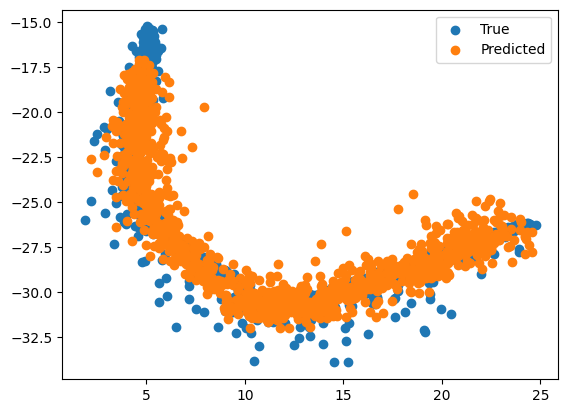

In [45]:
plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = model.predict(x_train)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

10/10 [==============================] - 0s 2ms/step


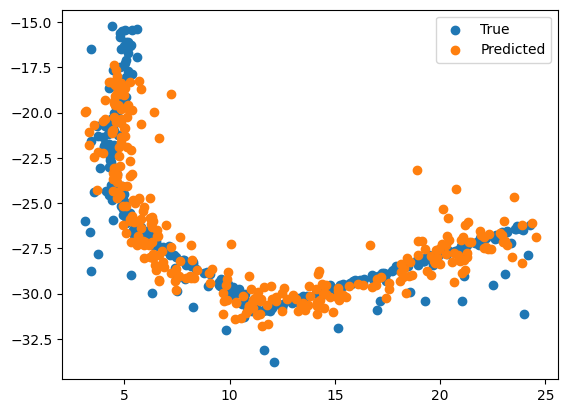

In [46]:
plt.scatter(y_test[:, 0], y_test[:, 1], label="True")
pred = model.predict(x_test)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()